In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [2]:
# Load
df = pd.read_csv("labeled_data.csv")
df = df[['class', 'tweet']]
df.head()

class                                              tweet
0      2  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [3]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# define compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

=== Original Class Distribution ===
class
0     1430
1    19190
2     4163
Name: count, dtype: int64

Class Proportions:
class
0    0.057701
1    0.774321
2    0.167978
Name: proportion, dtype: float64


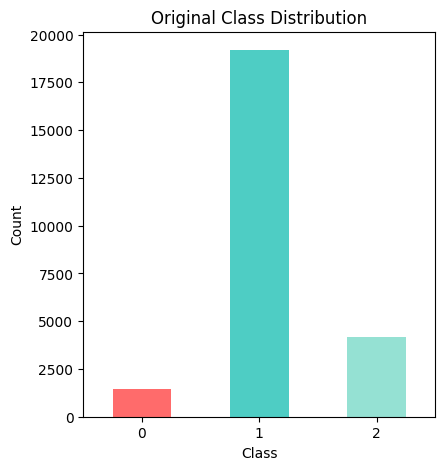

In [4]:
# Cell 4: Enhanced Text Cleaning and Class Distribution Analysis
import re
import matplotlib.pyplot as plt
import seaborn as sns

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_tweet'] = df['tweet'].apply(clean_tweet)

# Analyze class distribution BEFORE balancing
print("=== Original Class Distribution ===")
print(df['class'].value_counts().sort_index())
print("\nClass Proportions:")
print(df['class'].value_counts(normalize=True).sort_index())

# Visualize imbalance
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['class'].value_counts().sort_index().plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Store for later comparison
original_distribution = df['class'].value_counts().sort_index()

Train set size: 19826
Test set size: 4957

=== Train Set Class Distribution (Before SMOTE) ===
class
0     1144
1    15352
2     3330
Name: count, dtype: int64

=== Train Set Class Distribution (After SMOTE) ===
class
0    15352
1    15352
2    15352
Name: count, dtype: int64

Final balanced train set size: 46056
Test set size: 4957


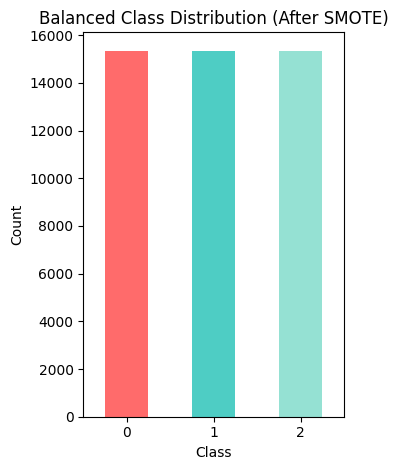


✓ SMOTE balancing complete. Saved visualization to 'class_distribution_comparison.png'


In [5]:
# Cell 5: SMOTE Implementation for Text Data
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Initial train-test split (before SMOTE to avoid data leakage)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_tweet'], 
    df['class'],
    test_size=0.2, 
    stratify=df['class'], 
    random_state=42
)

print(f"Train set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")
print("\n=== Train Set Class Distribution (Before SMOTE) ===")
print(y_train.value_counts().sort_index())

train_df_original = pd.DataFrame({
    "text": X_train_text.values,
    "labels": y_train.values
})

test_df_original = pd.DataFrame({
    "text": X_test_text.values,
    "labels": y_test.values
})

# Step 2: Create TF-IDF features for SMOTE (it needs numeric input)
# We'll use this ONLY for SMOTE, not for BERT training
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_tfidf_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

print("\n=== Train Set Class Distribution (After SMOTE) ===")
print(pd.Series(y_train_balanced).value_counts().sort_index())

# Step 4: Important - we need to get back the TEXT (not TF-IDF vectors) for BERT
# SMOTE creates synthetic TF-IDF vectors, but we need actual text
# Strategy: Find nearest original text samples to synthetic vectors
from sklearn.metrics.pairwise import cosine_similarity

def map_synthetic_to_text(X_synthetic, X_original_tfidf, original_texts, y_synthetic, y_original):
    """Map synthetic TF-IDF vectors back to text by finding nearest neighbors"""
    texts_balanced = []
    labels_balanced = []
    
    for i in range(X_synthetic.shape[0]):
        # Check if this is an original sample (exact match in X_original_tfidf)
        similarities = cosine_similarity(X_synthetic[i], X_original_tfidf).flatten()
        if similarities.max() == 1.0:  # Exact match - original sample
            idx = similarities.argmax()
            texts_balanced.append(original_texts.iloc[idx])
        else:  # Synthetic sample - find nearest neighbor and add slight variation
            idx = similarities.argmax()
            original_text = original_texts.iloc[idx]
            # Add marker to track synthetic samples (optional)
            texts_balanced.append(original_text)  # Keep original text
        
        labels_balanced.append(y_synthetic[i])
    
    return texts_balanced, labels_balanced

# Apply mapping
X_train_balanced, y_train_balanced = map_synthetic_to_text(
    X_train_tfidf_balanced, 
    X_train_tfidf, 
    X_train_text.reset_index(drop=True),
    y_train_balanced,
    y_train.values
)

# Create balanced DataFrames
train_df = pd.DataFrame({
    'text': X_train_balanced,
    'labels': y_train_balanced
})

test_df = pd.DataFrame({
    'text': X_test_text.values,
    'labels': y_test.values
})

print(f"\nFinal balanced train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Visualize BEFORE vs AFTER
plt.subplot(1, 2, 2)
pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
plt.title('Balanced Class Distribution (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('class_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ SMOTE balancing complete. Saved visualization to 'class_distribution_comparison.png'")

In [6]:
# Cell 6: Model Configurations for Comparison
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification
)

# Define model configurations
MODEL_CONFIGS = {
    'bert-base-uncased': {
        'tokenizer': BertTokenizer,
        'model': BertForSequenceClassification,
        'description': 'BERT Base (110M params) - Bidirectional encoding'
    },
    'roberta-base': {
        'tokenizer': RobertaTokenizer,
        'model': RobertaForSequenceClassification,
        'description': 'RoBERTa Base (125M params) - Optimized BERT variant'
    },
    'distilbert-base-uncased': {
        'tokenizer': DistilBertTokenizer,
        'model': DistilBertForSequenceClassification,
        'description': 'DistilBERT (66M params) - Faster, 97% BERT performance'
    }
}

print("=== Models to be Trained ===")
for model_name, config in MODEL_CONFIGS.items():
    print(f"\n{model_name}")
    print(f"  {config['description']}")

=== Models to be Trained ===

bert-base-uncased
  BERT Base (110M params) - Bidirectional encoding

roberta-base
  RoBERTa Base (125M params) - Optimized BERT variant

distilbert-base-uncased
  DistilBERT (66M params) - Faster, 97% BERT performance


In [7]:
# Cell 7: Enhanced Tokenization Function
from datasets import Dataset

def prepare_dataset(df, tokenizer, max_length=128):
    """Tokenize and prepare dataset for a specific model"""
    
    def tokenize(batch):
        return tokenizer(
            batch['text'], 
            padding='max_length', 
            truncation=True, 
            max_length=max_length
        )
    
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(tokenize, batched=True)
    dataset.set_format(
        type='torch', 
        columns=['input_ids', 'attention_mask', 'labels']
    )
    
    return dataset

print("✓ Dataset preparation function defined")


✓ Dataset preparation function defined


In [8]:
# Cell 8: Multi-Model Training Pipeline
import torch
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, classification_report
)
import numpy as np
import json
from datetime import datetime

# Enhanced compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)
    
    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = \
        precision_recall_fscore_support(labels, preds, average=None)
    
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "precision_class_0": precision_per_class[0],
        "precision_class_1": precision_per_class[1],
        "precision_class_2": precision_per_class[2],
        "recall_class_0": recall_per_class[0],
        "recall_class_1": recall_per_class[1],
        "recall_class_2": recall_per_class[2],
        "f1_class_0": f1_per_class[0],
        "f1_class_1": f1_per_class[1],
        "f1_class_2": f1_per_class[2],
    }

# Storage for results
all_results_original = {}
all_results_smote = {}

trained_models_original = {}
trained_models_smote = {}
DATA_VARIANTS = {
    "original": (train_df_original, test_df_original),
    "smote": (train_df, test_df)
}


# ==================================================
# TRAIN MODELS TWICE: ORIGINAL + SMOTE
# ==================================================

for variant_name in DATA_VARIANTS.keys():

    print(f"\n==============================")
    print(f"Training on: {variant_name.upper()} dataset")
    print(f"==============================")

    train_df_variant, test_df_variant = DATA_VARIANTS[variant_name]

    # Decide which dictionary to fill
    results_dict = all_results_original if variant_name == "original" else all_results_smote
    model_store = trained_models_original if variant_name == "original" else trained_models_smote

    for model_name, config in MODEL_CONFIGS.items():

        print(f"\n{'='*60}")
        print(f"Training: {model_name} ({variant_name})")
        print(f"{'='*60}")

        tokenizer = config['tokenizer'].from_pretrained(model_name)
        model = config['model'].from_pretrained(model_name, num_labels=3)

        train_dataset = prepare_dataset(train_df_variant, tokenizer)
        test_dataset = prepare_dataset(test_df_variant, tokenizer)

        training_args = TrainingArguments(
            output_dir=f"./results_{model_name.replace('/', '_')}_{variant_name}",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            logging_dir=f"./logs_{model_name.replace('/', '_')}_{variant_name}",
            num_train_epochs=5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            learning_rate=2e-5,
            weight_decay=0.01,
            logging_steps=100,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            save_total_limit=2,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )

        train_result = trainer.train()
        eval_result = trainer.evaluate()

        # Predictions
        predictions = trainer.predict(test_dataset)
        y_pred = np.argmax(predictions.predictions, axis=-1)
        y_true = predictions.label_ids

        results_dict[model_name] = {
            'eval_metrics': eval_result,
            'train_metrics': train_result.metrics,
            'confusion_matrix': confusion_matrix(y_true, y_pred).tolist(),
            'classification_report': classification_report(
                y_true, y_pred,
                target_names=['Class 0', 'Class 1', 'Class 2'],
                output_dict=True
            )
        }

        model_store[model_name] = {
            'model': model,
            'tokenizer': tokenizer,
            'predictions': y_pred,
            'true_labels': y_true,
            'test_df': test_df_variant
        }

        print(f"\n--- {model_name} ({variant_name}) Results ---")
        print(f"Accuracy:  {eval_result['eval_accuracy']:.4f}")
        print(f"F1 Score:  {eval_result['eval_f1']:.4f}")
        print(f"Precision: {eval_result['eval_precision']:.4f}")
        print(f"Recall:    {eval_result['eval_recall']:.4f}")



Training on: ORIGINAL dataset

Training: bert-base-uncased (original)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

d:\RP\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/6200 [00:00<?, ?it/s]

{'loss': 0.5172, 'grad_norm': 7.425182342529297, 'learning_rate': 1.967741935483871e-05, 'epoch': 0.08}
{'loss': 0.3086, 'grad_norm': 3.491697072982788, 'learning_rate': 1.935483870967742e-05, 'epoch': 0.16}
{'loss': 0.3343, 'grad_norm': 3.995501756668091, 'learning_rate': 1.903225806451613e-05, 'epoch': 0.24}
{'loss': 0.2921, 'grad_norm': 8.29039192199707, 'learning_rate': 1.870967741935484e-05, 'epoch': 0.32}
{'loss': 0.3345, 'grad_norm': 2.6688480377197266, 'learning_rate': 1.838709677419355e-05, 'epoch': 0.4}
{'loss': 0.2793, 'grad_norm': 2.3921995162963867, 'learning_rate': 1.806451612903226e-05, 'epoch': 0.48}
{'loss': 0.2852, 'grad_norm': 5.525950908660889, 'learning_rate': 1.774193548387097e-05, 'epoch': 0.56}
{'loss': 0.2697, 'grad_norm': 3.6794681549072266, 'learning_rate': 1.741935483870968e-05, 'epoch': 0.65}
{'loss': 0.2514, 'grad_norm': 3.0658771991729736, 'learning_rate': 1.7096774193548388e-05, 'epoch': 0.73}
{'loss': 0.2672, 'grad_norm': 4.847303867340088, 'learning_ra

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.2551433742046356, 'eval_accuracy': 0.9134557191849909, 'eval_precision': 0.9102120537443444, 'eval_recall': 0.9134557191849909, 'eval_f1': 0.9116915586942347, 'eval_precision_class_0': 0.4939759036144578, 'eval_precision_class_1': 0.9464285714285714, 'eval_precision_class_2': 0.8862559241706162, 'eval_recall_class_0': 0.43006993006993005, 'eval_recall_class_1': 0.9528400208441897, 'eval_recall_class_2': 0.8979591836734694, 'eval_f1_class_0': 0.45981308411214955, 'eval_f1_class_1': 0.9496234744222279, 'eval_f1_class_2': 0.8920691711389386, 'eval_runtime': 19.2012, 'eval_samples_per_second': 258.161, 'eval_steps_per_second': 16.145, 'epoch': 1.0}
{'loss': 0.248, 'grad_norm': 4.563050270080566, 'learning_rate': 1.5806451612903226e-05, 'epoch': 1.05}
{'loss': 0.2547, 'grad_norm': 0.3361941874027252, 'learning_rate': 1.5483870967741936e-05, 'epoch': 1.13}
{'loss': 0.2285, 'grad_norm': 1.646047830581665, 'learning_rate': 1.5161290322580646e-05, 'epoch': 1.21}
{'loss': 0.2077,

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.27819496393203735, 'eval_accuracy': 0.9080088763364939, 'eval_precision': 0.8960702718618727, 'eval_recall': 0.9080088763364939, 'eval_f1': 0.8982438833567312, 'eval_precision_class_0': 0.5454545454545454, 'eval_precision_class_1': 0.9216510133465151, 'eval_precision_class_2': 0.8985879332477535, 'eval_recall_class_0': 0.2517482517482518, 'eval_recall_class_1': 0.9715997915581032, 'eval_recall_class_2': 0.8403361344537815, 'eval_f1_class_0': 0.3444976076555024, 'eval_f1_class_1': 0.9459665144596652, 'eval_f1_class_2': 0.8684863523573201, 'eval_runtime': 19.3075, 'eval_samples_per_second': 256.74, 'eval_steps_per_second': 16.056, 'epoch': 2.0}
{'loss': 0.2394, 'grad_norm': 1.5414959192276, 'learning_rate': 1.1935483870967743e-05, 'epoch': 2.02}
{'loss': 0.1998, 'grad_norm': 1.3185029029846191, 'learning_rate': 1.1612903225806453e-05, 'epoch': 2.1}
{'loss': 0.1573, 'grad_norm': 1.366849422454834, 'learning_rate': 1.1290322580645164e-05, 'epoch': 2.18}
{'loss': 0.1828, 'gr

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.30687958002090454, 'eval_accuracy': 0.9067984668146056, 'eval_precision': 0.9020551669184376, 'eval_recall': 0.9067984668146056, 'eval_f1': 0.9038369127223381, 'eval_precision_class_0': 0.48739495798319327, 'eval_precision_class_1': 0.9334008609774627, 'eval_precision_class_2': 0.9, 'eval_recall_class_0': 0.40559440559440557, 'eval_recall_class_1': 0.9603960396039604, 'eval_recall_class_2': 0.8319327731092437, 'eval_f1_class_0': 0.44274809160305345, 'eval_f1_class_1': 0.9467060485424426, 'eval_f1_class_2': 0.8646288209606987, 'eval_runtime': 19.2351, 'eval_samples_per_second': 257.706, 'eval_steps_per_second': 16.116, 'epoch': 3.0}
{'loss': 0.1454, 'grad_norm': 6.7986555099487305, 'learning_rate': 7.741935483870968e-06, 'epoch': 3.06}
{'loss': 0.1088, 'grad_norm': 20.873048782348633, 'learning_rate': 7.4193548387096784e-06, 'epoch': 3.15}
{'loss': 0.1243, 'grad_norm': 1.6641597747802734, 'learning_rate': 7.096774193548388e-06, 'epoch': 3.23}
{'loss': 0.1171, 'grad_norm'

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.3587350845336914, 'eval_accuracy': 0.910026225539641, 'eval_precision': 0.904712869917086, 'eval_recall': 0.910026225539641, 'eval_f1': 0.9068547915727878, 'eval_precision_class_0': 0.5363636363636364, 'eval_precision_class_1': 0.9382209689823122, 'eval_precision_class_2': 0.8767942583732058, 'eval_recall_class_0': 0.4125874125874126, 'eval_recall_class_1': 0.9536216779572694, 'eval_recall_class_2': 0.879951980792317, 'eval_f1_class_0': 0.466403162055336, 'eval_f1_class_1': 0.9458586380669337, 'eval_f1_class_2': 0.8783702816057519, 'eval_runtime': 19.186, 'eval_samples_per_second': 258.365, 'eval_steps_per_second': 16.158, 'epoch': 4.0}
{'loss': 0.1143, 'grad_norm': 8.047540664672852, 'learning_rate': 3.870967741935484e-06, 'epoch': 4.03}
{'loss': 0.1002, 'grad_norm': 27.57338523864746, 'learning_rate': 3.548387096774194e-06, 'epoch': 4.11}
{'loss': 0.0774, 'grad_norm': 0.16007861495018005, 'learning_rate': 3.225806451612903e-06, 'epoch': 4.19}
{'loss': 0.0726, 'grad_no

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.4042544960975647, 'eval_accuracy': 0.9076054064958644, 'eval_precision': 0.9011902355818646, 'eval_recall': 0.9076054064958644, 'eval_f1': 0.9036317241375524, 'eval_precision_class_0': 0.5260663507109005, 'eval_precision_class_1': 0.932741116751269, 'eval_precision_class_2': 0.8846153846153846, 'eval_recall_class_0': 0.3881118881118881, 'eval_recall_class_1': 0.9575299635226681, 'eval_recall_class_2': 0.8559423769507803, 'eval_f1_class_0': 0.44668008048289737, 'eval_f1_class_1': 0.9449730007714066, 'eval_f1_class_2': 0.8700427089688835, 'eval_runtime': 19.2353, 'eval_samples_per_second': 257.703, 'eval_steps_per_second': 16.116, 'epoch': 5.0}
{'train_runtime': 1470.0934, 'train_samples_per_second': 67.431, 'train_steps_per_second': 4.217, 'train_loss': 0.18712388315508444, 'epoch': 5.0}


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]


--- bert-base-uncased (original) Results ---
Accuracy:  0.9135
F1 Score:  0.9117
Precision: 0.9102
Recall:    0.9135

Training: roberta-base (original)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

d:\RP\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/6200 [00:00<?, ?it/s]

{'loss': 0.5635, 'grad_norm': 9.619914054870605, 'learning_rate': 1.967741935483871e-05, 'epoch': 0.08}
{'loss': 0.2972, 'grad_norm': 8.695246696472168, 'learning_rate': 1.935483870967742e-05, 'epoch': 0.16}
{'loss': 0.3342, 'grad_norm': 4.358607292175293, 'learning_rate': 1.903225806451613e-05, 'epoch': 0.24}
{'loss': 0.3149, 'grad_norm': 4.247696876525879, 'learning_rate': 1.870967741935484e-05, 'epoch': 0.32}
{'loss': 0.3353, 'grad_norm': 2.301147937774658, 'learning_rate': 1.838709677419355e-05, 'epoch': 0.4}
{'loss': 0.2748, 'grad_norm': 6.757986068725586, 'learning_rate': 1.806451612903226e-05, 'epoch': 0.48}
{'loss': 0.3087, 'grad_norm': 8.074700355529785, 'learning_rate': 1.774193548387097e-05, 'epoch': 0.56}
{'loss': 0.2784, 'grad_norm': 4.129087448120117, 'learning_rate': 1.741935483870968e-05, 'epoch': 0.65}
{'loss': 0.2827, 'grad_norm': 3.541510820388794, 'learning_rate': 1.7096774193548388e-05, 'epoch': 0.73}
{'loss': 0.2734, 'grad_norm': 4.737855911254883, 'learning_rate'

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.28164801001548767, 'eval_accuracy': 0.903772443009885, 'eval_precision': 0.8924510296976816, 'eval_recall': 0.903772443009885, 'eval_f1': 0.8963590620050516, 'eval_precision_class_0': 0.42857142857142855, 'eval_precision_class_1': 0.9239970097184151, 'eval_precision_class_2': 0.9063719115734721, 'eval_recall_class_0': 0.26223776223776224, 'eval_recall_class_1': 0.9661281917665451, 'eval_recall_class_2': 0.8367346938775511, 'eval_f1_class_0': 0.32537960954446854, 'eval_f1_class_1': 0.9445930454719144, 'eval_f1_class_2': 0.8701622971285893, 'eval_runtime': 19.951, 'eval_samples_per_second': 248.459, 'eval_steps_per_second': 15.538, 'epoch': 1.0}
{'loss': 0.2548, 'grad_norm': 4.399578094482422, 'learning_rate': 1.5806451612903226e-05, 'epoch': 1.05}
{'loss': 0.2887, 'grad_norm': 0.6063273549079895, 'learning_rate': 1.5483870967741936e-05, 'epoch': 1.13}
{'loss': 0.2481, 'grad_norm': 0.8695216774940491, 'learning_rate': 1.5161290322580646e-05, 'epoch': 1.21}
{'loss': 0.2326

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.2688181698322296, 'eval_accuracy': 0.9114383699818439, 'eval_precision': 0.8968782389095573, 'eval_recall': 0.9114383699818439, 'eval_f1': 0.9001434776994901, 'eval_precision_class_0': 0.5, 'eval_precision_class_1': 0.925613687081577, 'eval_precision_class_2': 0.9007444168734491, 'eval_recall_class_0': 0.2062937062937063, 'eval_recall_class_1': 0.9726420010422094, 'eval_recall_class_2': 0.8715486194477791, 'eval_f1_class_0': 0.29207920792079206, 'eval_f1_class_1': 0.9485452928471605, 'eval_f1_class_2': 0.8859060402684564, 'eval_runtime': 19.9961, 'eval_samples_per_second': 247.898, 'eval_steps_per_second': 15.503, 'epoch': 2.0}
{'loss': 0.2635, 'grad_norm': 24.903743743896484, 'learning_rate': 1.1935483870967743e-05, 'epoch': 2.02}
{'loss': 0.2502, 'grad_norm': 2.351217746734619, 'learning_rate': 1.1612903225806453e-05, 'epoch': 2.1}
{'loss': 0.1951, 'grad_norm': 1.8249170780181885, 'learning_rate': 1.1290322580645164e-05, 'epoch': 2.18}
{'loss': 0.2062, 'grad_norm': 0.

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.2969176173210144, 'eval_accuracy': 0.9080088763364939, 'eval_precision': 0.9041050283042051, 'eval_recall': 0.9080088763364939, 'eval_f1': 0.9053000885580138, 'eval_precision_class_0': 0.4897119341563786, 'eval_precision_class_1': 0.9303557910673732, 'eval_precision_class_2': 0.9254327563249002, 'eval_recall_class_0': 0.4160839160839161, 'eval_recall_class_1': 0.960656591974987, 'eval_recall_class_2': 0.8343337334933973, 'eval_f1_class_0': 0.4499054820415879, 'eval_f1_class_1': 0.9452634277656711, 'eval_f1_class_2': 0.8775252525252525, 'eval_runtime': 20.0708, 'eval_samples_per_second': 246.975, 'eval_steps_per_second': 15.445, 'epoch': 3.0}
{'loss': 0.2002, 'grad_norm': 24.119930267333984, 'learning_rate': 7.741935483870968e-06, 'epoch': 3.06}
{'loss': 0.1808, 'grad_norm': 8.518274307250977, 'learning_rate': 7.4193548387096784e-06, 'epoch': 3.15}
{'loss': 0.195, 'grad_norm': 4.842365741729736, 'learning_rate': 7.096774193548388e-06, 'epoch': 3.23}
{'loss': 0.17, 'grad_

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.29997995495796204, 'eval_accuracy': 0.9124470445834174, 'eval_precision': 0.9030913566598655, 'eval_recall': 0.9124470445834174, 'eval_f1': 0.9061489916788256, 'eval_precision_class_0': 0.52, 'eval_precision_class_1': 0.9324426518779935, 'eval_precision_class_2': 0.8993865030674847, 'eval_recall_class_0': 0.3181818181818182, 'eval_recall_class_1': 0.9637832204273059, 'eval_recall_class_2': 0.879951980792317, 'eval_f1_class_0': 0.3947939262472885, 'eval_f1_class_1': 0.9478539397821909, 'eval_f1_class_2': 0.8895631067961165, 'eval_runtime': 19.9913, 'eval_samples_per_second': 247.958, 'eval_steps_per_second': 15.507, 'epoch': 4.0}
{'loss': 0.191, 'grad_norm': 6.603855133056641, 'learning_rate': 3.870967741935484e-06, 'epoch': 4.03}
{'loss': 0.1696, 'grad_norm': 4.303725719451904, 'learning_rate': 3.548387096774194e-06, 'epoch': 4.11}
{'loss': 0.1348, 'grad_norm': 1.265291690826416, 'learning_rate': 3.225806451612903e-06, 'epoch': 4.19}
{'loss': 0.1376, 'grad_norm': 6.4614

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.33675438165664673, 'eval_accuracy': 0.9126487795037321, 'eval_precision': 0.9063665041446314, 'eval_recall': 0.9126487795037321, 'eval_f1': 0.9087887498859222, 'eval_precision_class_0': 0.5333333333333333, 'eval_precision_class_1': 0.937547795054805, 'eval_precision_class_2': 0.8907766990291263, 'eval_recall_class_0': 0.3916083916083916, 'eval_recall_class_1': 0.9583116206357478, 'eval_recall_class_2': 0.8811524609843937, 'eval_f1_class_0': 0.45161290322580644, 'eval_f1_class_1': 0.947816003092385, 'eval_f1_class_2': 0.8859384429692215, 'eval_runtime': 19.9145, 'eval_samples_per_second': 248.914, 'eval_steps_per_second': 15.567, 'epoch': 5.0}
{'train_runtime': 1556.9476, 'train_samples_per_second': 63.669, 'train_steps_per_second': 3.982, 'train_loss': 0.2286235724726031, 'epoch': 5.0}


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]


--- roberta-base (original) Results ---
Accuracy:  0.9126
F1 Score:  0.9088
Precision: 0.9064
Recall:    0.9126

Training: distilbert-base-uncased (original)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

d:\RP\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/6200 [00:00<?, ?it/s]

{'loss': 0.5444, 'grad_norm': 5.0797834396362305, 'learning_rate': 1.967741935483871e-05, 'epoch': 0.08}
{'loss': 0.3118, 'grad_norm': 4.306127548217773, 'learning_rate': 1.935483870967742e-05, 'epoch': 0.16}
{'loss': 0.3264, 'grad_norm': 2.3214833736419678, 'learning_rate': 1.903225806451613e-05, 'epoch': 0.24}
{'loss': 0.2943, 'grad_norm': 2.064800500869751, 'learning_rate': 1.870967741935484e-05, 'epoch': 0.32}
{'loss': 0.3181, 'grad_norm': 1.683436393737793, 'learning_rate': 1.838709677419355e-05, 'epoch': 0.4}
{'loss': 0.2692, 'grad_norm': 7.80466365814209, 'learning_rate': 1.806451612903226e-05, 'epoch': 0.48}
{'loss': 0.2921, 'grad_norm': 3.6412057876586914, 'learning_rate': 1.774193548387097e-05, 'epoch': 0.56}
{'loss': 0.2637, 'grad_norm': 2.3166327476501465, 'learning_rate': 1.741935483870968e-05, 'epoch': 0.65}
{'loss': 0.2497, 'grad_norm': 1.6212669610977173, 'learning_rate': 1.7096774193548388e-05, 'epoch': 0.73}
{'loss': 0.2651, 'grad_norm': 4.462172031402588, 'learning_r

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.26315590739250183, 'eval_accuracy': 0.9063949969739762, 'eval_precision': 0.8990755228694971, 'eval_recall': 0.9063949969739762, 'eval_f1': 0.9021419485479948, 'eval_precision_class_0': 0.4439252336448598, 'eval_precision_class_1': 0.9348766217247519, 'eval_precision_class_2': 0.8903940886699507, 'eval_recall_class_0': 0.3321678321678322, 'eval_recall_class_1': 0.9575299635226681, 'eval_recall_class_2': 0.8679471788715486, 'eval_f1_class_0': 0.38, 'eval_f1_class_1': 0.9460677049813361, 'eval_f1_class_2': 0.8790273556231003, 'eval_runtime': 10.3391, 'eval_samples_per_second': 479.441, 'eval_steps_per_second': 29.983, 'epoch': 1.0}
{'loss': 0.2396, 'grad_norm': 7.036268711090088, 'learning_rate': 1.5806451612903226e-05, 'epoch': 1.05}
{'loss': 0.2654, 'grad_norm': 0.2919462323188782, 'learning_rate': 1.5483870967741936e-05, 'epoch': 1.13}
{'loss': 0.2221, 'grad_norm': 0.8646050691604614, 'learning_rate': 1.5161290322580646e-05, 'epoch': 1.21}
{'loss': 0.2045, 'grad_norm':

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.2606368958950043, 'eval_accuracy': 0.9146661287068791, 'eval_precision': 0.902963926852988, 'eval_recall': 0.9146661287068791, 'eval_f1': 0.9058512549821721, 'eval_precision_class_0': 0.5357142857142857, 'eval_precision_class_1': 0.9327478042659975, 'eval_precision_class_2': 0.8918269230769231, 'eval_recall_class_0': 0.26223776223776224, 'eval_recall_class_1': 0.9684731631057842, 'eval_recall_class_2': 0.8907563025210085, 'eval_f1_class_0': 0.352112676056338, 'eval_f1_class_1': 0.9502748306276364, 'eval_f1_class_2': 0.8912912912912913, 'eval_runtime': 10.3295, 'eval_samples_per_second': 479.888, 'eval_steps_per_second': 30.011, 'epoch': 2.0}
{'loss': 0.2389, 'grad_norm': 3.658353567123413, 'learning_rate': 1.1935483870967743e-05, 'epoch': 2.02}
{'loss': 0.213, 'grad_norm': 0.2741786241531372, 'learning_rate': 1.1612903225806453e-05, 'epoch': 2.1}
{'loss': 0.1613, 'grad_norm': 2.7343361377716064, 'learning_rate': 1.1290322580645164e-05, 'epoch': 2.18}
{'loss': 0.1838, 'g

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.297736793756485, 'eval_accuracy': 0.9110349001412145, 'eval_precision': 0.9048436867930237, 'eval_recall': 0.9110349001412145, 'eval_f1': 0.9066000656645339, 'eval_precision_class_0': 0.5480769230769231, 'eval_precision_class_1': 0.9289111389236546, 'eval_precision_class_2': 0.916445623342175, 'eval_recall_class_0': 0.3986013986013986, 'eval_recall_class_1': 0.9669098488796248, 'eval_recall_class_2': 0.82953181272509, 'eval_f1_class_0': 0.46153846153846156, 'eval_f1_class_1': 0.9475296821141325, 'eval_f1_class_2': 0.870825456836799, 'eval_runtime': 10.3301, 'eval_samples_per_second': 479.862, 'eval_steps_per_second': 30.01, 'epoch': 3.0}
{'loss': 0.1553, 'grad_norm': 6.828960418701172, 'learning_rate': 7.741935483870968e-06, 'epoch': 3.06}
{'loss': 0.1454, 'grad_norm': 9.146800994873047, 'learning_rate': 7.4193548387096784e-06, 'epoch': 3.15}
{'loss': 0.1546, 'grad_norm': 4.993888854980469, 'learning_rate': 7.096774193548388e-06, 'epoch': 3.23}
{'loss': 0.1456, 'grad_no

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.32166361808776855, 'eval_accuracy': 0.9108331652208997, 'eval_precision': 0.9018159838442533, 'eval_recall': 0.9108331652208997, 'eval_f1': 0.9044726547595772, 'eval_precision_class_0': 0.5402298850574713, 'eval_precision_class_1': 0.9290726817042606, 'eval_precision_class_2': 0.9003783102143758, 'eval_recall_class_0': 0.32867132867132864, 'eval_recall_class_1': 0.9658676393955185, 'eval_recall_class_2': 0.8571428571428571, 'eval_f1_class_0': 0.40869565217391307, 'eval_f1_class_1': 0.9471129279509454, 'eval_f1_class_2': 0.8782287822878229, 'eval_runtime': 10.3513, 'eval_samples_per_second': 478.876, 'eval_steps_per_second': 29.948, 'epoch': 4.0}
{'loss': 0.1351, 'grad_norm': 3.582468271255493, 'learning_rate': 3.870967741935484e-06, 'epoch': 4.03}
{'loss': 0.1175, 'grad_norm': 0.11120353639125824, 'learning_rate': 3.548387096774194e-06, 'epoch': 4.11}
{'loss': 0.1077, 'grad_norm': 0.41019293665885925, 'learning_rate': 3.225806451612903e-06, 'epoch': 4.19}
{'loss': 0.089

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.3461635410785675, 'eval_accuracy': 0.9126487795037321, 'eval_precision': 0.9053068312417325, 'eval_recall': 0.9126487795037321, 'eval_f1': 0.9079681176977505, 'eval_precision_class_0': 0.5329949238578681, 'eval_precision_class_1': 0.936262061960386, 'eval_precision_class_2': 0.8905109489051095, 'eval_recall_class_0': 0.36713286713286714, 'eval_recall_class_1': 0.960656591974987, 'eval_recall_class_2': 0.8787515006002401, 'eval_f1_class_0': 0.43478260869565216, 'eval_f1_class_1': 0.9483024691358025, 'eval_f1_class_2': 0.8845921450151057, 'eval_runtime': 10.3178, 'eval_samples_per_second': 480.433, 'eval_steps_per_second': 30.045, 'epoch': 5.0}
{'train_runtime': 813.9799, 'train_samples_per_second': 121.784, 'train_steps_per_second': 7.617, 'train_loss': 0.19663644636830976, 'epoch': 5.0}


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]


--- distilbert-base-uncased (original) Results ---
Accuracy:  0.9126
F1 Score:  0.9080
Precision: 0.9053
Recall:    0.9126

Training on: SMOTE dataset

Training: bert-base-uncased (smote)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/46056 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

d:\RP\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/14395 [00:00<?, ?it/s]

{'loss': 0.8139, 'grad_norm': 7.71229887008667, 'learning_rate': 1.9861062869051756e-05, 'epoch': 0.03}
{'loss': 0.509, 'grad_norm': 14.797697067260742, 'learning_rate': 1.972212573810351e-05, 'epoch': 0.07}
{'loss': 0.462, 'grad_norm': 8.414169311523438, 'learning_rate': 1.9583188607155263e-05, 'epoch': 0.1}
{'loss': 0.4626, 'grad_norm': 6.5578413009643555, 'learning_rate': 1.9444251476207017e-05, 'epoch': 0.14}
{'loss': 0.4042, 'grad_norm': 7.998484134674072, 'learning_rate': 1.9305314345258772e-05, 'epoch': 0.17}
{'loss': 0.413, 'grad_norm': 26.62405014038086, 'learning_rate': 1.9166377214310524e-05, 'epoch': 0.21}
{'loss': 0.3605, 'grad_norm': 7.157303333282471, 'learning_rate': 1.9027440083362282e-05, 'epoch': 0.24}
{'loss': 0.347, 'grad_norm': 11.204814910888672, 'learning_rate': 1.8888502952414033e-05, 'epoch': 0.28}
{'loss': 0.3194, 'grad_norm': 10.289602279663086, 'learning_rate': 1.8749565821465788e-05, 'epoch': 0.31}
{'loss': 0.3085, 'grad_norm': 6.882046699523926, 'learning

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.4667881429195404, 'eval_accuracy': 0.8791607827314908, 'eval_precision': 0.9098277986890266, 'eval_recall': 0.8791607827314908, 'eval_f1': 0.8910089627121408, 'eval_precision_class_0': 0.3307543520309478, 'eval_precision_class_1': 0.9633699633699634, 'eval_precision_class_2': 0.8619528619528619, 'eval_recall_class_0': 0.5979020979020979, 'eval_recall_class_1': 0.8908285565398645, 'eval_recall_class_2': 0.921968787515006, 'eval_f1_class_0': 0.4259028642590286, 'eval_f1_class_1': 0.9256802490862326, 'eval_f1_class_2': 0.8909512761020881, 'eval_runtime': 19.1971, 'eval_samples_per_second': 258.216, 'eval_steps_per_second': 16.148, 'epoch': 1.0}
{'loss': 0.1643, 'grad_norm': 1.7239437103271484, 'learning_rate': 1.597082320250087e-05, 'epoch': 1.01}
{'loss': 0.1124, 'grad_norm': 0.9530269503593445, 'learning_rate': 1.5831886071552625e-05, 'epoch': 1.04}
{'loss': 0.1091, 'grad_norm': 2.1306707859039307, 'learning_rate': 1.5692948940604377e-05, 'epoch': 1.08}
{'loss': 0.1186, 

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.5564348697662354, 'eval_accuracy': 0.9108331652208997, 'eval_precision': 0.9082128249292243, 'eval_recall': 0.9108331652208997, 'eval_f1': 0.9092851128769008, 'eval_precision_class_0': 0.484, 'eval_precision_class_1': 0.947987454260324, 'eval_precision_class_2': 0.8706015891032917, 'eval_recall_class_0': 0.4230769230769231, 'eval_recall_class_1': 0.9450234497133924, 'eval_recall_class_2': 0.9207683073229291, 'eval_f1_class_0': 0.45149253731343286, 'eval_f1_class_1': 0.9465031315240083, 'eval_f1_class_2': 0.8949824970828472, 'eval_runtime': 19.1723, 'eval_samples_per_second': 258.55, 'eval_steps_per_second': 16.169, 'epoch': 2.0}
{'loss': 0.0799, 'grad_norm': 0.01189727708697319, 'learning_rate': 1.1941646405001736e-05, 'epoch': 2.01}
{'loss': 0.0543, 'grad_norm': 17.8745174407959, 'learning_rate': 1.1802709274053493e-05, 'epoch': 2.05}
{'loss': 0.0588, 'grad_norm': 0.42253637313842773, 'learning_rate': 1.1663772143105246e-05, 'epoch': 2.08}
{'loss': 0.0659, 'grad_norm':

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.6140390038490295, 'eval_accuracy': 0.910631430300585, 'eval_precision': 0.9068506139914543, 'eval_recall': 0.910631430300585, 'eval_f1': 0.9085482138962826, 'eval_precision_class_0': 0.49387755102040815, 'eval_precision_class_1': 0.9405864197530864, 'eval_precision_class_2': 0.8932038834951457, 'eval_recall_class_0': 0.4230769230769231, 'eval_recall_class_1': 0.9528400208441897, 'eval_recall_class_2': 0.8835534213685474, 'eval_f1_class_0': 0.455743879472693, 'eval_f1_class_1': 0.9466735697644318, 'eval_f1_class_2': 0.8883524441762221, 'eval_runtime': 19.1723, 'eval_samples_per_second': 258.55, 'eval_steps_per_second': 16.169, 'epoch': 3.0}
{'loss': 0.0337, 'grad_norm': 0.18294748663902283, 'learning_rate': 7.912469607502605e-06, 'epoch': 3.02}
{'loss': 0.0399, 'grad_norm': 0.017455121502280235, 'learning_rate': 7.77353247655436e-06, 'epoch': 3.06}
{'loss': 0.0525, 'grad_norm': 0.005211313255131245, 'learning_rate': 7.634595345606113e-06, 'epoch': 3.09}
{'loss': 0.0396, 

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.6931483149528503, 'eval_accuracy': 0.9082106112568086, 'eval_precision': 0.9004331703599537, 'eval_recall': 0.9082106112568086, 'eval_f1': 0.903061212850665, 'eval_precision_class_0': 0.517948717948718, 'eval_precision_class_1': 0.9283379431732461, 'eval_precision_class_2': 0.9031847133757962, 'eval_recall_class_0': 0.3531468531468531, 'eval_recall_class_1': 0.9619593538301199, 'eval_recall_class_2': 0.851140456182473, 'eval_f1_class_0': 0.41995841995842, 'eval_f1_class_1': 0.944849648112604, 'eval_f1_class_2': 0.8763906056860321, 'eval_runtime': 19.2256, 'eval_samples_per_second': 257.834, 'eval_steps_per_second': 16.124, 'epoch': 4.0}
{'loss': 0.0303, 'grad_norm': 0.007070841267704964, 'learning_rate': 3.883292810003474e-06, 'epoch': 4.03}
{'loss': 0.0324, 'grad_norm': 0.16682471334934235, 'learning_rate': 3.7443556790552278e-06, 'epoch': 4.06}
{'loss': 0.023, 'grad_norm': 1.2491650581359863, 'learning_rate': 3.605418548106982e-06, 'epoch': 4.1}
{'loss': 0.0273, 'grad

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.7204425930976868, 'eval_accuracy': 0.9096227556990115, 'eval_precision': 0.9010113599839239, 'eval_recall': 0.9096227556990115, 'eval_f1': 0.9038306402748939, 'eval_precision_class_0': 0.5245901639344263, 'eval_precision_class_1': 0.9293081761006289, 'eval_precision_class_2': 0.899874843554443, 'eval_recall_class_0': 0.3356643356643357, 'eval_recall_class_1': 0.962480458572173, 'eval_recall_class_2': 0.8631452581032413, 'eval_f1_class_0': 0.4093816631130064, 'eval_f1_class_1': 0.9456034813771919, 'eval_f1_class_2': 0.8811274509803921, 'eval_runtime': 19.1532, 'eval_samples_per_second': 258.808, 'eval_steps_per_second': 16.185, 'epoch': 5.0}
{'train_runtime': 3284.1273, 'train_samples_per_second': 70.119, 'train_steps_per_second': 4.383, 'train_loss': 0.10603286015072312, 'epoch': 5.0}


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]


--- bert-base-uncased (smote) Results ---
Accuracy:  0.9108
F1 Score:  0.9093
Precision: 0.9082
Recall:    0.9108

Training: roberta-base (smote)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/46056 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

d:\RP\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/14395 [00:00<?, ?it/s]

{'loss': 0.8243, 'grad_norm': 28.557968139648438, 'learning_rate': 1.9861062869051756e-05, 'epoch': 0.03}
{'loss': 0.5207, 'grad_norm': 21.1645565032959, 'learning_rate': 1.972212573810351e-05, 'epoch': 0.07}
{'loss': 0.4892, 'grad_norm': 12.727204322814941, 'learning_rate': 1.9583188607155263e-05, 'epoch': 0.1}
{'loss': 0.5074, 'grad_norm': 7.053627967834473, 'learning_rate': 1.9444251476207017e-05, 'epoch': 0.14}
{'loss': 0.4461, 'grad_norm': 9.331751823425293, 'learning_rate': 1.9305314345258772e-05, 'epoch': 0.17}
{'loss': 0.4441, 'grad_norm': 40.74874496459961, 'learning_rate': 1.9166377214310524e-05, 'epoch': 0.21}
{'loss': 0.4374, 'grad_norm': 11.911417961120605, 'learning_rate': 1.9027440083362282e-05, 'epoch': 0.24}
{'loss': 0.3851, 'grad_norm': 26.85711097717285, 'learning_rate': 1.8888502952414033e-05, 'epoch': 0.28}
{'loss': 0.3709, 'grad_norm': 28.550783157348633, 'learning_rate': 1.8749565821465788e-05, 'epoch': 0.31}
{'loss': 0.3811, 'grad_norm': 13.774474143981934, 'lea

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.49073222279548645, 'eval_accuracy': 0.8638289287875731, 'eval_precision': 0.9057977476826253, 'eval_recall': 0.8638289287875731, 'eval_f1': 0.8798239032661864, 'eval_precision_class_0': 0.3085808580858086, 'eval_precision_class_1': 0.9566951566951567, 'eval_precision_class_2': 0.8763376932223543, 'eval_recall_class_0': 0.6538461538461539, 'eval_recall_class_1': 0.8749348619072433, 'eval_recall_class_2': 0.8847539015606243, 'eval_f1_class_0': 0.4192825112107623, 'eval_f1_class_1': 0.9139902014153511, 'eval_f1_class_2': 0.8805256869772998, 'eval_runtime': 19.9251, 'eval_samples_per_second': 248.781, 'eval_steps_per_second': 15.558, 'epoch': 1.0}
{'loss': 0.2369, 'grad_norm': 3.617119789123535, 'learning_rate': 1.597082320250087e-05, 'epoch': 1.01}
{'loss': 0.1841, 'grad_norm': 76.38872528076172, 'learning_rate': 1.5831886071552625e-05, 'epoch': 1.04}
{'loss': 0.1968, 'grad_norm': 41.928462982177734, 'learning_rate': 1.5692948940604377e-05, 'epoch': 1.08}
{'loss': 0.1874, 

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.5294091701507568, 'eval_accuracy': 0.9031672382489409, 'eval_precision': 0.9071099984492638, 'eval_recall': 0.9031672382489409, 'eval_f1': 0.9042489841680373, 'eval_precision_class_0': 0.44256756756756754, 'eval_precision_class_1': 0.9571313022378, 'eval_precision_class_2': 0.8361344537815126, 'eval_recall_class_0': 0.458041958041958, 'eval_recall_class_1': 0.924960917144346, 'eval_recall_class_2': 0.9555822328931572, 'eval_f1_class_0': 0.45017182130584193, 'eval_f1_class_1': 0.9407711673512654, 'eval_f1_class_2': 0.8918767507002802, 'eval_runtime': 19.9184, 'eval_samples_per_second': 248.865, 'eval_steps_per_second': 15.563, 'epoch': 2.0}
{'loss': 0.158, 'grad_norm': 0.26654475927352905, 'learning_rate': 1.1941646405001736e-05, 'epoch': 2.01}
{'loss': 0.1147, 'grad_norm': 14.34676742553711, 'learning_rate': 1.1802709274053493e-05, 'epoch': 2.05}
{'loss': 0.1378, 'grad_norm': 46.87452697753906, 'learning_rate': 1.1663772143105246e-05, 'epoch': 2.08}
{'loss': 0.1251, 'gr

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.6210581660270691, 'eval_accuracy': 0.8993342747629615, 'eval_precision': 0.9015312846633122, 'eval_recall': 0.8993342747629615, 'eval_f1': 0.9003919506933694, 'eval_precision_class_0': 0.4253246753246753, 'eval_precision_class_1': 0.9406380753138075, 'eval_precision_class_2': 0.8848484848484849, 'eval_recall_class_0': 0.458041958041958, 'eval_recall_class_1': 0.9372068785825951, 'eval_recall_class_2': 0.8763505402160864, 'eval_f1_class_0': 0.44107744107744107, 'eval_f1_class_1': 0.9389193422083008, 'eval_f1_class_2': 0.8805790108564535, 'eval_runtime': 19.9824, 'eval_samples_per_second': 248.069, 'eval_steps_per_second': 15.514, 'epoch': 3.0}
{'loss': 0.0857, 'grad_norm': 0.050027698278427124, 'learning_rate': 7.912469607502605e-06, 'epoch': 3.02}
{'loss': 0.0806, 'grad_norm': 210.63668823242188, 'learning_rate': 7.77353247655436e-06, 'epoch': 3.06}
{'loss': 0.0925, 'grad_norm': 0.6768979430198669, 'learning_rate': 7.634595345606113e-06, 'epoch': 3.09}
{'loss': 0.0796, 

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.6565850377082825, 'eval_accuracy': 0.9065967318942909, 'eval_precision': 0.9030021186635908, 'eval_recall': 0.9065967318942909, 'eval_f1': 0.9046509080390547, 'eval_precision_class_0': 0.4717741935483871, 'eval_precision_class_1': 0.9381124290871583, 'eval_precision_class_2': 0.8892900120336944, 'eval_recall_class_0': 0.4090909090909091, 'eval_recall_class_1': 0.9478895257946848, 'eval_recall_class_2': 0.8871548619447779, 'eval_f1_class_0': 0.43820224719101125, 'eval_f1_class_1': 0.9429756350440642, 'eval_f1_class_2': 0.8882211538461539, 'eval_runtime': 19.9132, 'eval_samples_per_second': 248.93, 'eval_steps_per_second': 15.568, 'epoch': 4.0}
{'loss': 0.078, 'grad_norm': 0.03724592551589012, 'learning_rate': 3.883292810003474e-06, 'epoch': 4.03}
{'loss': 0.0877, 'grad_norm': 4.0065765380859375, 'learning_rate': 3.7443556790552278e-06, 'epoch': 4.06}
{'loss': 0.0424, 'grad_norm': 7.809468746185303, 'learning_rate': 3.605418548106982e-06, 'epoch': 4.1}
{'loss': 0.0683, 'g

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.7150453329086304, 'eval_accuracy': 0.9039741779301997, 'eval_precision': 0.9018486847381034, 'eval_recall': 0.9039741779301997, 'eval_f1': 0.9028591367019004, 'eval_precision_class_0': 0.45660377358490567, 'eval_precision_class_1': 0.937693898655636, 'eval_precision_class_2': 0.8895631067961165, 'eval_recall_class_0': 0.4230769230769231, 'eval_recall_class_1': 0.9450234497133924, 'eval_recall_class_2': 0.879951980792317, 'eval_f1_class_0': 0.43920145190562615, 'eval_f1_class_1': 0.941344406955619, 'eval_f1_class_2': 0.8847314423657212, 'eval_runtime': 19.9388, 'eval_samples_per_second': 248.611, 'eval_steps_per_second': 15.548, 'epoch': 5.0}
{'train_runtime': 3538.0975, 'train_samples_per_second': 65.086, 'train_steps_per_second': 4.069, 'train_loss': 0.1571073517695033, 'epoch': 5.0}


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]


--- roberta-base (smote) Results ---
Accuracy:  0.9066
F1 Score:  0.9047
Precision: 0.9030
Recall:    0.9066

Training: distilbert-base-uncased (smote)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/46056 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

d:\RP\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/14395 [00:00<?, ?it/s]

{'loss': 0.8465, 'grad_norm': 5.290866374969482, 'learning_rate': 1.9861062869051756e-05, 'epoch': 0.03}
{'loss': 0.5302, 'grad_norm': 13.309633255004883, 'learning_rate': 1.972212573810351e-05, 'epoch': 0.07}
{'loss': 0.4875, 'grad_norm': 8.728646278381348, 'learning_rate': 1.9583188607155263e-05, 'epoch': 0.1}
{'loss': 0.4677, 'grad_norm': 8.116372108459473, 'learning_rate': 1.9444251476207017e-05, 'epoch': 0.14}
{'loss': 0.4081, 'grad_norm': 6.870208263397217, 'learning_rate': 1.9305314345258772e-05, 'epoch': 0.17}
{'loss': 0.4037, 'grad_norm': 12.578177452087402, 'learning_rate': 1.9166377214310524e-05, 'epoch': 0.21}
{'loss': 0.3801, 'grad_norm': 4.032880783081055, 'learning_rate': 1.9027440083362282e-05, 'epoch': 0.24}
{'loss': 0.3565, 'grad_norm': 16.197566986083984, 'learning_rate': 1.8888502952414033e-05, 'epoch': 0.28}
{'loss': 0.3443, 'grad_norm': 14.179579734802246, 'learning_rate': 1.8749565821465788e-05, 'epoch': 0.31}
{'loss': 0.3357, 'grad_norm': 13.038957595825195, 'le

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.4452418386936188, 'eval_accuracy': 0.8908614081097438, 'eval_precision': 0.9046336482267018, 'eval_recall': 0.8908614081097438, 'eval_f1': 0.8964536442996531, 'eval_precision_class_0': 0.37789203084832906, 'eval_precision_class_1': 0.9570921016671222, 'eval_precision_class_2': 0.8437843784378438, 'eval_recall_class_0': 0.513986013986014, 'eval_recall_class_1': 0.9124544033350703, 'eval_recall_class_2': 0.9207683073229291, 'eval_f1_class_0': 0.43555555555555553, 'eval_f1_class_1': 0.9342403628117913, 'eval_f1_class_2': 0.8805970149253731, 'eval_runtime': 10.4349, 'eval_samples_per_second': 475.04, 'eval_steps_per_second': 29.708, 'epoch': 1.0}
{'loss': 0.1581, 'grad_norm': 0.8413683772087097, 'learning_rate': 1.597082320250087e-05, 'epoch': 1.01}
{'loss': 0.1381, 'grad_norm': 2.662436008453369, 'learning_rate': 1.5831886071552625e-05, 'epoch': 1.04}
{'loss': 0.1129, 'grad_norm': 0.07180909812450409, 'learning_rate': 1.5692948940604377e-05, 'epoch': 1.08}
{'loss': 0.1269,

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.5267725586891174, 'eval_accuracy': 0.9049828525317732, 'eval_precision': 0.902750751798209, 'eval_recall': 0.9049828525317732, 'eval_f1': 0.9037130790871113, 'eval_precision_class_0': 0.45136186770428016, 'eval_precision_class_1': 0.9448654298406062, 'eval_precision_class_2': 0.86368843069874, 'eval_recall_class_0': 0.40559440559440557, 'eval_recall_class_1': 0.9421573736321001, 'eval_recall_class_2': 0.9051620648259304, 'eval_f1_class_0': 0.427255985267035, 'eval_f1_class_1': 0.9435094585779518, 'eval_f1_class_2': 0.8839390386869871, 'eval_runtime': 10.3725, 'eval_samples_per_second': 477.899, 'eval_steps_per_second': 29.887, 'epoch': 2.0}
{'loss': 0.1096, 'grad_norm': 0.22227919101715088, 'learning_rate': 1.1941646405001736e-05, 'epoch': 2.01}
{'loss': 0.068, 'grad_norm': 6.3076300621032715, 'learning_rate': 1.1802709274053493e-05, 'epoch': 2.05}
{'loss': 0.0666, 'grad_norm': 0.10857294499874115, 'learning_rate': 1.1663772143105246e-05, 'epoch': 2.08}
{'loss': 0.0674,

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.6366491317749023, 'eval_accuracy': 0.9019568287270526, 'eval_precision': 0.8987643344731289, 'eval_recall': 0.9019568287270526, 'eval_f1': 0.9002234755946849, 'eval_precision_class_0': 0.44140625, 'eval_precision_class_1': 0.9347211513749679, 'eval_precision_class_2': 0.8901234567901235, 'eval_recall_class_0': 0.3951048951048951, 'eval_recall_class_1': 0.9476289734236581, 'eval_recall_class_2': 0.865546218487395, 'eval_f1_class_0': 0.41697416974169743, 'eval_f1_class_1': 0.9411308060551171, 'eval_f1_class_2': 0.8776628119293974, 'eval_runtime': 10.4261, 'eval_samples_per_second': 475.444, 'eval_steps_per_second': 29.733, 'epoch': 3.0}
{'loss': 0.0486, 'grad_norm': 0.026643455028533936, 'learning_rate': 7.912469607502605e-06, 'epoch': 3.02}
{'loss': 0.0448, 'grad_norm': 0.01927904598414898, 'learning_rate': 7.77353247655436e-06, 'epoch': 3.06}
{'loss': 0.0785, 'grad_norm': 0.020214147865772247, 'learning_rate': 7.634595345606113e-06, 'epoch': 3.09}
{'loss': 0.0472, 'grad

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.6927291750907898, 'eval_accuracy': 0.9027637684083115, 'eval_precision': 0.8957542226351116, 'eval_recall': 0.9027637684083115, 'eval_f1': 0.8984062502668528, 'eval_precision_class_0': 0.47641509433962265, 'eval_precision_class_1': 0.9265522463402323, 'eval_precision_class_2': 0.8978288633461047, 'eval_recall_class_0': 0.3531468531468531, 'eval_recall_class_1': 0.9564877540385618, 'eval_recall_class_2': 0.843937575030012, 'eval_f1_class_0': 0.40562248995983935, 'eval_f1_class_1': 0.9412820512820513, 'eval_f1_class_2': 0.870049504950495, 'eval_runtime': 10.4156, 'eval_samples_per_second': 475.923, 'eval_steps_per_second': 29.763, 'epoch': 4.0}
{'loss': 0.0376, 'grad_norm': 0.059592071920633316, 'learning_rate': 3.883292810003474e-06, 'epoch': 4.03}
{'loss': 0.04, 'grad_norm': 3.8253369331359863, 'learning_rate': 3.7443556790552278e-06, 'epoch': 4.06}
{'loss': 0.026, 'grad_norm': 1.0550135374069214, 'learning_rate': 3.605418548106982e-06, 'epoch': 4.1}
{'loss': 0.0354, 'g

  0%|          | 0/310 [00:00<?, ?it/s]

{'eval_loss': 0.7072719931602478, 'eval_accuracy': 0.9065967318942909, 'eval_precision': 0.8979355206547512, 'eval_recall': 0.9065967318942909, 'eval_f1': 0.901135838946772, 'eval_precision_class_0': 0.49206349206349204, 'eval_precision_class_1': 0.9300557526609224, 'eval_precision_class_2': 0.889294403892944, 'eval_recall_class_0': 0.32517482517482516, 'eval_recall_class_1': 0.9562272016675352, 'eval_recall_class_2': 0.8775510204081632, 'eval_f1_class_0': 0.391578947368421, 'eval_f1_class_1': 0.9429599177800617, 'eval_f1_class_2': 0.8833836858006042, 'eval_runtime': 10.3701, 'eval_samples_per_second': 478.011, 'eval_steps_per_second': 29.894, 'epoch': 5.0}
{'train_runtime': 1825.1149, 'train_samples_per_second': 126.173, 'train_steps_per_second': 7.887, 'train_loss': 0.11544409557612831, 'epoch': 5.0}


  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]


--- distilbert-base-uncased (smote) Results ---
Accuracy:  0.9050
F1 Score:  0.9037
Precision: 0.9028
Recall:    0.9050


In [9]:
# ===========================================================
# COMBINED COMPARISON TABLE (ORIGINAL vs SMOTE)
# ===========================================================

combined_rows = []

for model_name in MODEL_CONFIGS.keys():
    orig = all_results_original[model_name]['eval_metrics']
    smo  = all_results_smote[model_name]['eval_metrics']

    combined_rows.append([
        model_name.split("/")[-1],
        orig['eval_accuracy'],  smo['eval_accuracy'],
        orig['eval_f1'],        smo['eval_f1'],
        orig['eval_precision'], smo['eval_precision'],
        orig['eval_recall'],    smo['eval_recall'],
    ])

df_combined = pd.DataFrame(
    combined_rows,
    columns=[
        "Model",
        "Accuracy_Original", "Accuracy_SMOTE",
        "F1_Original",       "F1_SMOTE",
        "Precision_Original","Precision_SMOTE",
        "Recall_Original",   "Recall_SMOTE"
    ]
)

print("\n=========== ORIGINAL vs SMOTE ===========\n")
print(df_combined.to_string(index=False))

df_combined.to_csv("comparison_original_vs_smote.csv", index=False)
print("\nSaved CSV: comparison_original_vs_smote.csv")



=========== ORIGINAL vs SMOTE ===========

                  Model  Accuracy_Original  Accuracy_SMOTE  F1_Original  F1_SMOTE  Precision_Original  Precision_SMOTE  Recall_Original  Recall_SMOTE
      bert-base-uncased           0.913456        0.910833     0.911692  0.909285            0.910212         0.908213         0.913456      0.910833
           roberta-base           0.912649        0.906597     0.908789  0.904651            0.906367         0.903002         0.912649      0.906597
distilbert-base-uncased           0.912649        0.904983     0.907968  0.903713            0.905307         0.902751         0.912649      0.904983

Saved CSV: comparison_original_vs_smote.csv


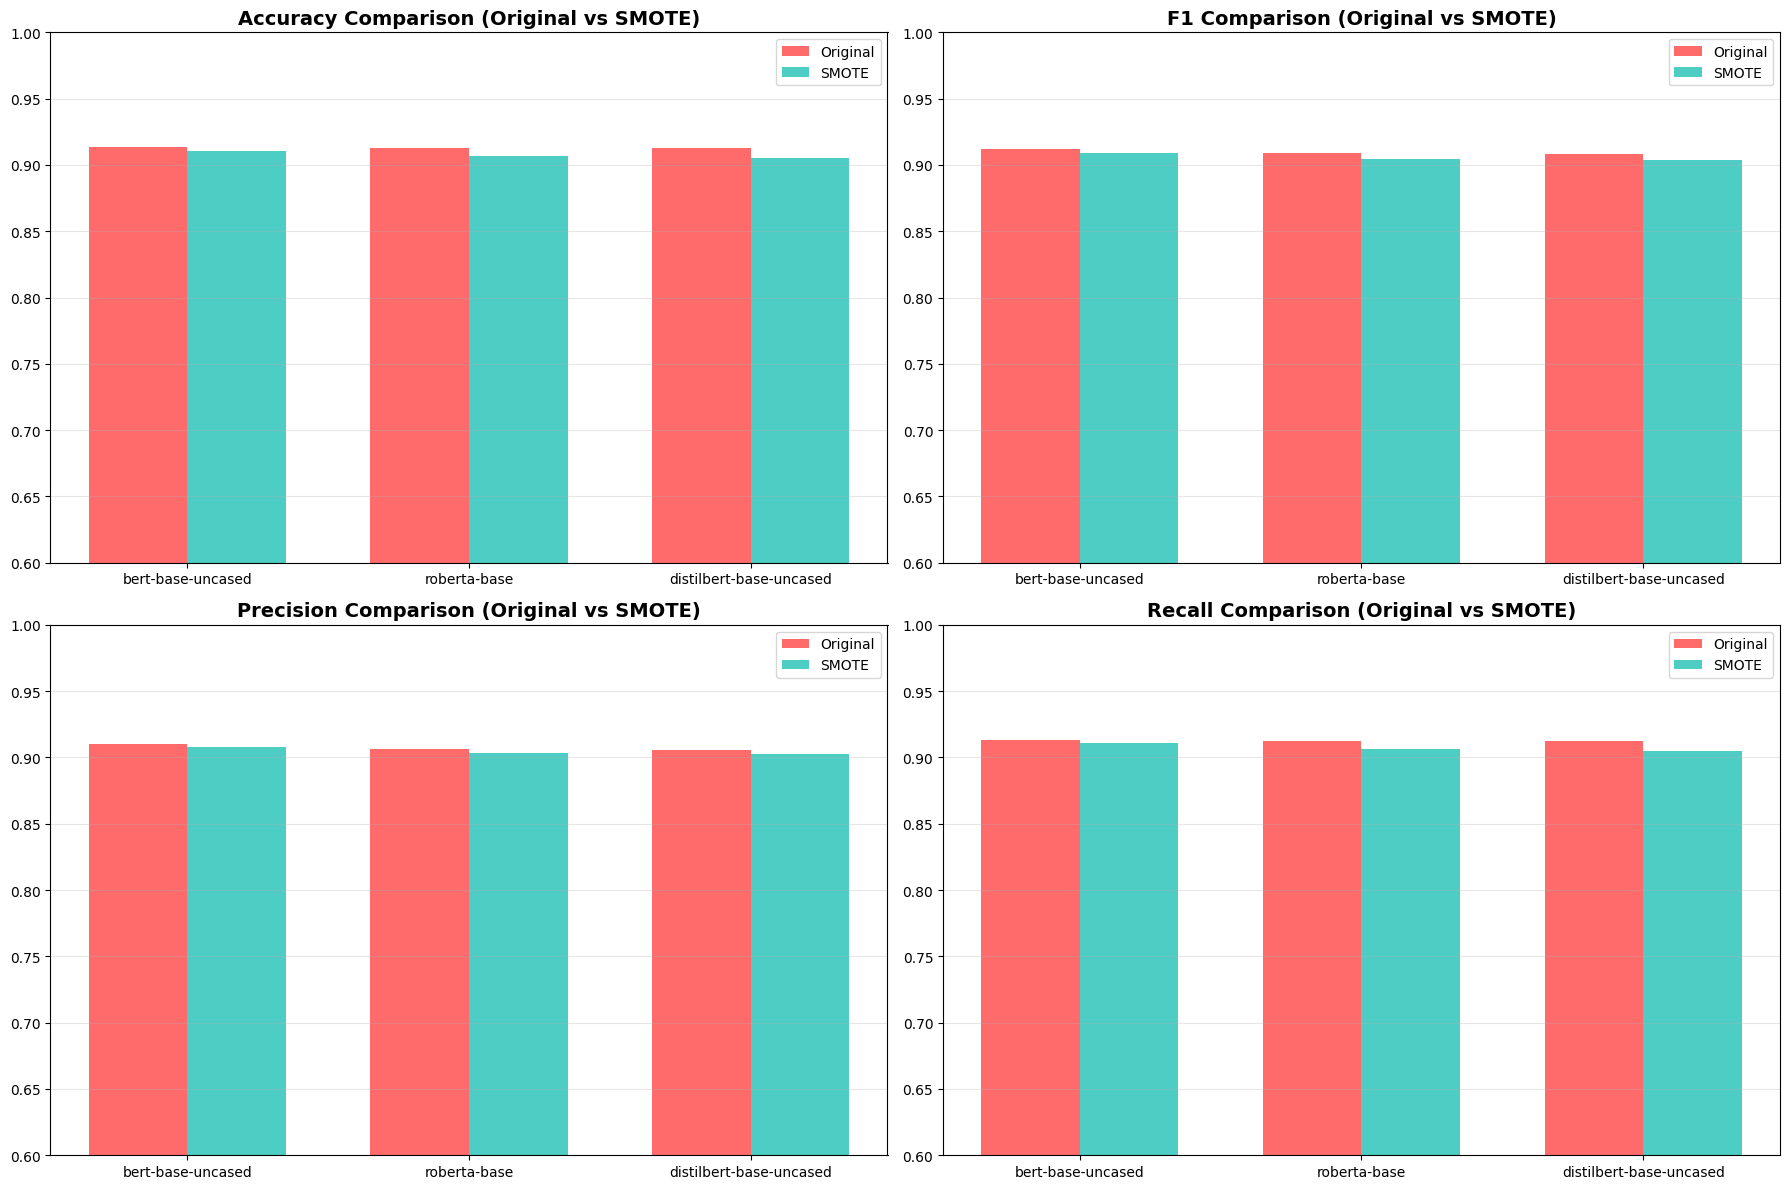


Saved: comparison_original_vs_smote_metrics.png


In [10]:
# ===========================================================
# BAR CHART COMPARISON (Original vs SMOTE)
# ===========================================================

metrics = ["Accuracy", "F1", "Precision", "Recall"]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    orig_values = df_combined[f"{metric}_Original"]
    smo_values  = df_combined[f"{metric}_SMOTE"]

    x = np.arange(len(df_combined["Model"]))
    width = 0.35

    ax.bar(x - width/2, orig_values, width, label="Original", color="#FF6B6B")
    ax.bar(x + width/2, smo_values, width, label="SMOTE", color="#4ECDC4")

    ax.set_title(f"{metric} Comparison (Original vs SMOTE)", fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df_combined["Model"], rotation=0)
    ax.set_ylim([0.6, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig("comparison_original_vs_smote_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: comparison_original_vs_smote_metrics.png")


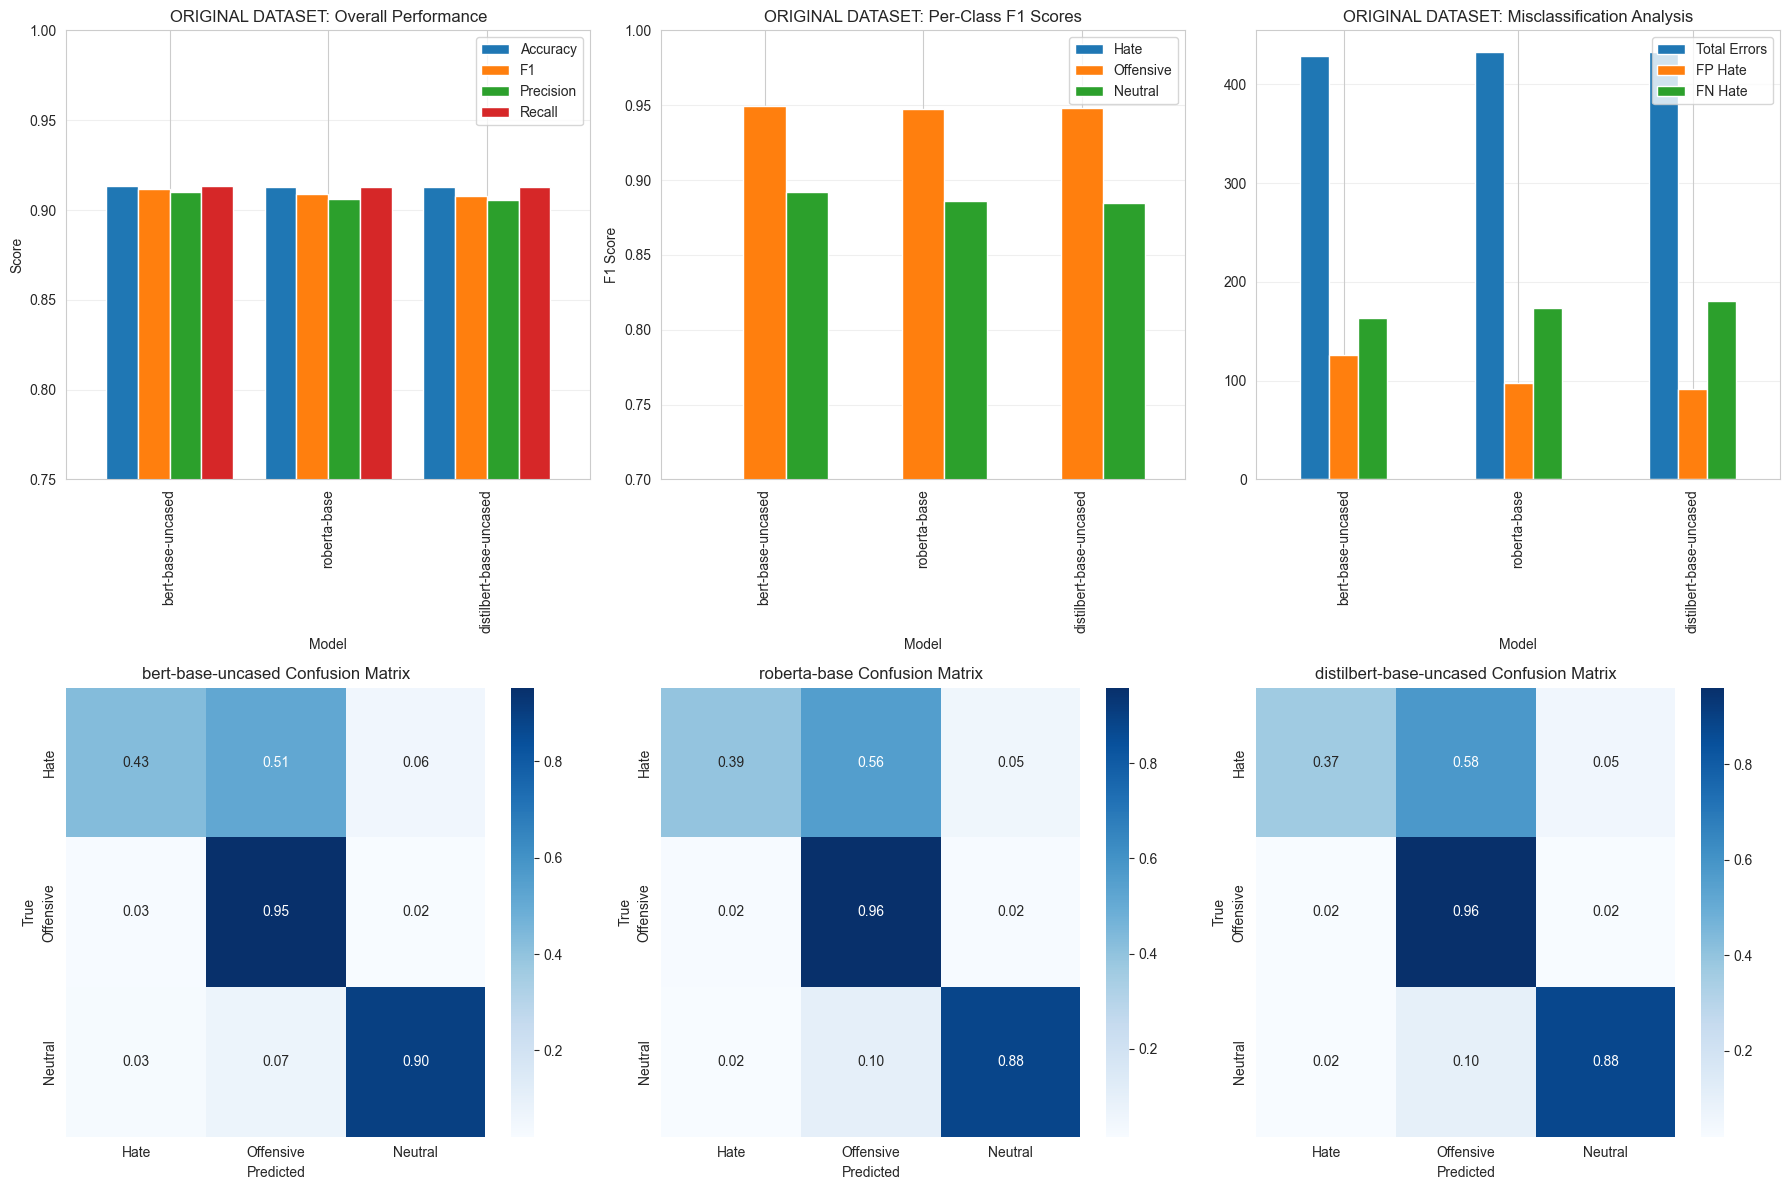


✓ Saved comparison: model_comparison_original.png
                  Model  Accuracy       F1  Precision   Recall  F1_Class_0  F1_Class_1  F1_Class_2
      bert-base-uncased  0.913456 0.911692   0.910212 0.913456    0.459813    0.949623    0.892069
           roberta-base  0.912649 0.908789   0.906367 0.912649    0.451613    0.947816    0.885938
distilbert-base-uncased  0.912649 0.907968   0.905307 0.912649    0.434783    0.948302    0.884592


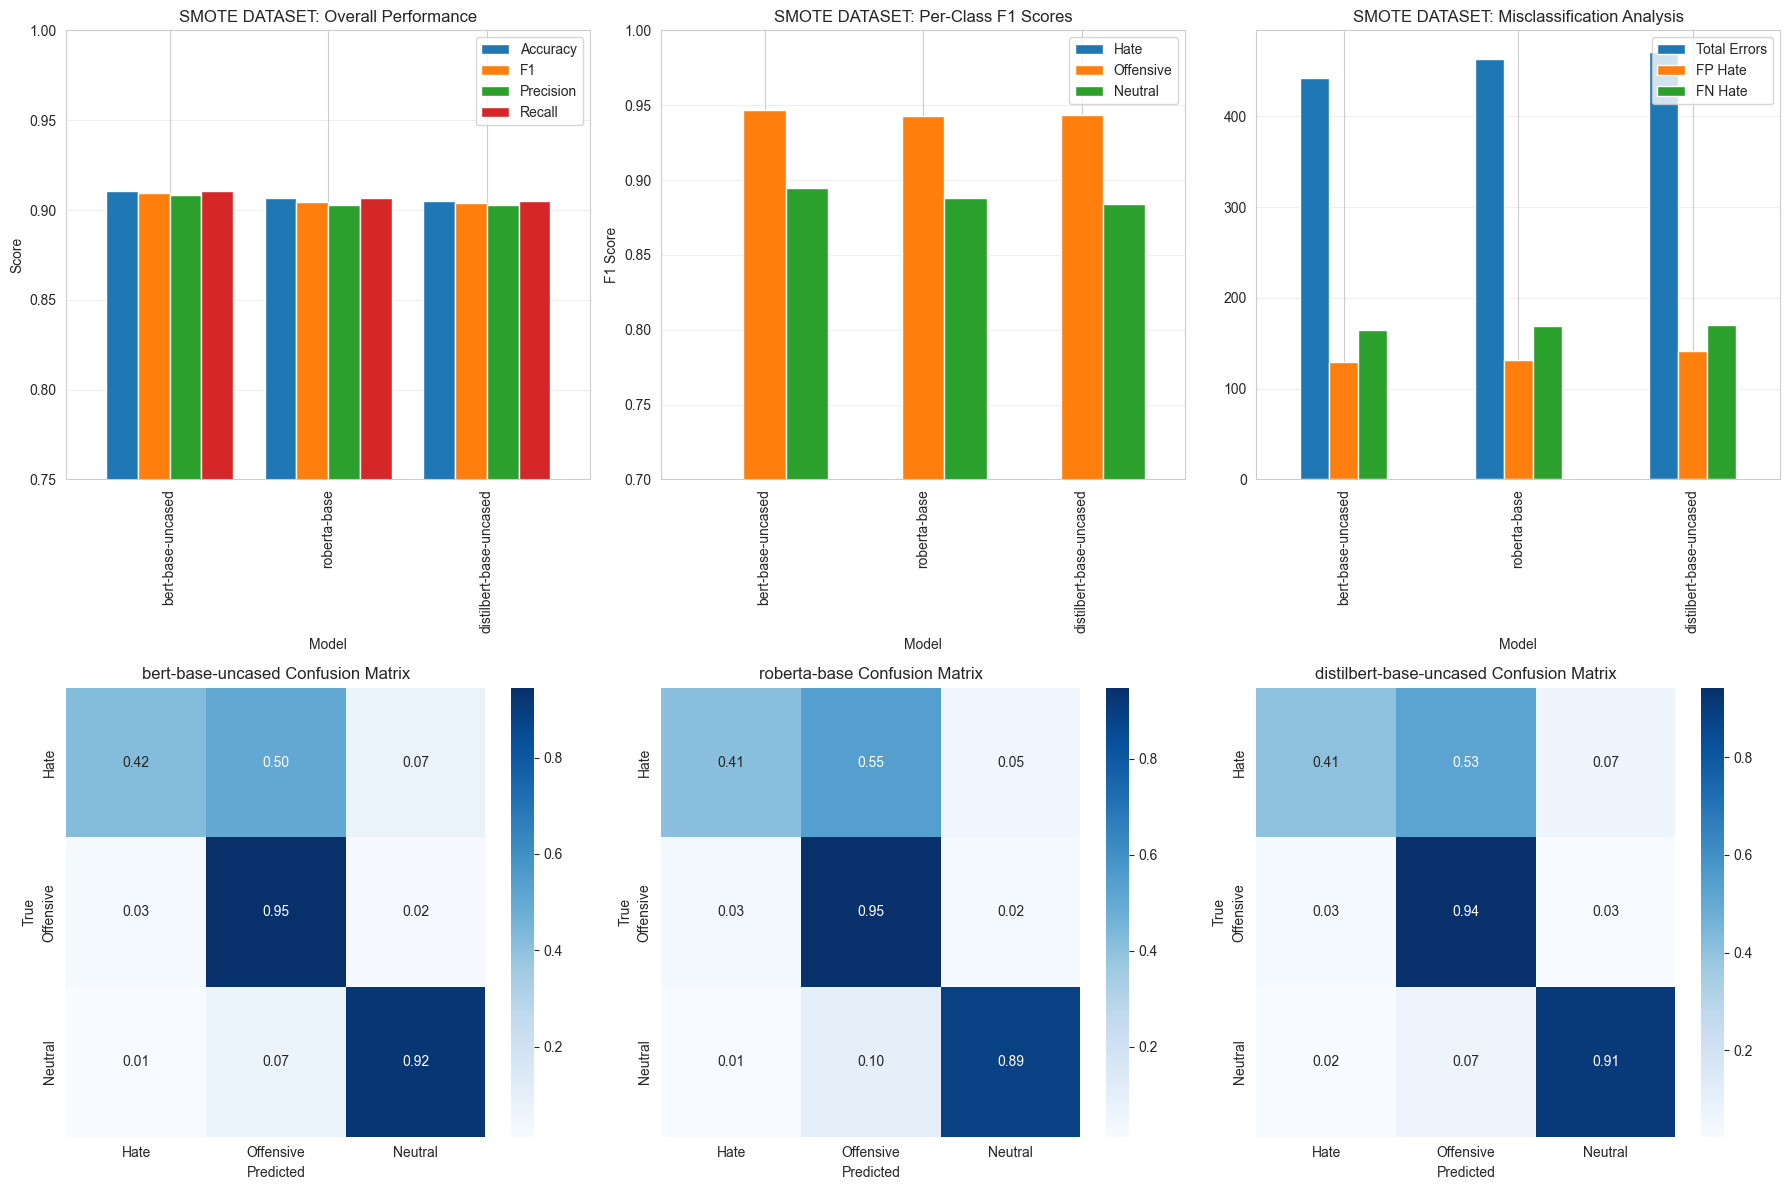


✓ Saved comparison: model_comparison_smote.png
                  Model  Accuracy       F1  Precision   Recall  F1_Class_0  F1_Class_1  F1_Class_2
      bert-base-uncased  0.910833 0.909285   0.908213 0.910833    0.451493    0.946503    0.894982
           roberta-base  0.906597 0.904651   0.903002 0.906597    0.438202    0.942976    0.888221
distilbert-base-uncased  0.904983 0.903713   0.902751 0.904983    0.427256    0.943509    0.883939


In [11]:
# =====================================================================
# FUNCTION TO GENERATE VISUALIZATION BLOCK FOR ANY RESULT DICTIONARY
# =====================================================================

def generate_model_comparison_figure(results_dict, title_prefix, save_name):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd

    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (16, 12)

    # ============================
    # Build comparison dataframe
    # ============================
    comparison_data = []
    for model_name, results in results_dict.items():
        comparison_data.append({
            'Model': model_name.split('/')[-1],
            'Accuracy': results['eval_metrics']['eval_accuracy'],
            'F1': results['eval_metrics']['eval_f1'],
            'Precision': results['eval_metrics']['eval_precision'],
            'Recall': results['eval_metrics']['eval_recall'],
            'F1_Class_0': results['eval_metrics']['eval_f1_class_0'],
            'F1_Class_1': results['eval_metrics']['eval_f1_class_1'],
            'F1_Class_2': results['eval_metrics']['eval_f1_class_2'],
        })

    df_comparison = pd.DataFrame(comparison_data)

    # ============================
    # Create 6-panel plot
    # ============================
    fig = plt.figure(figsize=(18, 12))

    # 1. Overall Metrics
    ax1 = plt.subplot(2, 3, 1)
    df_plot = df_comparison[['Model', 'Accuracy', 'F1', 'Precision', 'Recall']].set_index('Model')
    df_plot.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title(f'{title_prefix}: Overall Performance')
    ax1.set_ylabel('Score')
    ax1.set_ylim([0.75, 1.0])
    ax1.grid(axis='y', alpha=0.3)
    ax1.legend()

    # 2. Per-class F1
    ax2 = plt.subplot(2, 3, 2)
    df_class_f1 = df_comparison[['Model', 'F1_Class_0', 'F1_Class_1', 'F1_Class_2']].set_index('Model')
    df_class_f1.columns = ['Hate', 'Offensive', 'Neutral']
    df_class_f1.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title(f'{title_prefix}: Per-Class F1 Scores')
    ax2.set_ylabel('F1 Score')
    ax2.set_ylim([0.7, 1.0])
    ax2.grid(axis='y', alpha=0.3)

    # 3–5. Confusion Matrices
    positions = [(2, 3, 4), (2, 3, 5), (2, 3, 6)]
    for idx, (model_name, results) in enumerate(results_dict.items()):
        ax = plt.subplot(*positions[idx])
        cm = np.array(results['confusion_matrix'])
        cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        sns.heatmap(
            cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
            xticklabels=['Hate', 'Offensive', 'Neutral'],
            yticklabels=['Hate', 'Offensive', 'Neutral']
        )
        ax.set_title(f'{model_name.split("/")[-1]} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    # 6. Misclassification Bar Plot
    ax6 = plt.subplot(2, 3, 3)
    mis_data = []
    for model_name, results in results_dict.items():
        cm = np.array(results['confusion_matrix'])
        total = cm.sum()
        correct = np.trace(cm)

        fp0 = cm[:, 0].sum() - cm[0, 0]
        fn0 = cm[0, :].sum() - cm[0, 0]

        mis_data.append({
            "Model": model_name.split("/")[-1],
            "Total Errors": total - correct,
            "FP Hate": fp0,
            "FN Hate": fn0
        })

    df_mis = pd.DataFrame(mis_data).set_index('Model')
    df_mis.plot(kind='bar', ax=ax6)
    ax6.set_title(f'{title_prefix}: Misclassification Analysis')
    ax6.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Saved comparison: {save_name}")
    print(df_comparison.to_string(index=False))


# ==============================================================
# GENERATE BOTH FIGURES: ORIGINAL + SMOTE
# ==============================================================

generate_model_comparison_figure(
    results_dict=all_results_original,
    title_prefix="ORIGINAL DATASET",
    save_name="model_comparison_original.png"
)

generate_model_comparison_figure(
    results_dict=all_results_smote,
    title_prefix="SMOTE DATASET",
    save_name="model_comparison_smote.png"
)


### Explainability Integration

In [12]:
# Cell 10: Advanced Explainability Framework
import shap
from lime.lime_text import LimeTextExplainer
from captum.attr import IntegratedGradients, LayerIntegratedGradients
import torch
import numpy as np

class UnifiedExplainer:
    """Unified explainability framework for all models"""
    
    def __init__(self, model, tokenizer, model_name, class_names):
        self.model = model
        self.tokenizer = tokenizer
        self.model_name = model_name
        self.class_names = class_names
        self.device = next(model.parameters()).device
        
        # Initialize explainers
        self.lime_explainer = LimeTextExplainer(class_names=class_names)
        
    def predict_proba(self, texts):
        """Get prediction probabilities for LIME/SHAP"""
        if isinstance(texts, str):
            texts = [texts]
            
        inputs = self.tokenizer(
            texts, 
            return_tensors="pt", 
            truncation=True, 
            padding=True,
            max_length=128
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            
        return probs.cpu().numpy()
    
    def explain_lime(self, text, num_features=10):
        """Generate LIME explanation"""
        exp = self.lime_explainer.explain_instance(
            text,
            self.predict_proba,
            num_features=num_features,
            labels=[0, 1, 2]
        )
        return exp
    
    def explain_shap(self, texts, max_samples=50):
        """Generate SHAP explanation"""
        # Create SHAP explainer
        # Using a subset for efficiency
        if len(texts) > max_samples:
            sample_indices = np.random.choice(len(texts), max_samples, replace=False)
            background_texts = [texts[i] for i in sample_indices]
        else:
            background_texts = texts
            
        explainer = shap.Explainer(self.predict_proba, background_texts)
        shap_values = explainer(texts[:min(10, len(texts))])
        
        return shap_values
    
    def explain_integrated_gradients(self, text, target_class=0):
        """Generate Integrated Gradients explanation"""
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(self.device)
        
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        
        # Get embeddings
        embeddings = self.model.get_input_embeddings()(input_ids)
        baseline = torch.zeros_like(embeddings).to(self.device)
        
        # Define forward function
        def forward_func(inputs_embeds):
            outputs = self.model(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask
            )
            return outputs.logits[:, target_class]
        
        # Compute attributions
        ig = IntegratedGradients(forward_func)
        attributions = ig.attribute(
            embeddings,
            baselines=baseline,
            n_steps=50
        )
        
        # Aggregate over embedding dimensions
        attributions = attributions.sum(dim=-1).squeeze(0)
        attributions = attributions.detach().cpu().numpy()
        
        # Get tokens
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0].cpu())
        
        return tokens, attributions
    
    def get_attention_weights(self, text, layer=-1, head=0):
        """Extract attention weights"""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
            
        attentions = outputs.attentions  # Tuple of attention tensors
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu())
        
        # Get specific layer and head
        attn_weights = attentions[layer][0, head].cpu().numpy()
        
        return tokens, attn_weights
    
    def comprehensive_explain(self, text, target_class=0, save_path=None):
        """Generate all explanations and visualize"""
        print(f"\n{'='*60}")
        print(f"Comprehensive Explanation: {self.model_name}")
        print(f"Text: {text}")
        print(f"Target Class: {self.class_names[target_class]}")
        print(f"{'='*60}")
        
        # Get prediction
        probs = self.predict_proba(text)[0]
        predicted_class = np.argmax(probs)
        
        print(f"\nPrediction: {self.class_names[predicted_class]} ({probs[predicted_class]:.3f})")
        print("Probabilities:")
        for i, (name, prob) in enumerate(zip(self.class_names, probs)):
            print(f"  {name}: {prob:.3f}")
        
        # Create visualization
        fig = plt.figure(figsize=(20, 12))
        
        # 1. LIME Explanation
        print("\nGenerating LIME explanation...")
        lime_exp = self.explain_lime(text)
        
        ax1 = plt.subplot(2, 3, 1)
        lime_weights = dict(lime_exp.as_list(label=target_class))
        words = list(lime_weights.keys())[:10]
        weights = list(lime_weights.values())[:10]
        colors = ['green' if w > 0 else 'red' for w in weights]
        ax1.barh(words, weights, color=colors)
        ax1.set_xlabel('LIME Weight')
        ax1.set_title(f'LIME: {self.class_names[target_class]}', fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
        
        # 2. Integrated Gradients
        print("Generating Integrated Gradients explanation...")
        tokens, ig_attrs = self.explain_integrated_gradients(text, target_class)
        
        # Filter special tokens
        filtered_tokens = []
        filtered_attrs = []
        for tok, attr in zip(tokens, ig_attrs):
            if tok not in ['[CLS]', '[SEP]', '[PAD]', '<s>', '</s>', '<pad>']:
                filtered_tokens.append(tok)
                filtered_attrs.append(attr)
        
        ax2 = plt.subplot(2, 3, 2)
        top_n = min(10, len(filtered_tokens))
        indices = np.argsort(np.abs(filtered_attrs))[-top_n:]
        top_tokens = [filtered_tokens[i] for i in indices]
        top_attrs = [filtered_attrs[i] for i in indices]
        colors = ['green' if a > 0 else 'red' for a in top_attrs]
        ax2.barh(top_tokens, top_attrs, color=colors)
        ax2.set_xlabel('IG Attribution')
        ax2.set_title('Integrated Gradients', fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
        
        # 3. Attention Visualization (multiple heads)
        print("Extracting attention patterns...")
        tokens_attn, attn_weights = self.get_attention_weights(text, layer=-1, head=0)
        
        ax3 = plt.subplot(2, 3, 3)
        # Show attention from [CLS] token
        cls_attention = attn_weights[0, :]
        ax3.barh(range(len(tokens_attn)), cls_attention, color='skyblue')
        ax3.set_yticks(range(len(tokens_attn)))
        ax3.set_yticklabels(tokens_attn, fontsize=8)
        ax3.set_xlabel('Attention Weight')
        ax3.set_title('Attention from [CLS] Token', fontweight='bold')
        
        # 4. Attention Heatmap (token-to-token)
        ax4 = plt.subplot(2, 3, 4)
        sns.heatmap(attn_weights[:15, :15], cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Attention'})
        ax4.set_title('Token-to-Token Attention', fontweight='bold')
        ax4.set_xlabel('Key Tokens')
        ax4.set_ylabel('Query Tokens')
        
        # 5. Prediction Confidence Distribution
        ax5 = plt.subplot(2, 3, 5)
        ax5.bar(self.class_names, probs, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
        ax5.set_ylabel('Probability')
        ax5.set_title('Prediction Confidence', fontweight='bold')
        ax5.set_ylim([0, 1])
        for i, (name, prob) in enumerate(zip(self.class_names, probs)):
            ax5.text(i, prob + 0.02, f'{prob:.3f}', ha='center', fontweight='bold')
        
        # 6. Feature Importance Summary
        ax6 = plt.subplot(2, 3, 6)
        # Combine LIME and IG for consensus view
        lime_dict = dict(lime_exp.as_list(label=target_class))
        ig_dict = {tok: attr for tok, attr in zip(filtered_tokens, filtered_attrs)}
        
        # Find common important tokens
        all_tokens = set(lime_dict.keys()) | set(ig_dict.keys())
        consensus_scores = []
        consensus_tokens = []
        for token in all_tokens:
            lime_score = lime_dict.get(token, 0)
            ig_score = ig_dict.get(token, 0)
            consensus_scores.append((lime_score + ig_score) / 2)
            consensus_tokens.append(token)
        
        # Sort and plot top 10
        sorted_indices = np.argsort(np.abs(consensus_scores))[-10:]
        top_consensus_tokens = [consensus_tokens[i] for i in sorted_indices]
        top_consensus_scores = [consensus_scores[i] for i in sorted_indices]
        colors = ['green' if s > 0 else 'red' for s in top_consensus_scores]
        
        ax6.barh(top_consensus_tokens, top_consensus_scores, color=colors)
        ax6.set_xlabel('Consensus Importance')
        ax6.set_title('LIME + IG Consensus', fontweight='bold')
        ax6.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\n✓ Visualization saved to {save_path}")
        
        plt.show()
        
        return {
            'prediction': predicted_class,
            'probabilities': probs.tolist(),
            'lime_explanation': lime_weights,
            'ig_tokens': filtered_tokens,
            'ig_attributions': filtered_attrs,
            'attention_weights': attn_weights.tolist()
        }

print("✓ UnifiedExplainer class defined")

✓ UnifiedExplainer class defined


In [13]:
# Cell 11: Bias Detection Framework
import re
from collections import defaultdict

class BiasAnalyzer:
    """Analyze model bias across demographic subgroups"""
    
    def __init__(self, model, tokenizer, test_df):
        self.model = model
        self.tokenizer = tokenizer
        self.test_df = test_df
        self.device = next(model.parameters()).device
        
        # Define identity terms for bias detection
        self.identity_terms = {
            'race': ['black', 'white', 'asian', 'hispanic', 'latino', 'african'],
            'religion': ['muslim', 'jewish', 'christian', 'hindu', 'buddhist', 'islam'],
            'gender': ['woman', 'women', 'man', 'men', 'female', 'male', 'girl', 'boy'],
            'sexuality': ['gay', 'lesbian', 'lgbt', 'queer', 'homosexual', 'transgender'],
            'disability': ['disabled', 'disability', 'blind', 'deaf', 'autism', 'autistic']
        }
        
    def contains_identity_term(self, text, category):
        """Check if text contains any identity term from a category"""
        text_lower = text.lower()
        return any(term in text_lower for term in self.identity_terms[category])
    
    def get_predictions(self, texts):
        """Get model predictions for a list of texts"""
        inputs = self.tokenizer(
            texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()
            
        return predictions, probabilities
    
    def analyze_subgroup_performance(self):
        """Analyze performance across demographic subgroups"""
        results = {}
        
        for category, terms in self.identity_terms.items():
            # Filter texts containing identity terms
            mask = self.test_df['text'].apply(lambda x: self.contains_identity_term(x, category))
            subgroup_df = self.test_df[mask]
            
            if len(subgroup_df) == 0:
                continue
                
            # Get predictions
            texts = subgroup_df['text'].tolist()
            true_labels = subgroup_df['labels'].values
            predictions, probabilities = self.get_predictions(texts)
            
            # Calculate metrics
            accuracy = accuracy_score(true_labels, predictions)
            precision, recall, f1, _ = precision_recall_fscore_support(
                true_labels, predictions, average='weighted', zero_division=0
            )
            
            # Per-class metrics
            precision_per_class, recall_per_class, f1_per_class, _ = \
                precision_recall_fscore_support(
                    true_labels, predictions, average=None, zero_division=0, labels=[0, 1, 2]
                )
            
            # Confusion matrix
            cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2])
            
            # False positive rate for hate speech (class 0)
            fp_hate = (predictions == 0).sum() - (predictions[true_labels == 0] == 0).sum()
            total_non_hate = (true_labels != 0).sum()
            fpr_hate = fp_hate / total_non_hate if total_non_hate > 0 else 0
            
            results[category] = {
                'count': len(subgroup_df),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'f1_per_class': f1_per_class.tolist(),
                'fpr_hate_speech': fpr_hate,
                'confusion_matrix': cm.tolist()
            }
            
        return results
    
    def calculate_fairness_gap(self, baseline_f1, subgroup_results):
        """Calculate fairness gap between baseline and subgroups"""
        gaps = {}
        for category, metrics in subgroup_results.items():
            gap = abs(baseline_f1 - metrics['f1'])
            gaps[category] = gap
        return gaps
    
    def generate_bias_report(self, baseline_f1):
        """Generate comprehensive bias report"""
        print("\n" + "="*70)
        print("BIAS ANALYSIS REPORT")
        print("="*70)
        
        subgroup_results = self.analyze_subgroup_performance()
        fairness_gaps = self.calculate_fairness_gap(baseline_f1, subgroup_results)
        
        # Overall statistics
        print(f"\nBaseline F1 Score: {baseline_f1:.4f}")
        print(f"Number of subgroups analyzed: {len(subgroup_results)}")
        
        # Subgroup details
        print("\n--- Subgroup Performance ---")
        for category, metrics in subgroup_results.items():
            print(f"\n{category.upper()} (n={metrics['count']})")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1 Score: {metrics['f1']:.4f}")
            print(f"  Fairness Gap: {fairness_gaps[category]:.4f}")
            print(f"  FPR (Hate Speech): {metrics['fpr_hate_speech']:.4f}")
            print(f"  Per-class F1: {[f'{f:.3f}' for f in metrics['f1_per_class']]}")
        
        # Identify worst bias
        if fairness_gaps:
            worst_category = max(fairness_gaps, key=fairness_gaps.get)
            print(f"\nHighest Fairness Gap: {worst_category} ({fairness_gaps[worst_category]:.4f})")
        
        return subgroup_results, fairness_gaps
    
    def visualize_bias(self, subgroup_results, fairness_gaps, save_path=None):
        """Visualize bias analysis results"""
        fig = plt.figure(figsize=(16, 10))
        
        # 1. Fairness gaps comparison
        ax1 = plt.subplot(2, 3, 1)
        categories = list(fairness_gaps.keys())
        gaps = list(fairness_gaps.values())
        colors = ['red' if g > 0.05 else 'orange' if g > 0.02 else 'green' for g in gaps]
        ax1.barh(categories, gaps, color=colors)
        ax1.set_xlabel('Fairness Gap (|Baseline F1 - Subgroup F1|)')
        ax1.set_title('Fairness Gaps Across Demographics', fontweight='bold')
        ax1.axvline(x=0.05, color='red', linestyle='--', label='High bias threshold')
        ax1.axvline(x=0.02, color='orange', linestyle='--', label='Moderate bias threshold')
        ax1.legend()
        
        # 2. Subgroup F1 scores
        ax2 = plt.subplot(2, 3, 2)
        f1_scores = [metrics['f1'] for metrics in subgroup_results.values()]
        ax2.barh(categories, f1_scores, color='skyblue')
        ax2.set_xlabel('F1 Score')
        ax2.set_title('F1 Scores by Subgroup', fontweight='bold')
        ax2.set_xlim([0, 1])
        
        # 3. False positive rates for hate speech
        ax3 = plt.subplot(2, 3, 3)
        fpr_values = [metrics['fpr_hate_speech'] for metrics in subgroup_results.values()]
        ax3.barh(categories, fpr_values, color='coral')
        ax3.set_xlabel('False Positive Rate (Hate Speech)')
        ax3.set_title('FPR Across Demographics', fontweight='bold')
        
        # 4. Sample sizes
        ax4 = plt.subplot(2, 3, 4)
        counts = [metrics['count'] for metrics in subgroup_results.values()]
        ax4.barh(categories, counts, color='lightgreen')
        ax4.set_xlabel('Sample Count')
        ax4.set_title('Subgroup Sample Sizes', fontweight='bold')
        
        # 5. Per-class F1 comparison
        ax5 = plt.subplot(2, 3, 5)
        class_names = ['Class 0\n(Hate)', 'Class 1\n(Offensive)', 'Class 2\n(Neutral)']
        x = np.arange(len(class_names))
        width = 0.15
        
        for i, (category, metrics) in enumerate(subgroup_results.items()):
            f1_per_class = metrics['f1_per_class']
            ax5.bar(x + i*width, f1_per_class, width, label=category)
        
        ax5.set_xlabel('Class')
        ax5.set_ylabel('F1 Score')
        ax5.set_title('Per-Class Performance by Subgroup', fontweight='bold')
        ax5.set_xticks(x + width * (len(subgroup_results)-1) / 2)
        ax5.set_xticklabels(class_names)
        ax5.legend(loc='lower right', fontsize=8)
        ax5.set_ylim([0, 1])
        
        # 6. Summary statistics table
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('off')
        
        table_data = []
        for category, metrics in subgroup_results.items():
            table_data.append([
                category,
                f"{metrics['count']}",
                f"{metrics['f1']:.3f}",
                f"{fairness_gaps[category]:.3f}",
                f"{metrics['fpr_hate_speech']:.3f}"
            ])
        
        table = ax6.table(
            cellText=table_data,
            colLabels=['Category', 'N', 'F1', 'Gap', 'FPR'],
            cellLoc='center',
            loc='center',
            colWidths=[0.25, 0.15, 0.15, 0.15, 0.15]
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        ax6.set_title('Summary Statistics', fontweight='bold', pad=20)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\n✓ Bias visualization saved to {save_path}")
        
        plt.show()

print("✓ BiasAnalyzer class defined")

✓ BiasAnalyzer class defined



BIAS ANALYSIS — ORIGINAL DATASET

Bias Analysis (Original): bert-base-uncased

BIAS ANALYSIS REPORT

Baseline F1 Score: 0.9117
Number of subgroups analyzed: 5

--- Subgroup Performance ---

RACE (n=145)
  Accuracy: 0.7241
  F1 Score: 0.7351
  Fairness Gap: 0.1766
  FPR (Hate Speech): 0.2301
  Per-class F1: ['0.568', '0.825', '0.653']

RELIGION (n=8)
  Accuracy: 1.0000
  F1 Score: 1.0000
  Fairness Gap: 0.0883
  FPR (Hate Speech): 0.0000
  Per-class F1: ['1.000', '1.000', '1.000']

GENDER (n=506)
  Accuracy: 0.8893
  F1 Score: 0.8862
  Fairness Gap: 0.0255
  FPR (Hate Speech): 0.0255
  Per-class F1: ['0.484', '0.934', '0.840']

SEXUALITY (n=52)
  Accuracy: 0.6154
  F1 Score: 0.6448
  Fairness Gap: 0.2669
  FPR (Hate Speech): 0.4048
  Per-class F1: ['0.412', '0.735', '0.000']

DISABILITY (n=4)
  Accuracy: 0.7500
  F1 Score: 0.7667
  Fairness Gap: 0.1450
  FPR (Hate Speech): 0.0000
  Per-class F1: ['0.000', '0.800', '0.667']

Highest Fairness Gap: sexuality (0.2669)

✓ Bias visualization

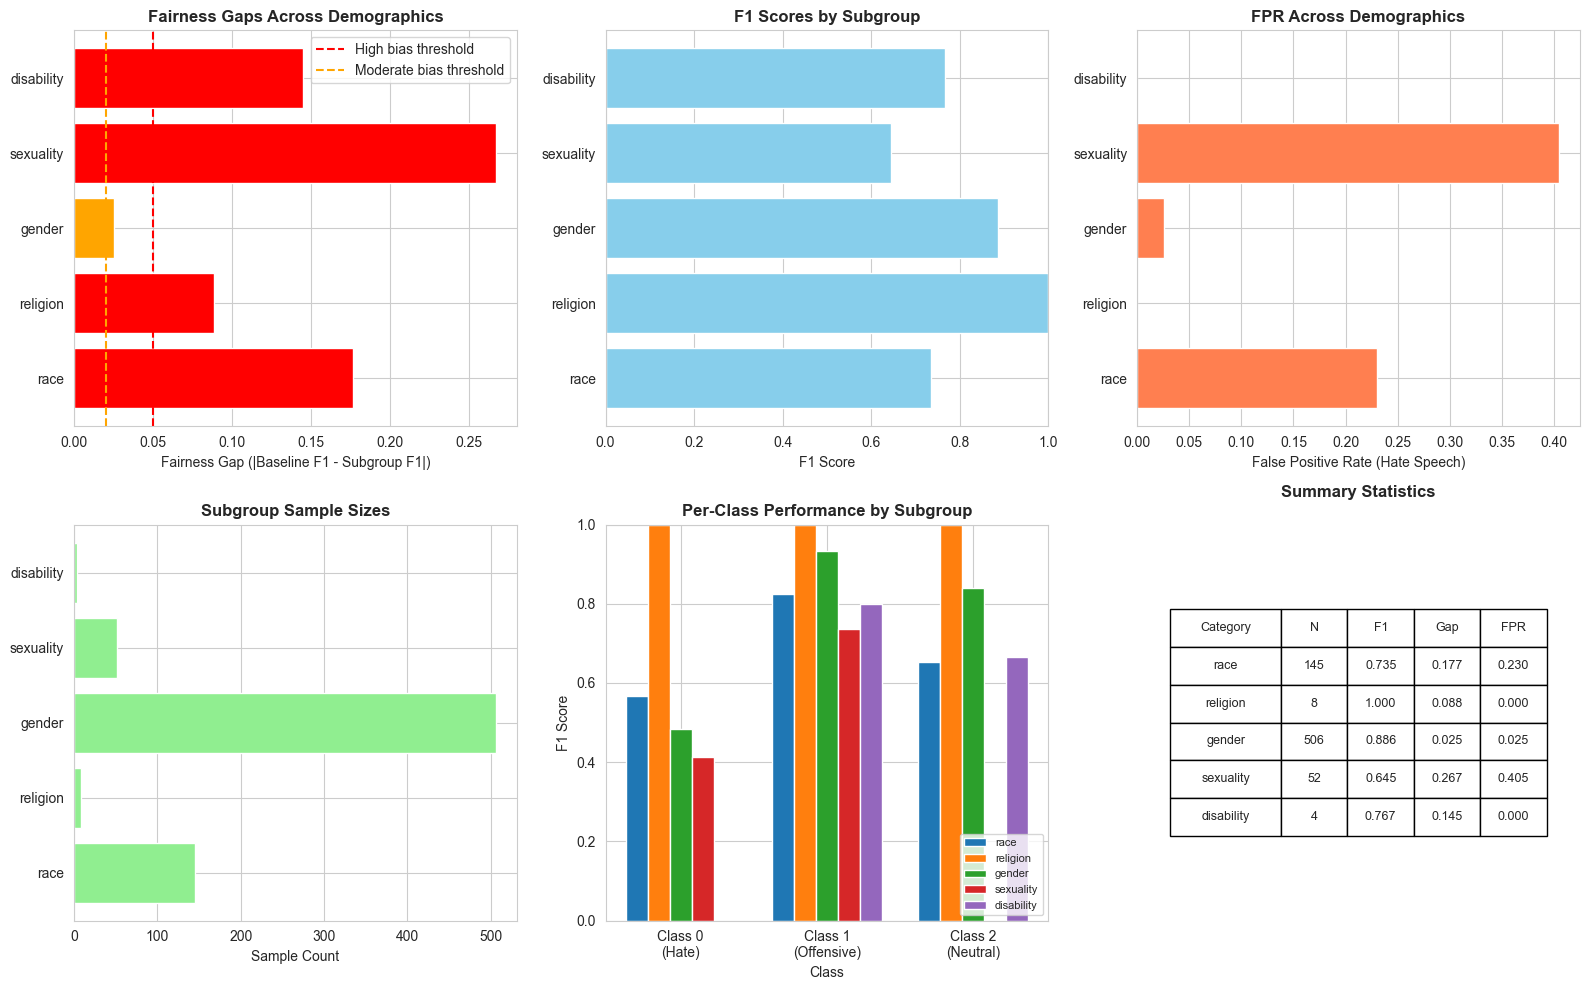


Bias Analysis (Original): roberta-base

BIAS ANALYSIS REPORT

Baseline F1 Score: 0.9088
Number of subgroups analyzed: 5

--- Subgroup Performance ---

RACE (n=145)
  Accuracy: 0.7034
  F1 Score: 0.7111
  Fairness Gap: 0.1976
  FPR (Hate Speech): 0.1947
  Per-class F1: ['0.500', '0.775', '0.759']

RELIGION (n=8)
  Accuracy: 1.0000
  F1 Score: 1.0000
  Fairness Gap: 0.0912
  FPR (Hate Speech): 0.0000
  Per-class F1: ['1.000', '1.000', '1.000']

GENDER (n=506)
  Accuracy: 0.8755
  F1 Score: 0.8668
  Fairness Gap: 0.0420
  FPR (Hate Speech): 0.0212
  Per-class F1: ['0.364', '0.921', '0.830']

SEXUALITY (n=52)
  Accuracy: 0.7115
  F1 Score: 0.7037
  Fairness Gap: 0.2051
  FPR (Hate Speech): 0.1429
  Per-class F1: ['0.400', '0.815', '0.000']

DISABILITY (n=4)
  Accuracy: 0.7500
  F1 Score: 0.7667
  Fairness Gap: 0.1421
  FPR (Hate Speech): 0.0000
  Per-class F1: ['0.000', '0.800', '0.667']

Highest Fairness Gap: sexuality (0.2051)

✓ Bias visualization saved to bias_original_roberta-base.pn

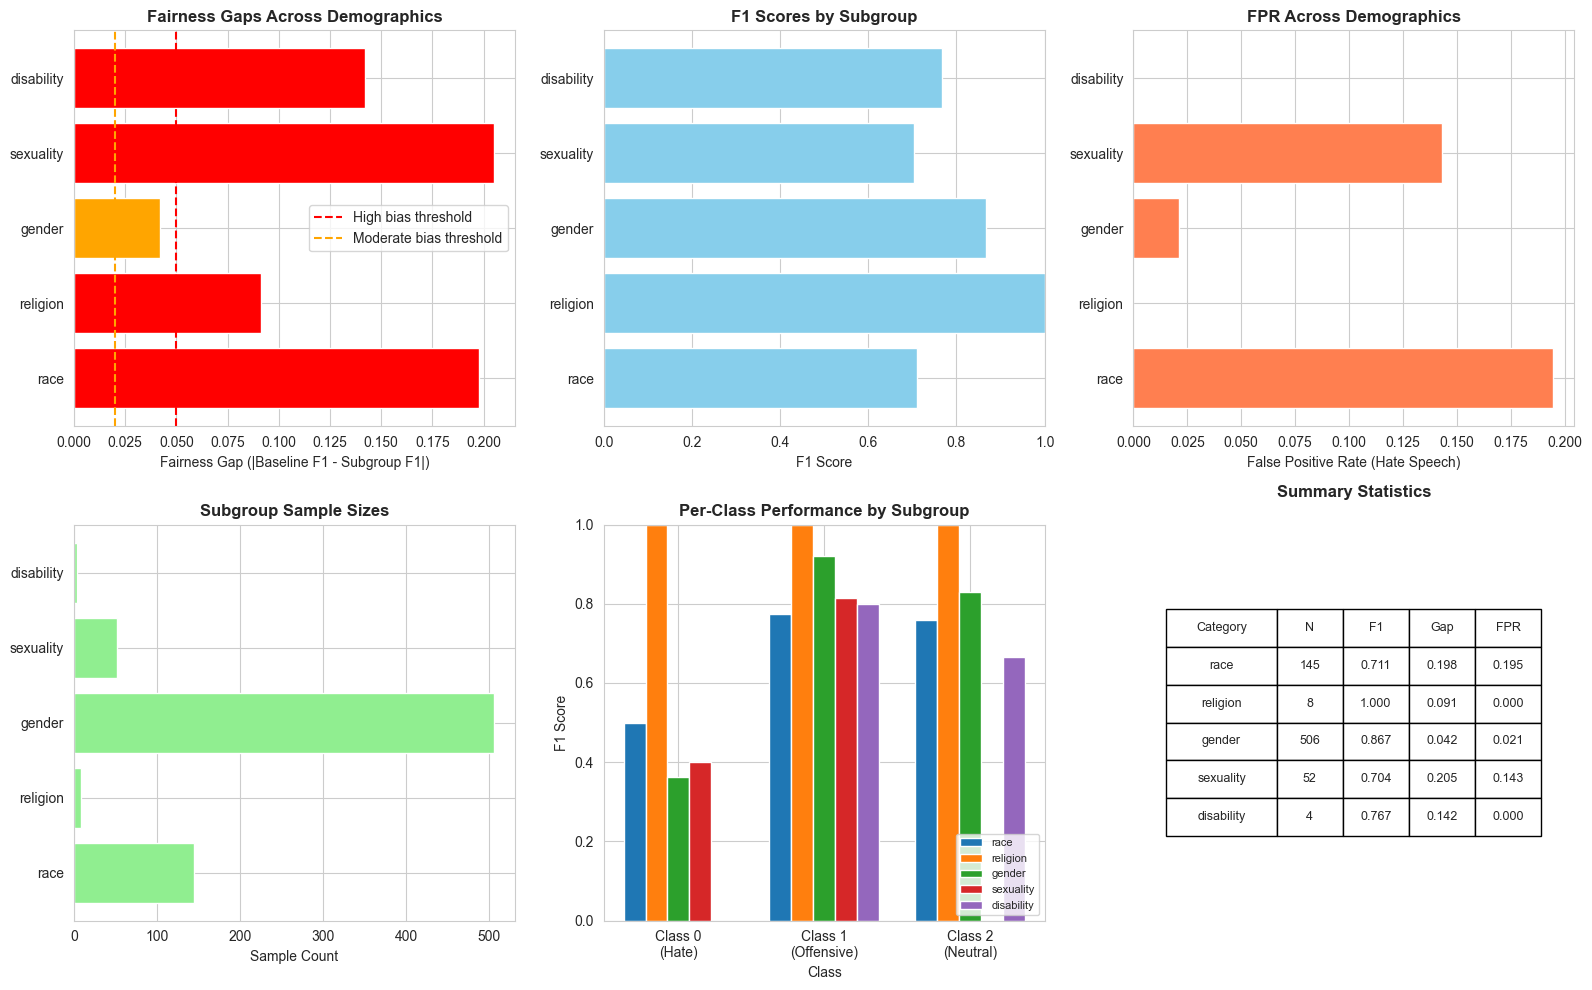


Bias Analysis (Original): distilbert-base-uncased

BIAS ANALYSIS REPORT

Baseline F1 Score: 0.9080
Number of subgroups analyzed: 5

--- Subgroup Performance ---

RACE (n=145)
  Accuracy: 0.7103
  F1 Score: 0.7220
  Fairness Gap: 0.1860
  FPR (Hate Speech): 0.2212
  Per-class F1: ['0.519', '0.783', '0.769']

RELIGION (n=8)
  Accuracy: 1.0000
  F1 Score: 1.0000
  Fairness Gap: 0.0920
  FPR (Hate Speech): 0.0000
  Per-class F1: ['1.000', '1.000', '1.000']

GENDER (n=506)
  Accuracy: 0.8913
  F1 Score: 0.8833
  Fairness Gap: 0.0246
  FPR (Hate Speech): 0.0127
  Per-class F1: ['0.453', '0.934', '0.836']

SEXUALITY (n=52)
  Accuracy: 0.7500
  F1 Score: 0.7658
  Fairness Gap: 0.1422
  FPR (Hate Speech): 0.1429
  Per-class F1: ['0.609', '0.827', '0.333']

DISABILITY (n=4)
  Accuracy: 0.7500
  F1 Score: 0.7667
  Fairness Gap: 0.1413
  FPR (Hate Speech): 0.0000
  Per-class F1: ['0.000', '0.800', '0.667']

Highest Fairness Gap: race (0.1860)

✓ Bias visualization saved to bias_original_distilber

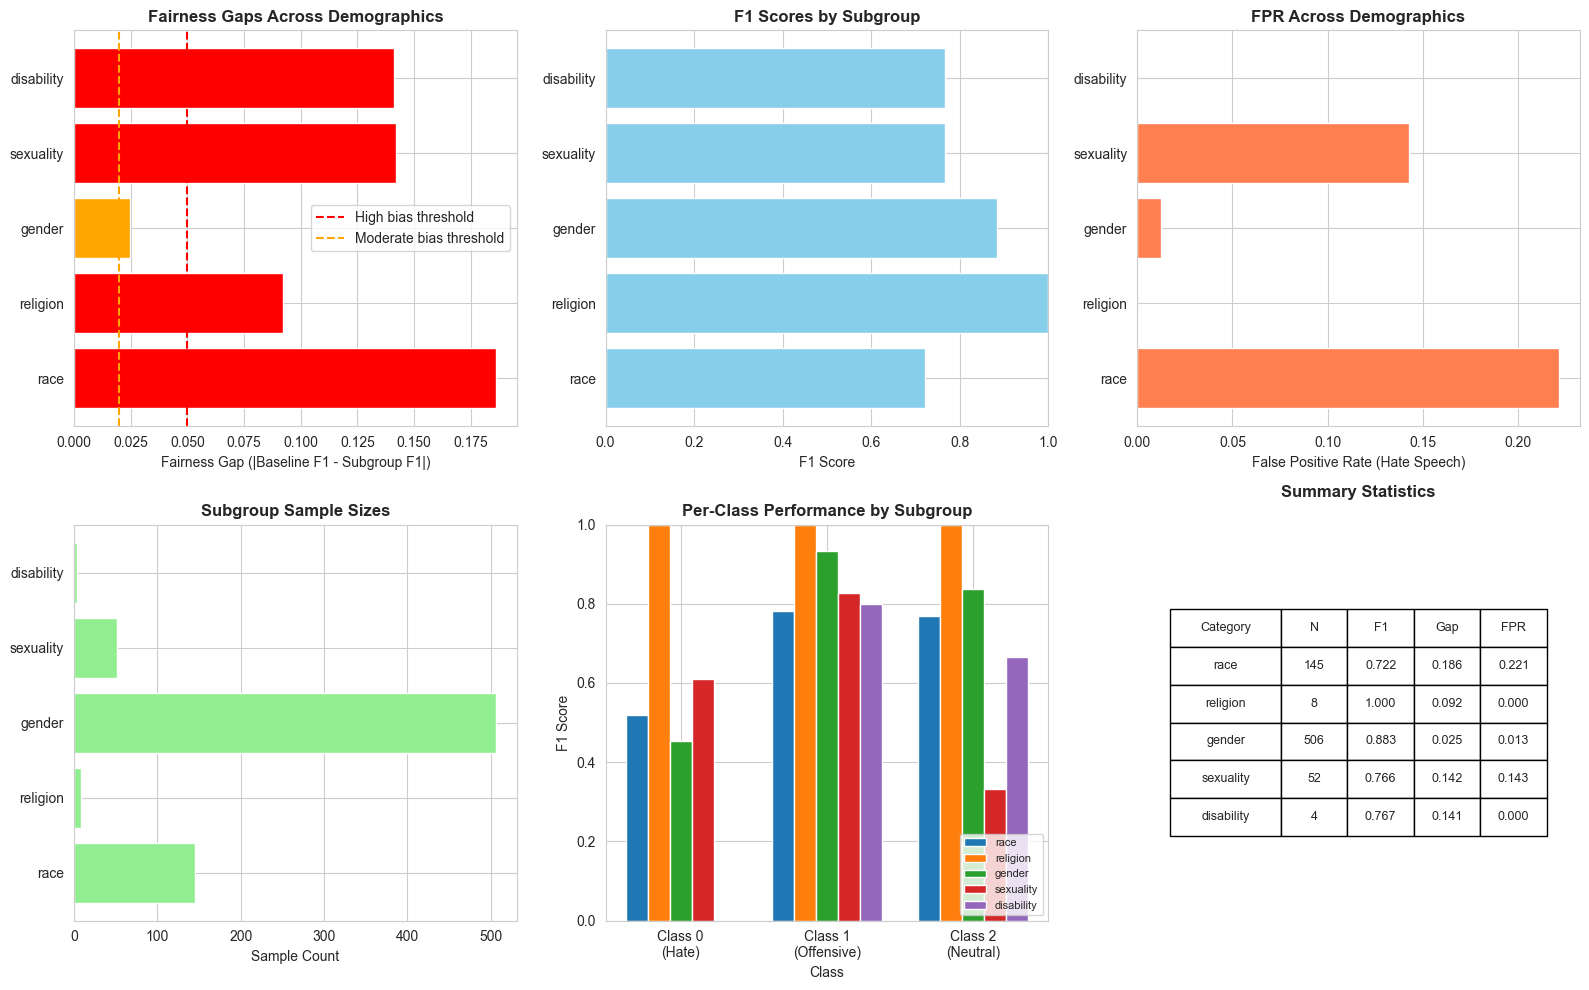


BIAS ANALYSIS — SMOTE DATASET

Bias Analysis (SMOTE): bert-base-uncased

BIAS ANALYSIS REPORT

Baseline F1 Score: 0.9093
Number of subgroups analyzed: 5

--- Subgroup Performance ---

RACE (n=145)
  Accuracy: 0.7172
  F1 Score: 0.7282
  Fairness Gap: 0.1811
  FPR (Hate Speech): 0.2124
  Per-class F1: ['0.564', '0.787', '0.737']

RELIGION (n=8)
  Accuracy: 1.0000
  F1 Score: 1.0000
  Fairness Gap: 0.0907
  FPR (Hate Speech): 0.0000
  Per-class F1: ['1.000', '1.000', '1.000']

GENDER (n=506)
  Accuracy: 0.8953
  F1 Score: 0.8926
  Fairness Gap: 0.0167
  FPR (Hate Speech): 0.0276
  Per-class F1: ['0.476', '0.937', '0.863']

SEXUALITY (n=52)
  Accuracy: 0.7500
  F1 Score: 0.7702
  Fairness Gap: 0.1391
  FPR (Hate Speech): 0.1190
  Per-class F1: ['0.636', '0.842', '0.000']

DISABILITY (n=4)
  Accuracy: 0.7500
  F1 Score: 0.7667
  Fairness Gap: 0.1426
  FPR (Hate Speech): 0.0000
  Per-class F1: ['0.000', '0.800', '0.667']

Highest Fairness Gap: race (0.1811)

✓ Bias visualization saved to b

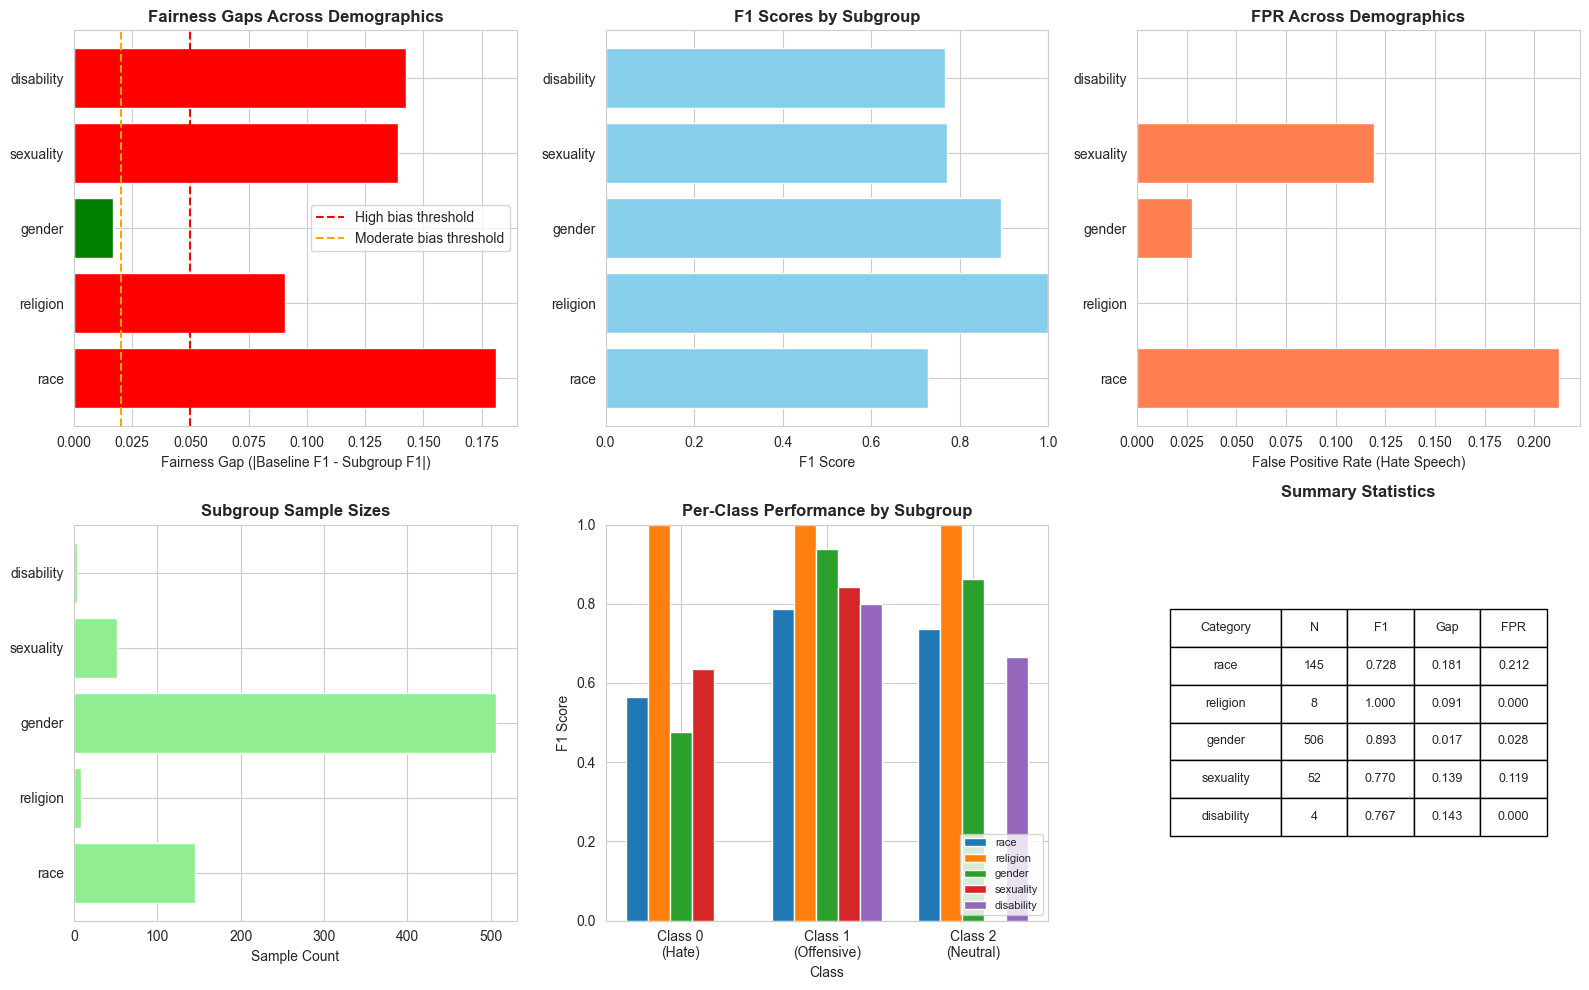


Bias Analysis (SMOTE): roberta-base

BIAS ANALYSIS REPORT

Baseline F1 Score: 0.9047
Number of subgroups analyzed: 5

--- Subgroup Performance ---

RACE (n=145)
  Accuracy: 0.6966
  F1 Score: 0.7031
  Fairness Gap: 0.2015
  FPR (Hate Speech): 0.1947
  Per-class F1: ['0.479', '0.778', '0.731']

RELIGION (n=8)
  Accuracy: 1.0000
  F1 Score: 1.0000
  Fairness Gap: 0.0953
  FPR (Hate Speech): 0.0000
  Per-class F1: ['1.000', '1.000', '1.000']

GENDER (n=506)
  Accuracy: 0.8814
  F1 Score: 0.8721
  Fairness Gap: 0.0325
  FPR (Hate Speech): 0.0212
  Per-class F1: ['0.333', '0.927', '0.847']

SEXUALITY (n=52)
  Accuracy: 0.7308
  F1 Score: 0.7352
  Fairness Gap: 0.1694
  FPR (Hate Speech): 0.1905
  Per-class F1: ['0.560', '0.816', '0.000']

DISABILITY (n=4)
  Accuracy: 1.0000
  F1 Score: 1.0000
  Fairness Gap: 0.0953
  FPR (Hate Speech): 0.0000
  Per-class F1: ['0.000', '1.000', '1.000']

Highest Fairness Gap: race (0.2015)

✓ Bias visualization saved to bias_smote_roberta-base.png


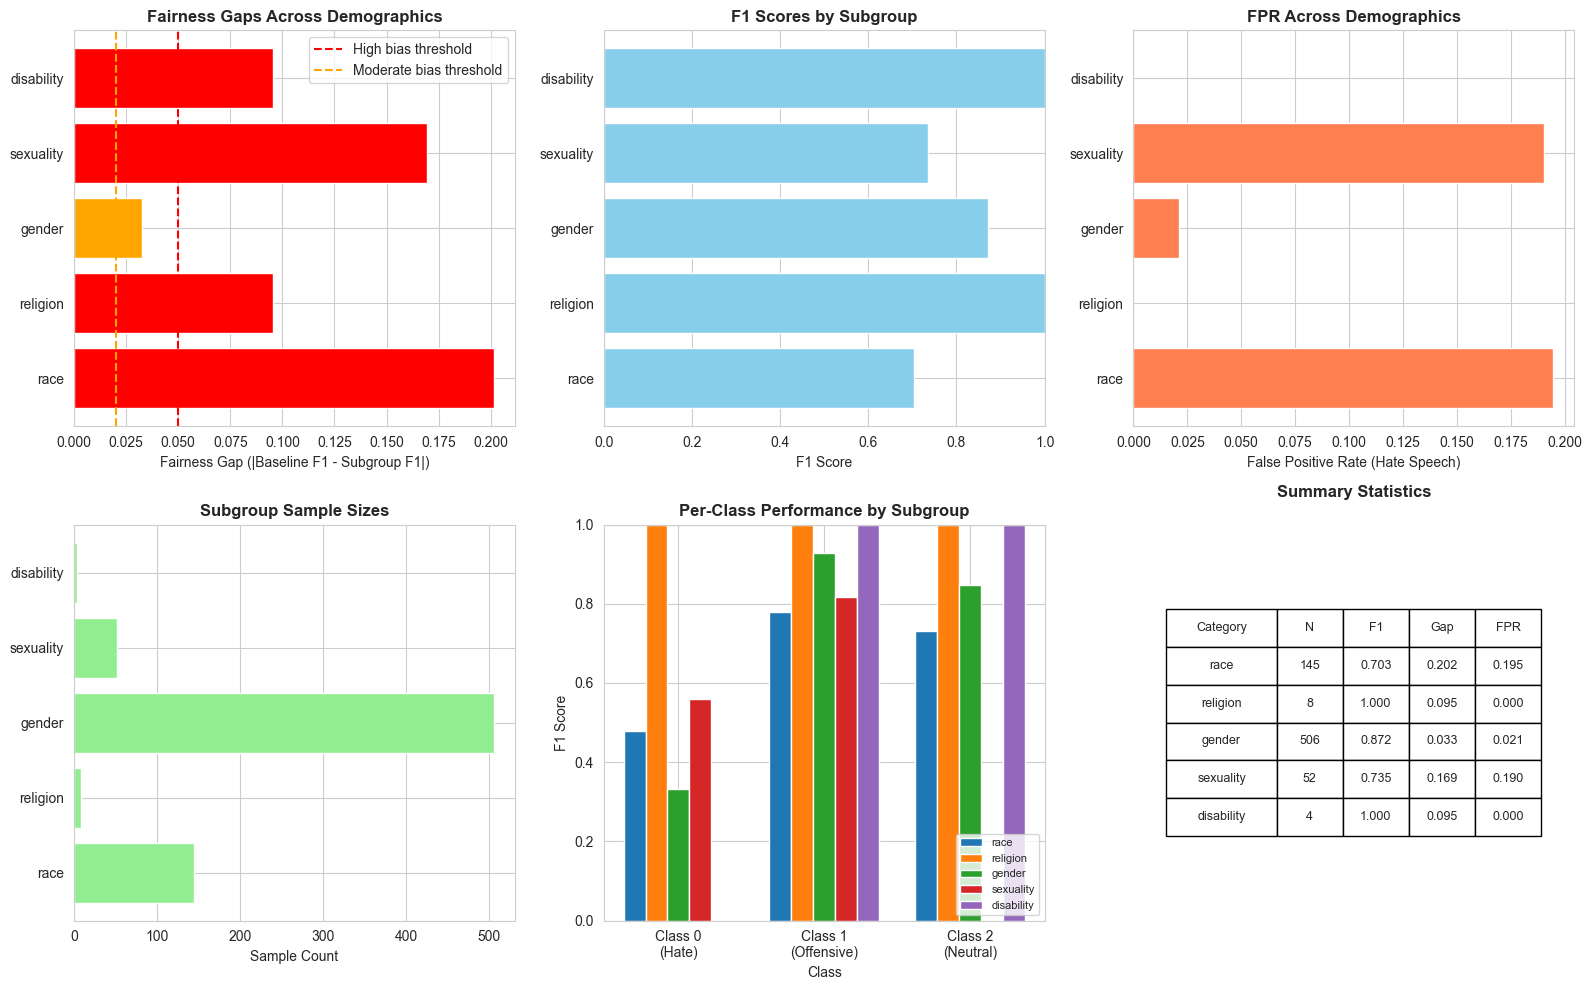


Bias Analysis (SMOTE): distilbert-base-uncased

BIAS ANALYSIS REPORT

Baseline F1 Score: 0.9037
Number of subgroups analyzed: 5

--- Subgroup Performance ---

RACE (n=145)
  Accuracy: 0.7172
  F1 Score: 0.7228
  Fairness Gap: 0.1809
  FPR (Hate Speech): 0.1681
  Per-class F1: ['0.543', '0.790', '0.724']

RELIGION (n=8)
  Accuracy: 0.8750
  F1 Score: 0.8214
  Fairness Gap: 0.0823
  FPR (Hate Speech): 0.2000
  Per-class F1: ['0.857', '0.000', '1.000']

GENDER (n=506)
  Accuracy: 0.8814
  F1 Score: 0.8786
  Fairness Gap: 0.0251
  FPR (Hate Speech): 0.0318
  Per-class F1: ['0.413', '0.927', '0.856']

SEXUALITY (n=52)
  Accuracy: 0.6731
  F1 Score: 0.7107
  Fairness Gap: 0.1931
  FPR (Hate Speech): 0.2381
  Per-class F1: ['0.621', '0.758', '0.222']

DISABILITY (n=4)
  Accuracy: 0.7500
  F1 Score: 0.7667
  Fairness Gap: 0.1370
  FPR (Hate Speech): 0.0000
  Per-class F1: ['0.000', '0.800', '0.667']

Highest Fairness Gap: sexuality (0.1931)

✓ Bias visualization saved to bias_smote_distilbert

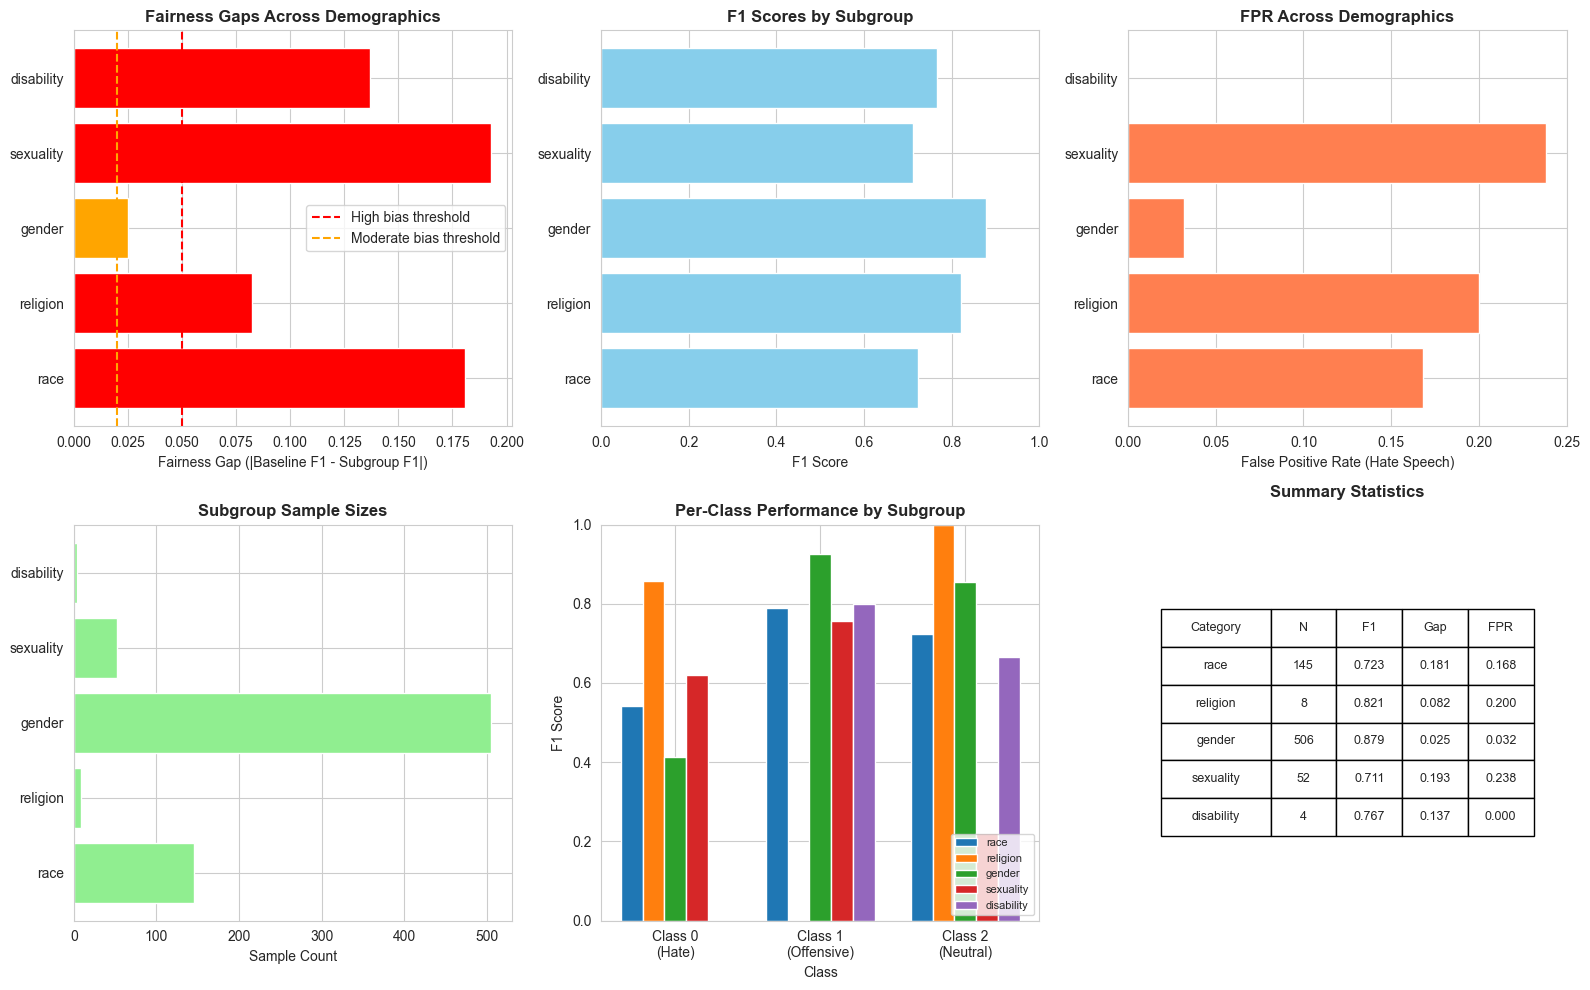


✓ Bias analysis complete for ORIGINAL and SMOTE datasets


In [14]:
# ============================================================
# Cell 12: Execute Bias Analysis for ORIGINAL + SMOTE
# ============================================================

bias_results_original = {}
bias_results_smote = {}

# -------------------------------
# 1. ORIGINAL DATASET BIAS ANALYSIS
# -------------------------------
print("\n" + "="*80)
print("BIAS ANALYSIS — ORIGINAL DATASET")
print("="*80)

for model_name, model_data in trained_models_original.items():
    print(f"\n{'='*70}")
    print(f"Bias Analysis (Original): {model_name}")
    print(f"{'='*70}")

    baseline_f1 = all_results_original[model_name]['eval_metrics']['eval_f1']

    analyzer = BiasAnalyzer(
        model=model_data['model'],
        tokenizer=model_data['tokenizer'],
        test_df=model_data['test_df']    # ORIGINAL TEST SET
    )

    subgroup_results, fairness_gaps = analyzer.generate_bias_report(baseline_f1)

    analyzer.visualize_bias(
        subgroup_results,
        fairness_gaps,
        save_path=f'bias_original_{model_name.replace("/", "_")}.png'
    )

    bias_results_original[model_name] = {
        'baseline_f1': baseline_f1,
        'subgroup_results': subgroup_results,
        'fairness_gaps': fairness_gaps
    }


# -------------------------------
# 2. SMOTE DATASET BIAS ANALYSIS
# -------------------------------
print("\n" + "="*80)
print("BIAS ANALYSIS — SMOTE DATASET")
print("="*80)

for model_name, model_data in trained_models_smote.items():
    print(f"\n{'='*70}")
    print(f"Bias Analysis (SMOTE): {model_name}")
    print(f"{'='*70}")

    baseline_f1 = all_results_smote[model_name]['eval_metrics']['eval_f1']

    analyzer = BiasAnalyzer(
        model=model_data['model'],
        tokenizer=model_data['tokenizer'],
        test_df=model_data['test_df']    # SMOTE TEST SET
    )

    subgroup_results, fairness_gaps = analyzer.generate_bias_report(baseline_f1)

    analyzer.visualize_bias(
        subgroup_results,
        fairness_gaps,
        save_path=f'bias_smote_{model_name.replace("/", "_")}.png'
    )

    bias_results_smote[model_name] = {
        'baseline_f1': baseline_f1,
        'subgroup_results': subgroup_results,
        'fairness_gaps': fairness_gaps
    }

print("\n✓ Bias analysis complete for ORIGINAL and SMOTE datasets")



ERROR + EXPLAINABILITY ANALYSIS — ORIGINAL DATASET
Best Original Model: bert-base-uncased

Misclassification Analysis: bert-base-uncased

Total misclassifications: 429 / 4957
Error rate: 8.65%

--- Error Type Distribution ---
0→1: 147
1→0: 101
1→2: 80
2→1: 60
2→0: 25
0→2: 16

--- Error Case 1 ---
Text: rt alls niggers wanna do is fuck tweet and drink pineapple soda all day ...
True: Hate Speech | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: rt alls niggers wanna do is fuck tweet and drink pineapple soda all day
Target Class: Offensive

Prediction: Offensive (0.501)
Probabilities:
  Hate Speech: 0.488
  Offensive: 0.501
  Neutral: 0.011

Generating LIME explanation...
Generating Integrated Gradients explanation...


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_0.png


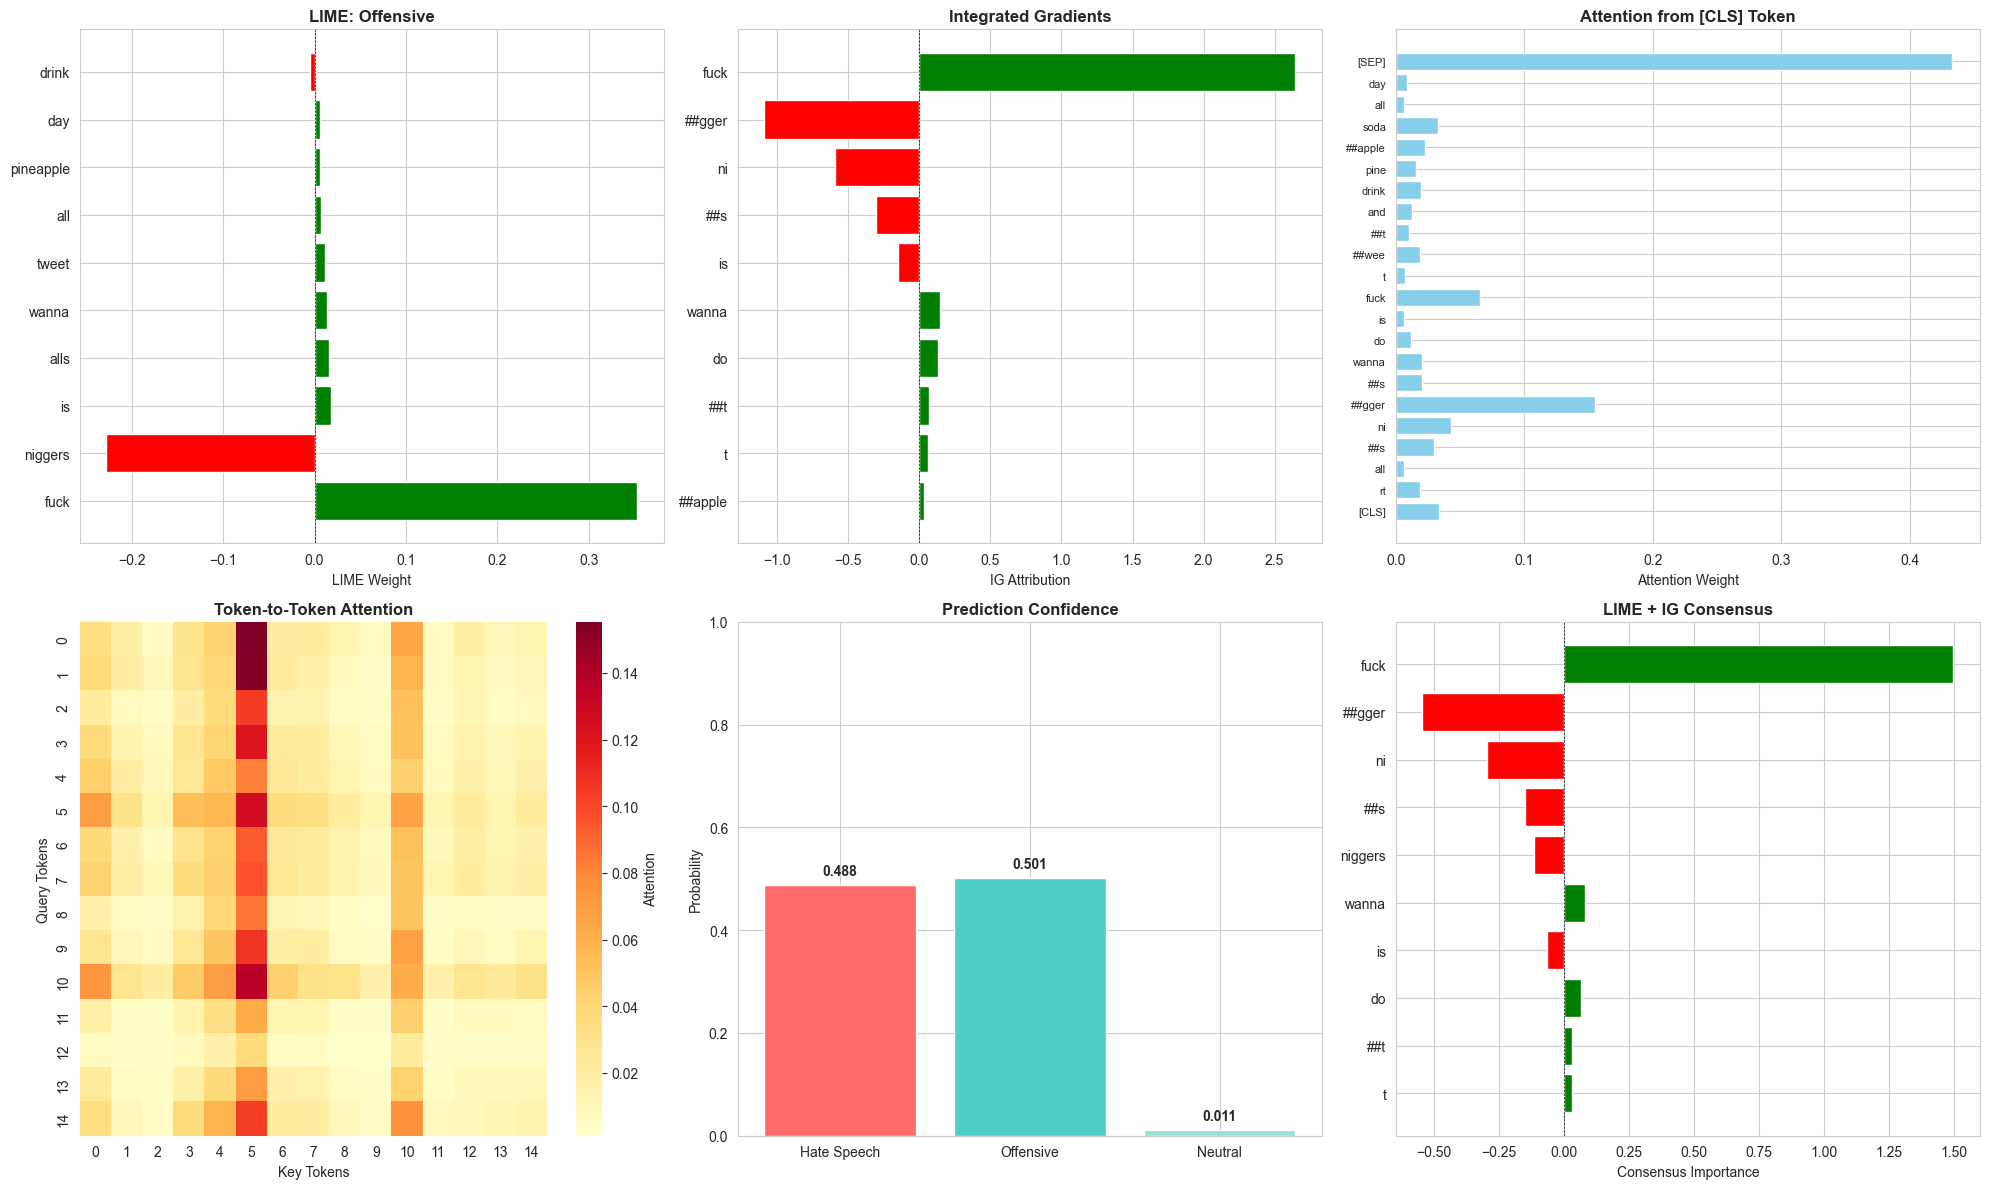


--- Error Case 2 ---
Text: rt no mom im not dramatic immature i just have fucking mental problems and youre a bitch and a cunt ...
True: Hate Speech | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: rt no mom im not dramatic immature i just have fucking mental problems and youre a bitch and a cunt
Target Class: Offensive

Prediction: Offensive (0.986)
Probabilities:
  Hate Speech: 0.013
  Offensive: 0.986
  Neutral: 0.001

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_1.png


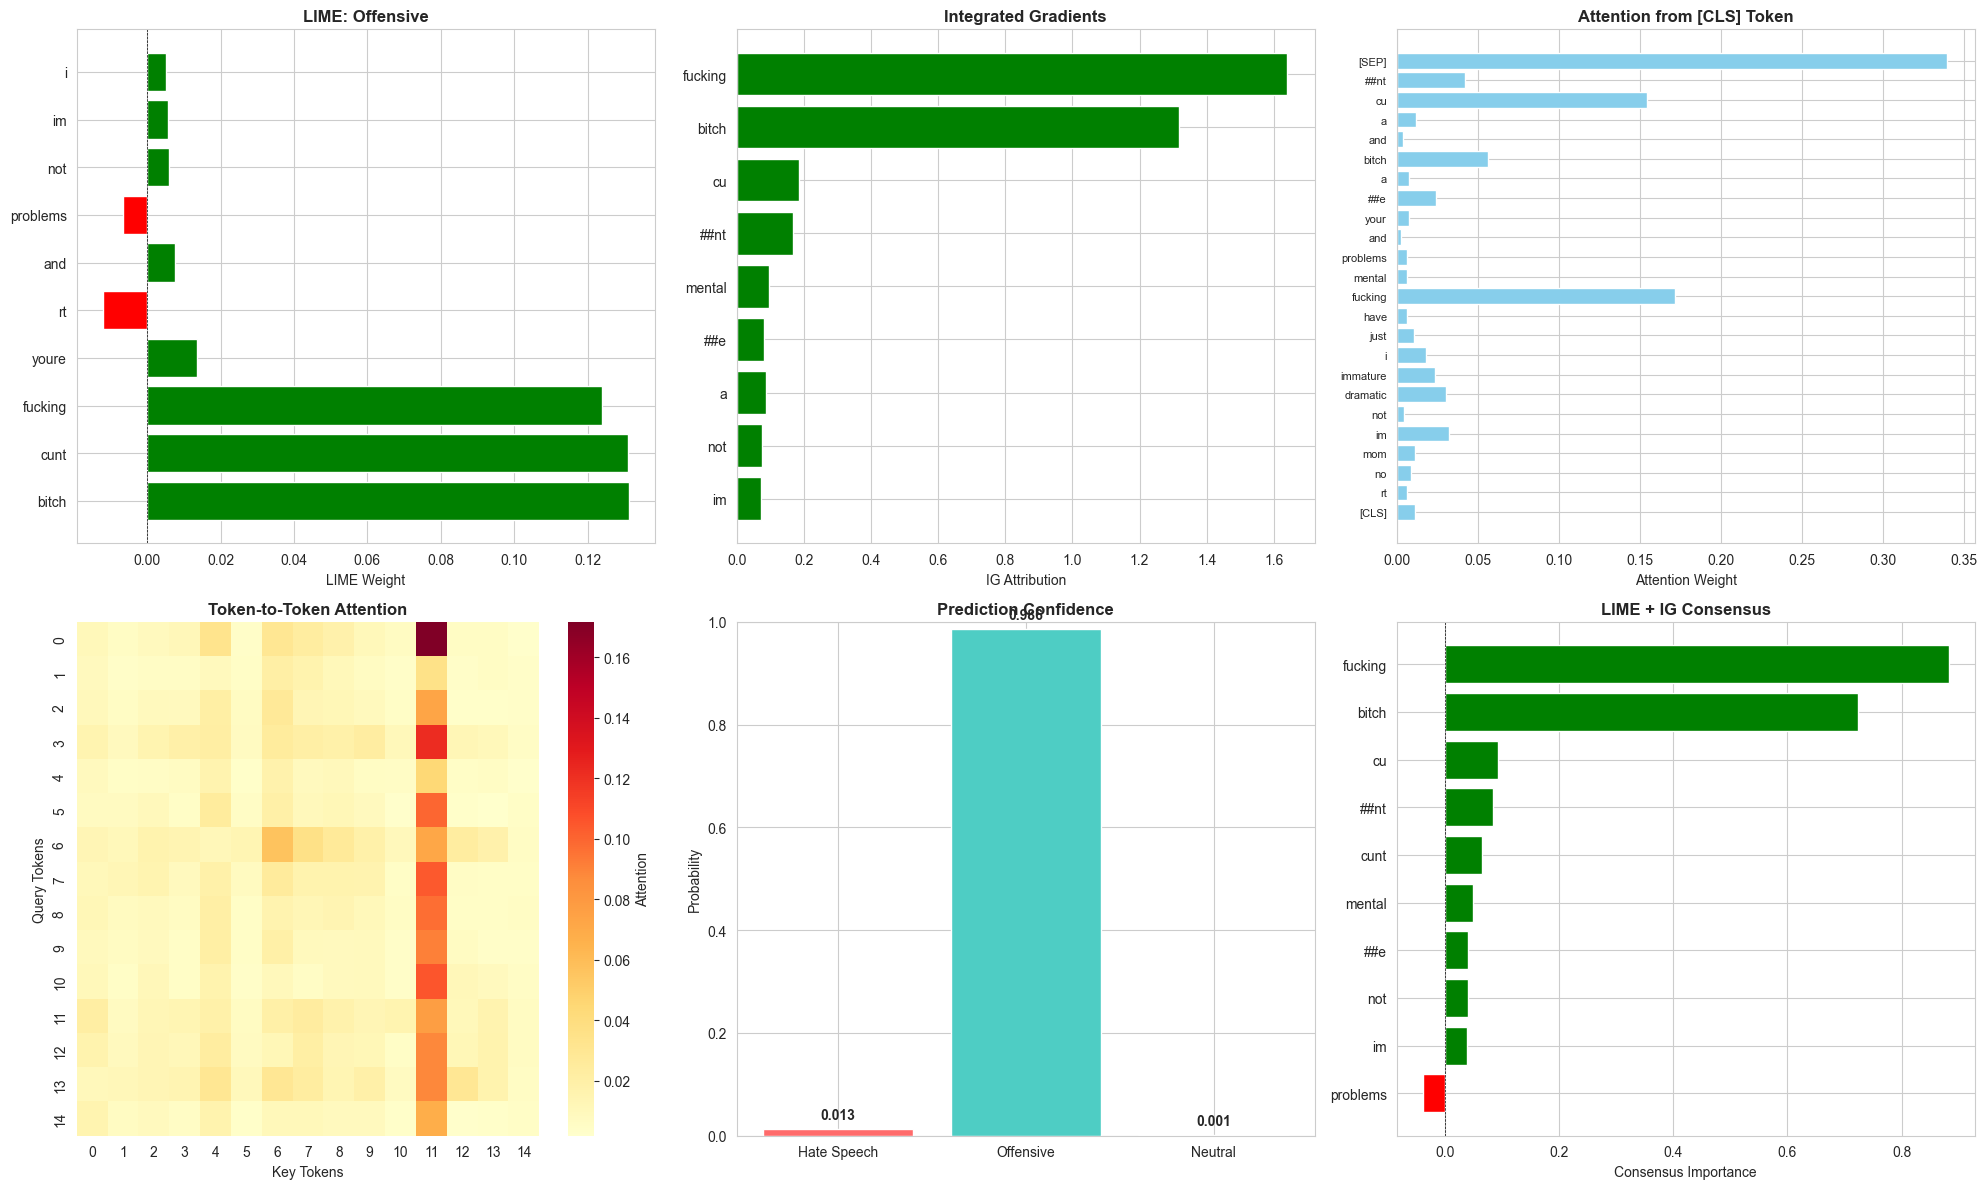


--- Error Case 3 ---
Text: old hoes a ponk and a dyke outchea having girl talk ...
True: Hate Speech | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: old hoes a ponk and a dyke outchea having girl talk
Target Class: Offensive

Prediction: Offensive (0.780)
Probabilities:
  Hate Speech: 0.216
  Offensive: 0.780
  Neutral: 0.004

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_2.png


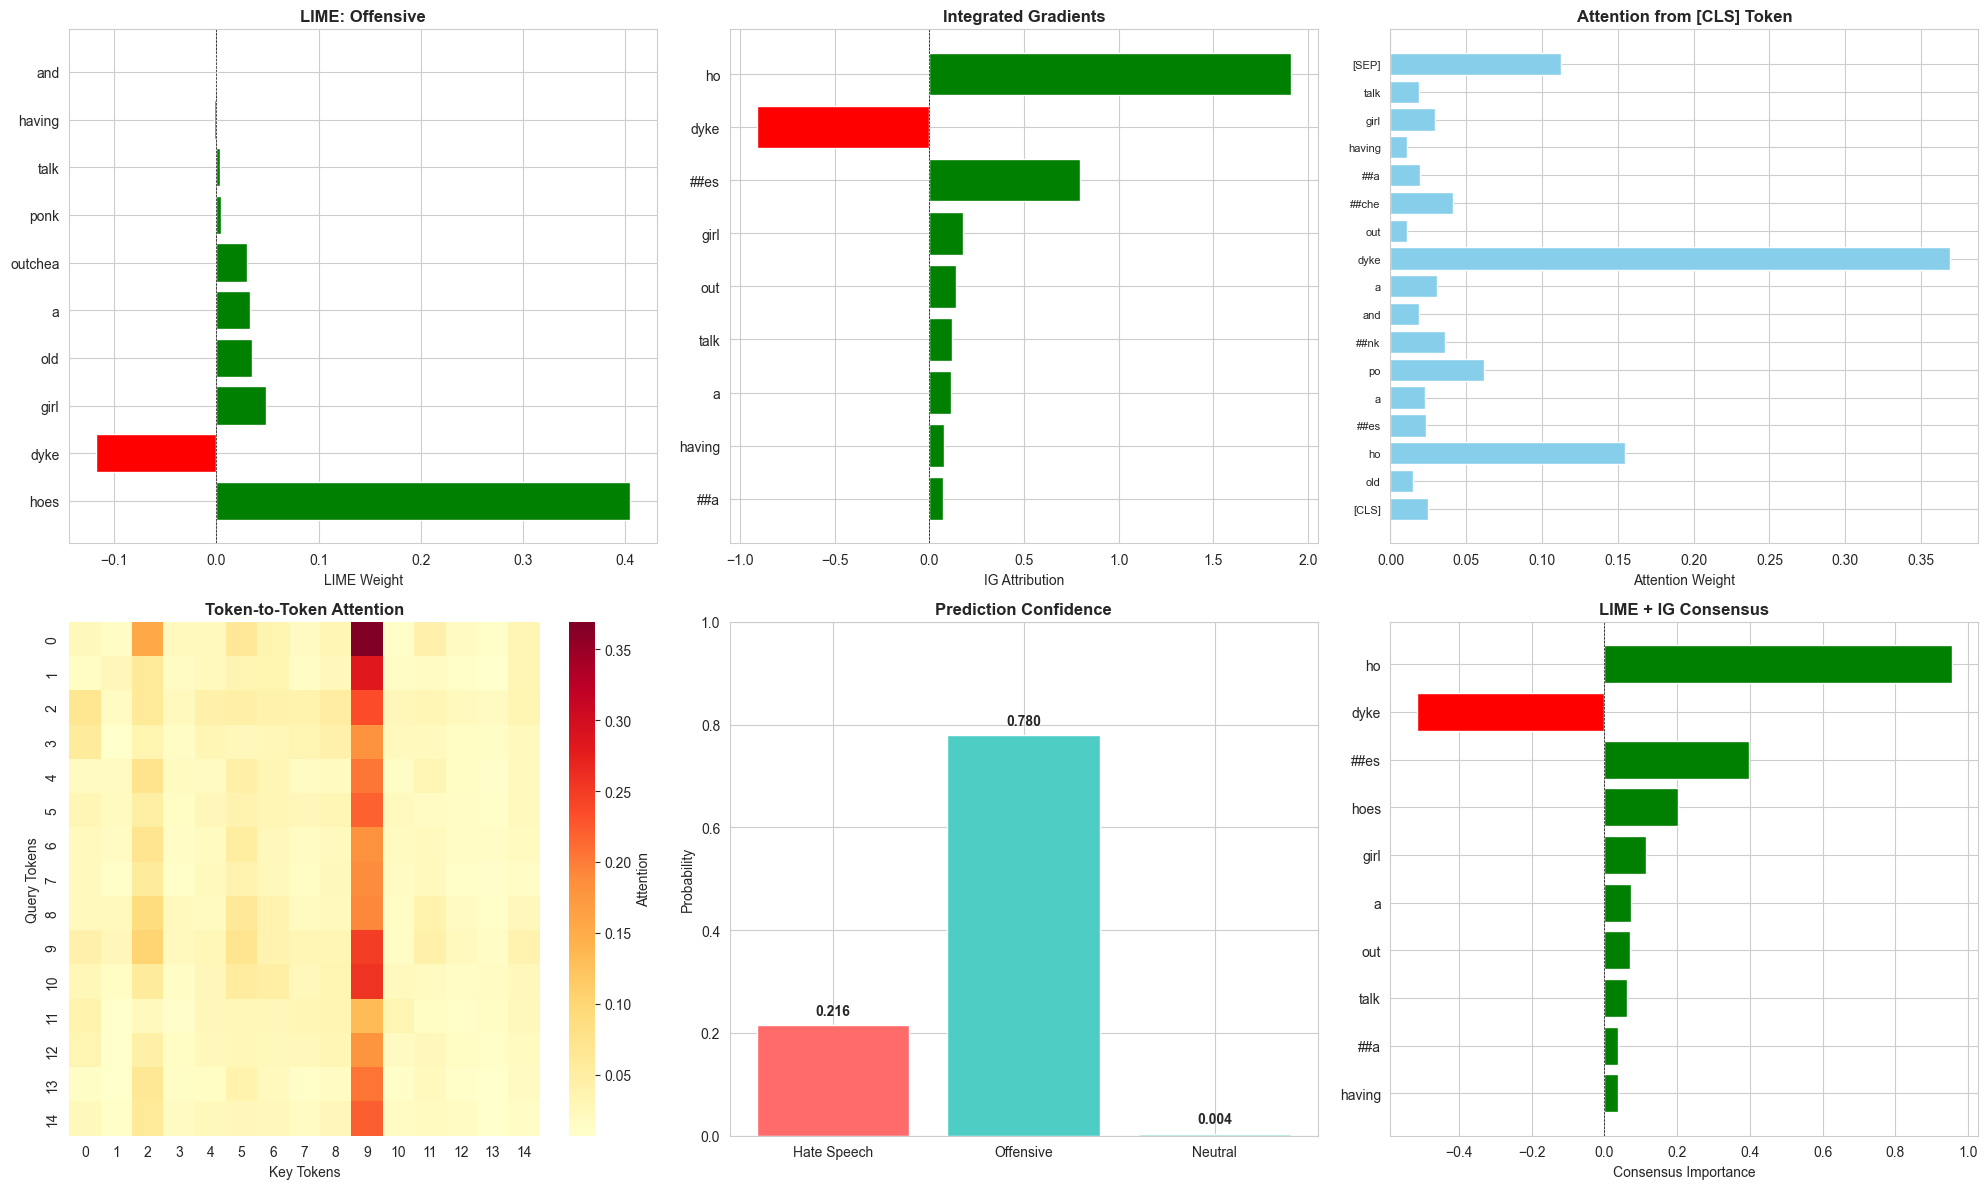


--- Error Case 4 ---
Text: lol that hasnt worked well for black folks in the past they better bring a few crackers with um ...
True: Offensive | Predicted: Hate Speech

Comprehensive Explanation: bert-base-uncased
Text: lol that hasnt worked well for black folks in the past they better bring a few crackers with um
Target Class: Hate Speech

Prediction: Hate Speech (0.438)
Probabilities:
  Hate Speech: 0.438
  Offensive: 0.354
  Neutral: 0.209

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_3.png


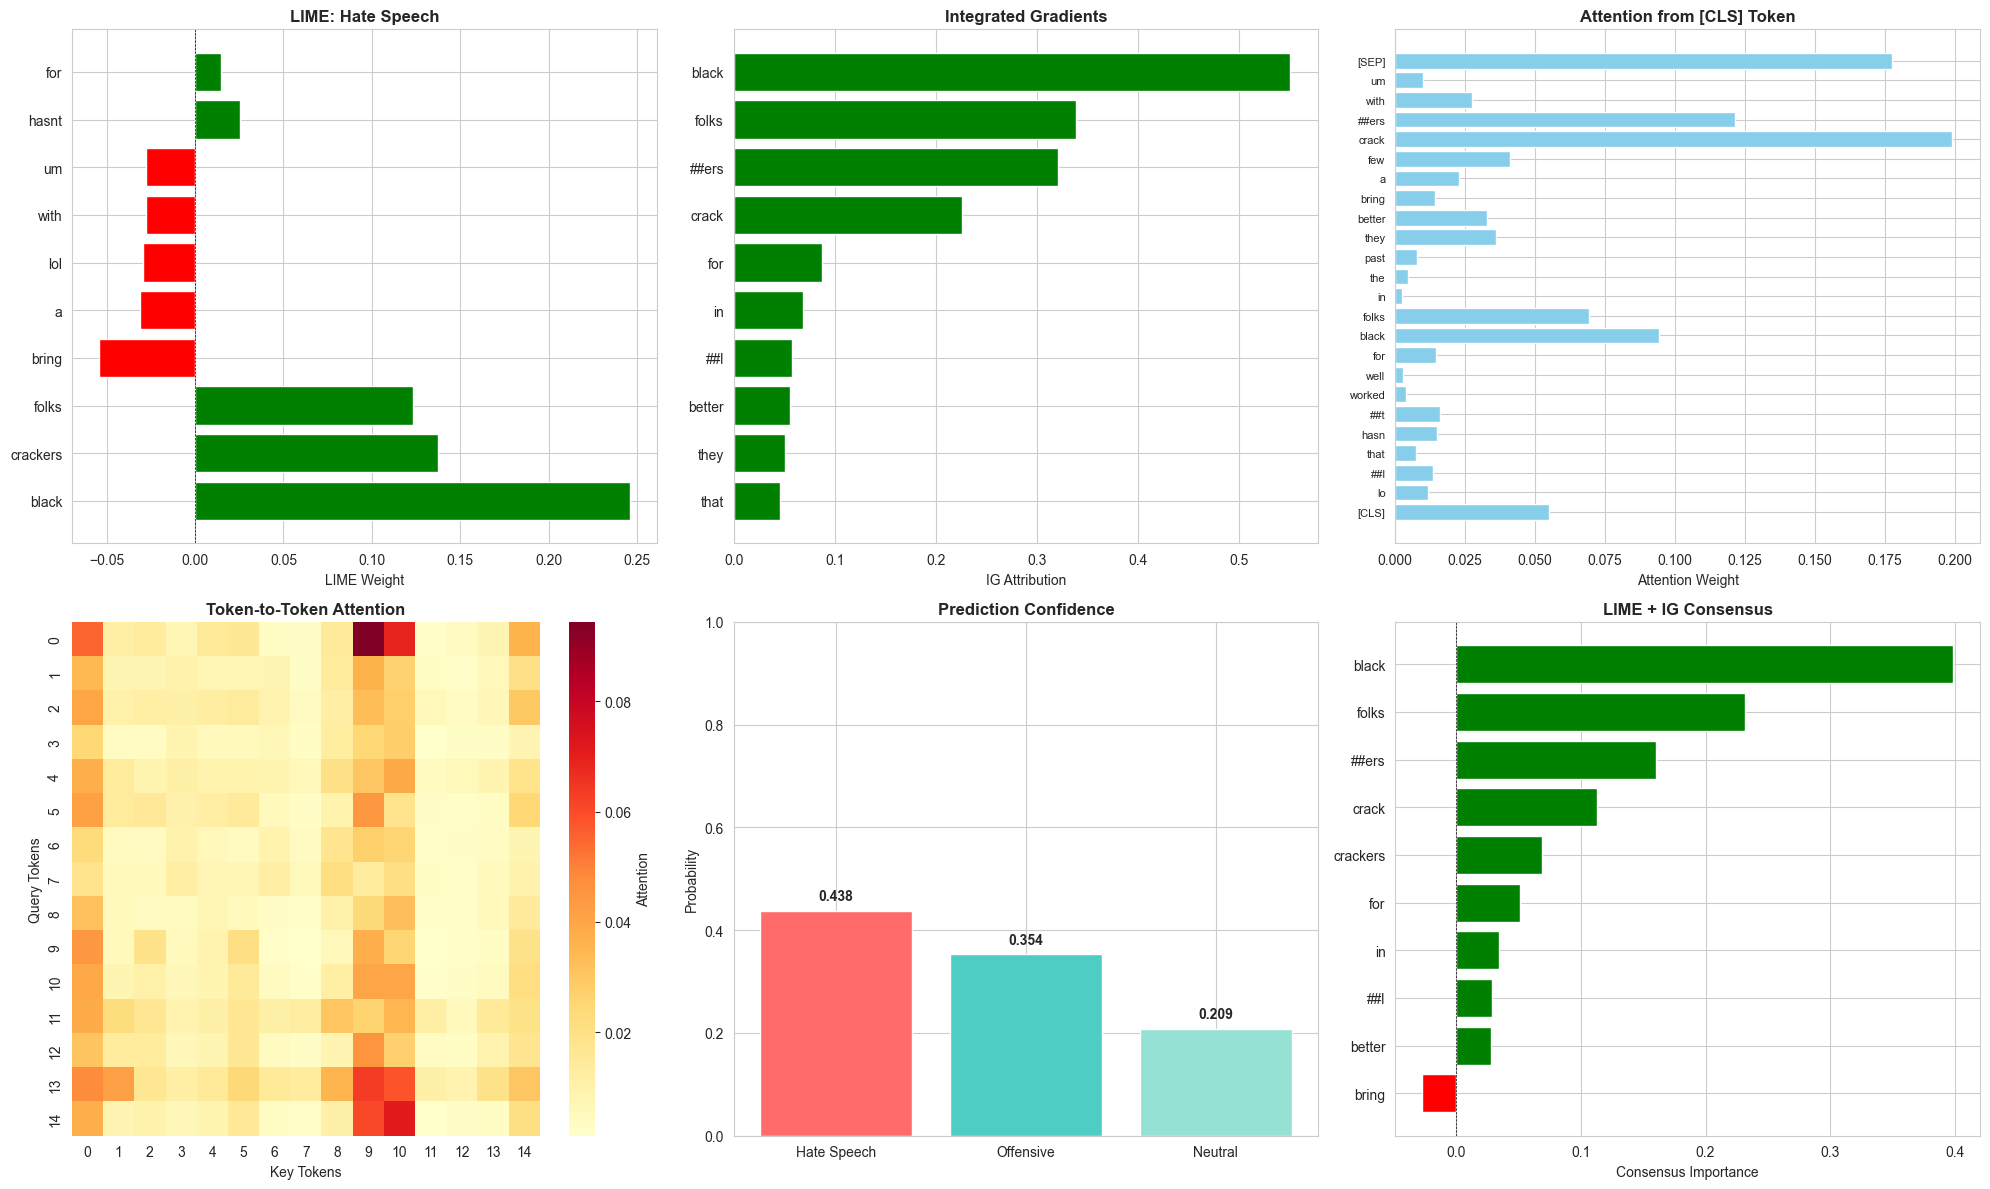


--- Error Case 5 ---
Text: faggot ...
True: Offensive | Predicted: Hate Speech

Comprehensive Explanation: bert-base-uncased
Text: faggot
Target Class: Hate Speech

Prediction: Hate Speech (0.590)
Probabilities:
  Hate Speech: 0.590
  Offensive: 0.399
  Neutral: 0.011

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_4.png


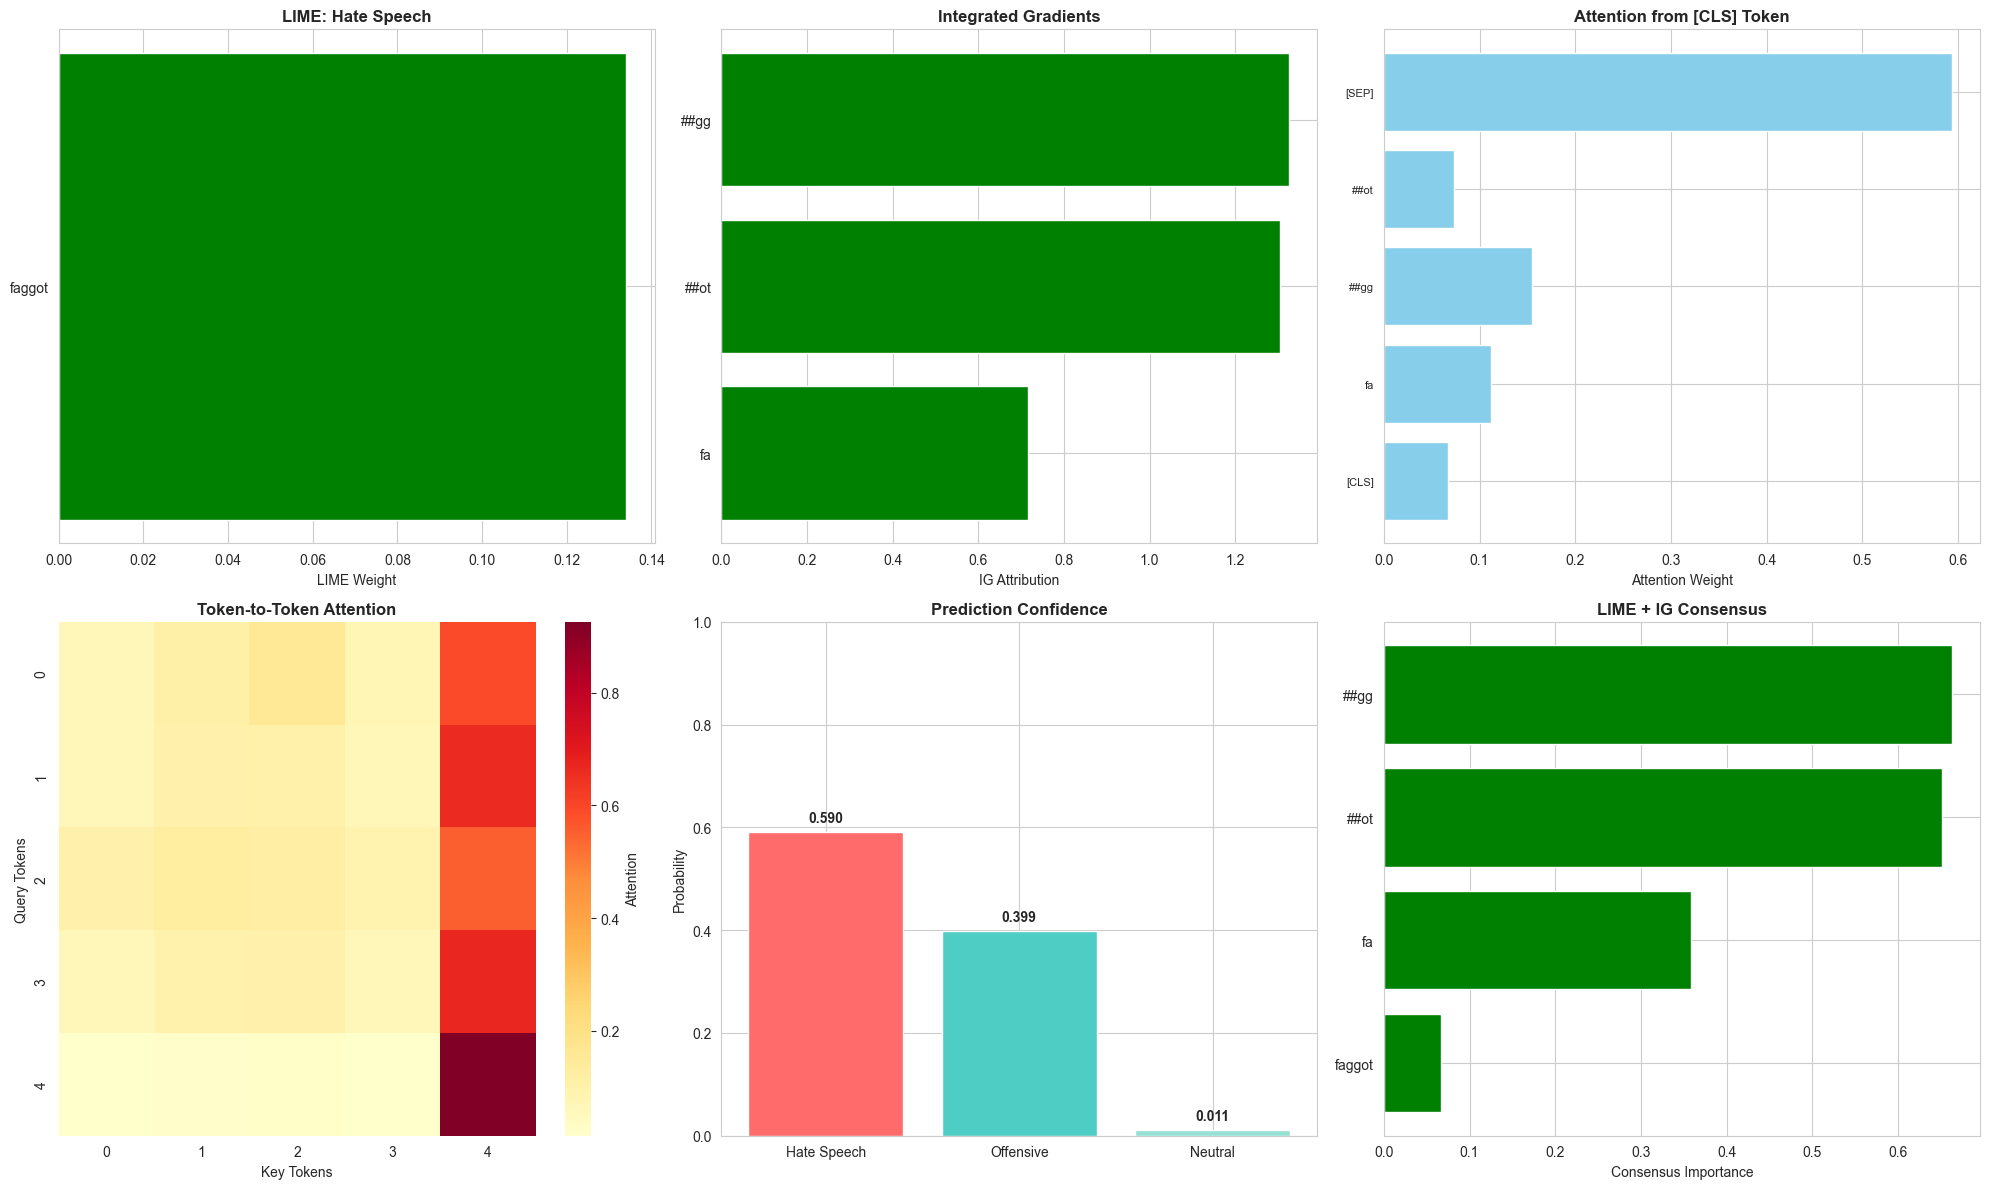


--- Error Case 6 ---
Text: rt thanks for ignoring me faggots im locked outside ...
True: Offensive | Predicted: Hate Speech

Comprehensive Explanation: bert-base-uncased
Text: rt thanks for ignoring me faggots im locked outside
Target Class: Hate Speech

Prediction: Hate Speech (0.548)
Probabilities:
  Hate Speech: 0.548
  Offensive: 0.440
  Neutral: 0.012

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_5.png


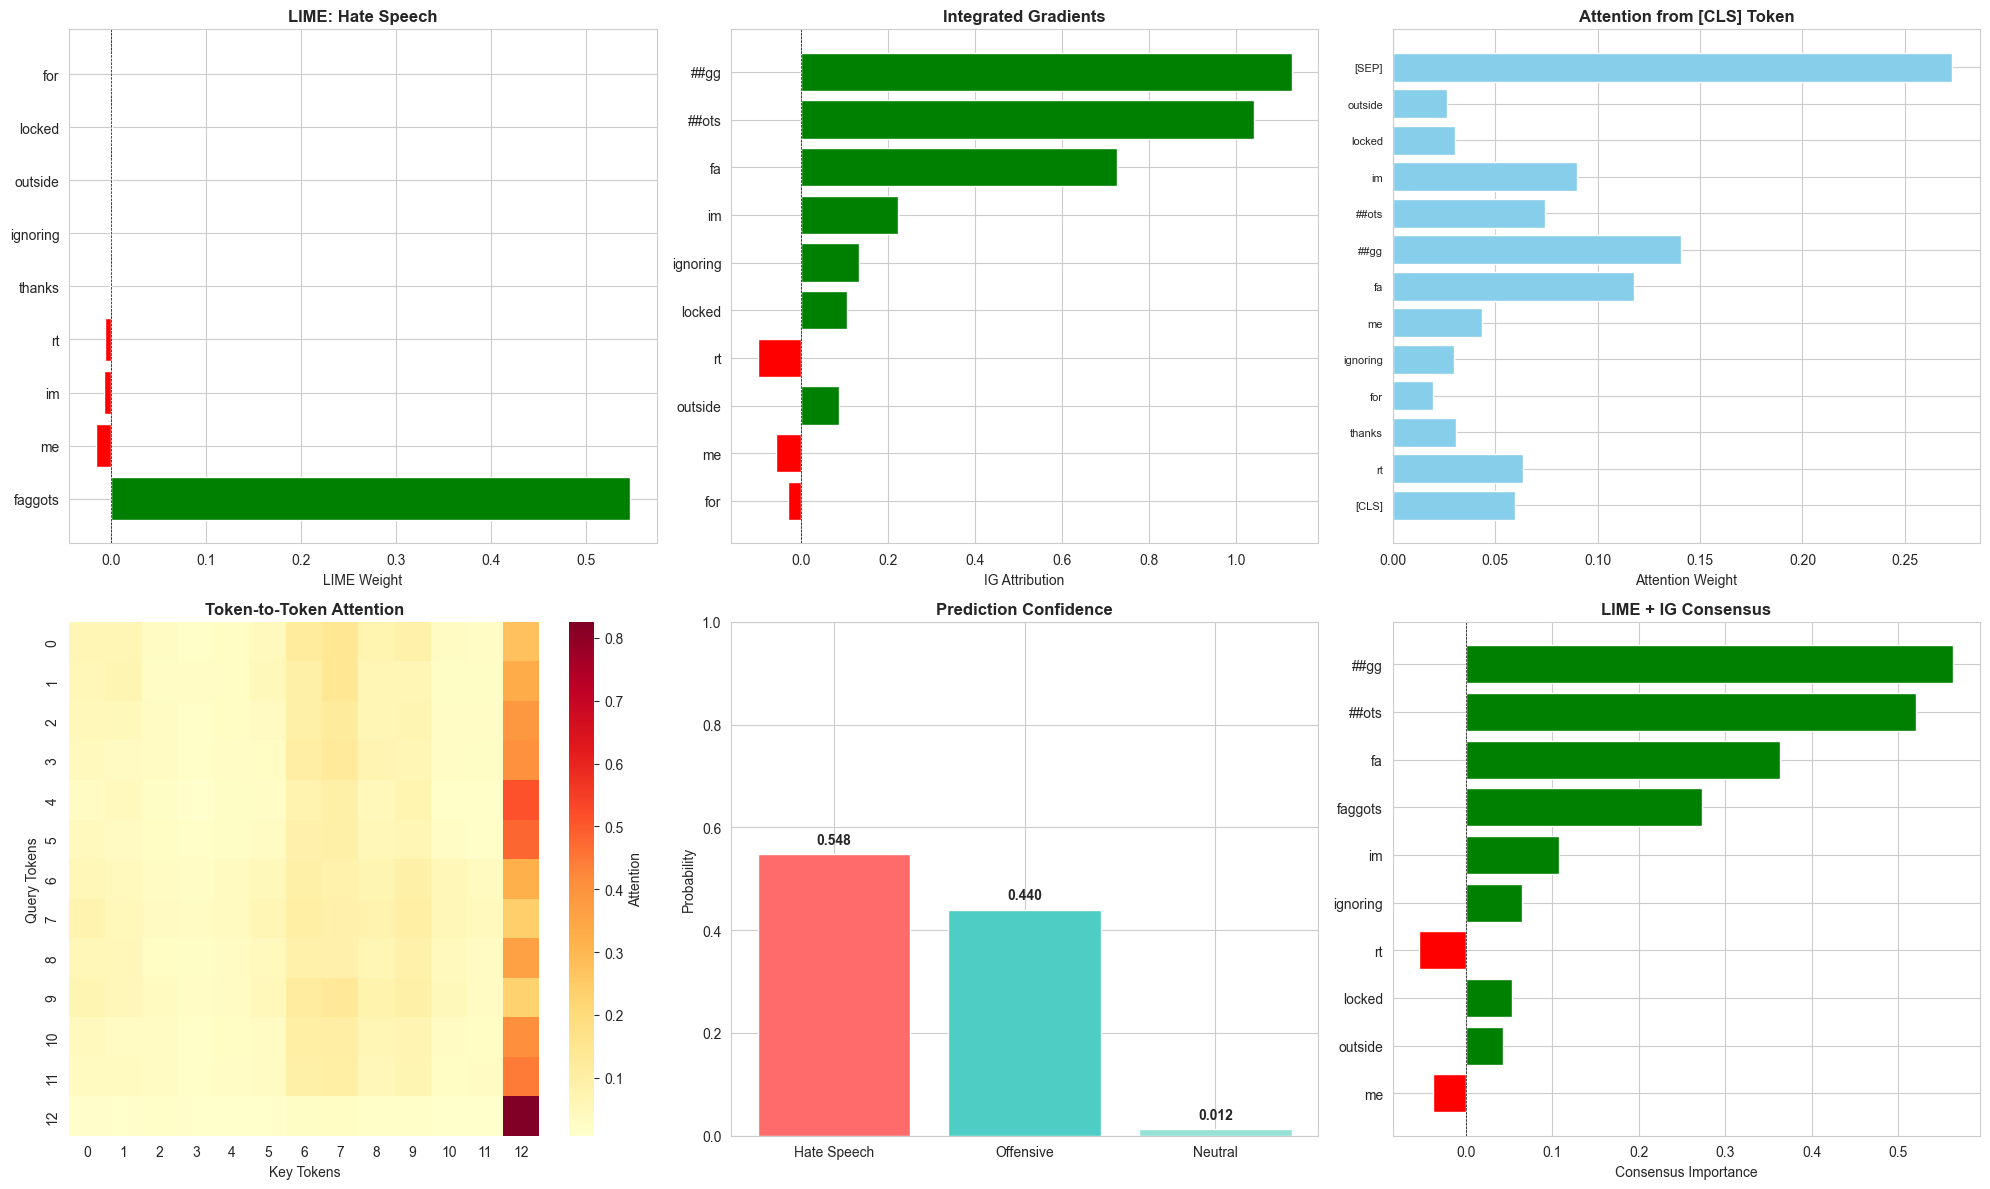


--- Error Case 7 ---
Text: and another one two hoes rt yall know what we are ...
True: Neutral | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: and another one two hoes rt yall know what we are
Target Class: Offensive

Prediction: Offensive (0.993)
Probabilities:
  Hate Speech: 0.006
  Offensive: 0.993
  Neutral: 0.001

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_6.png


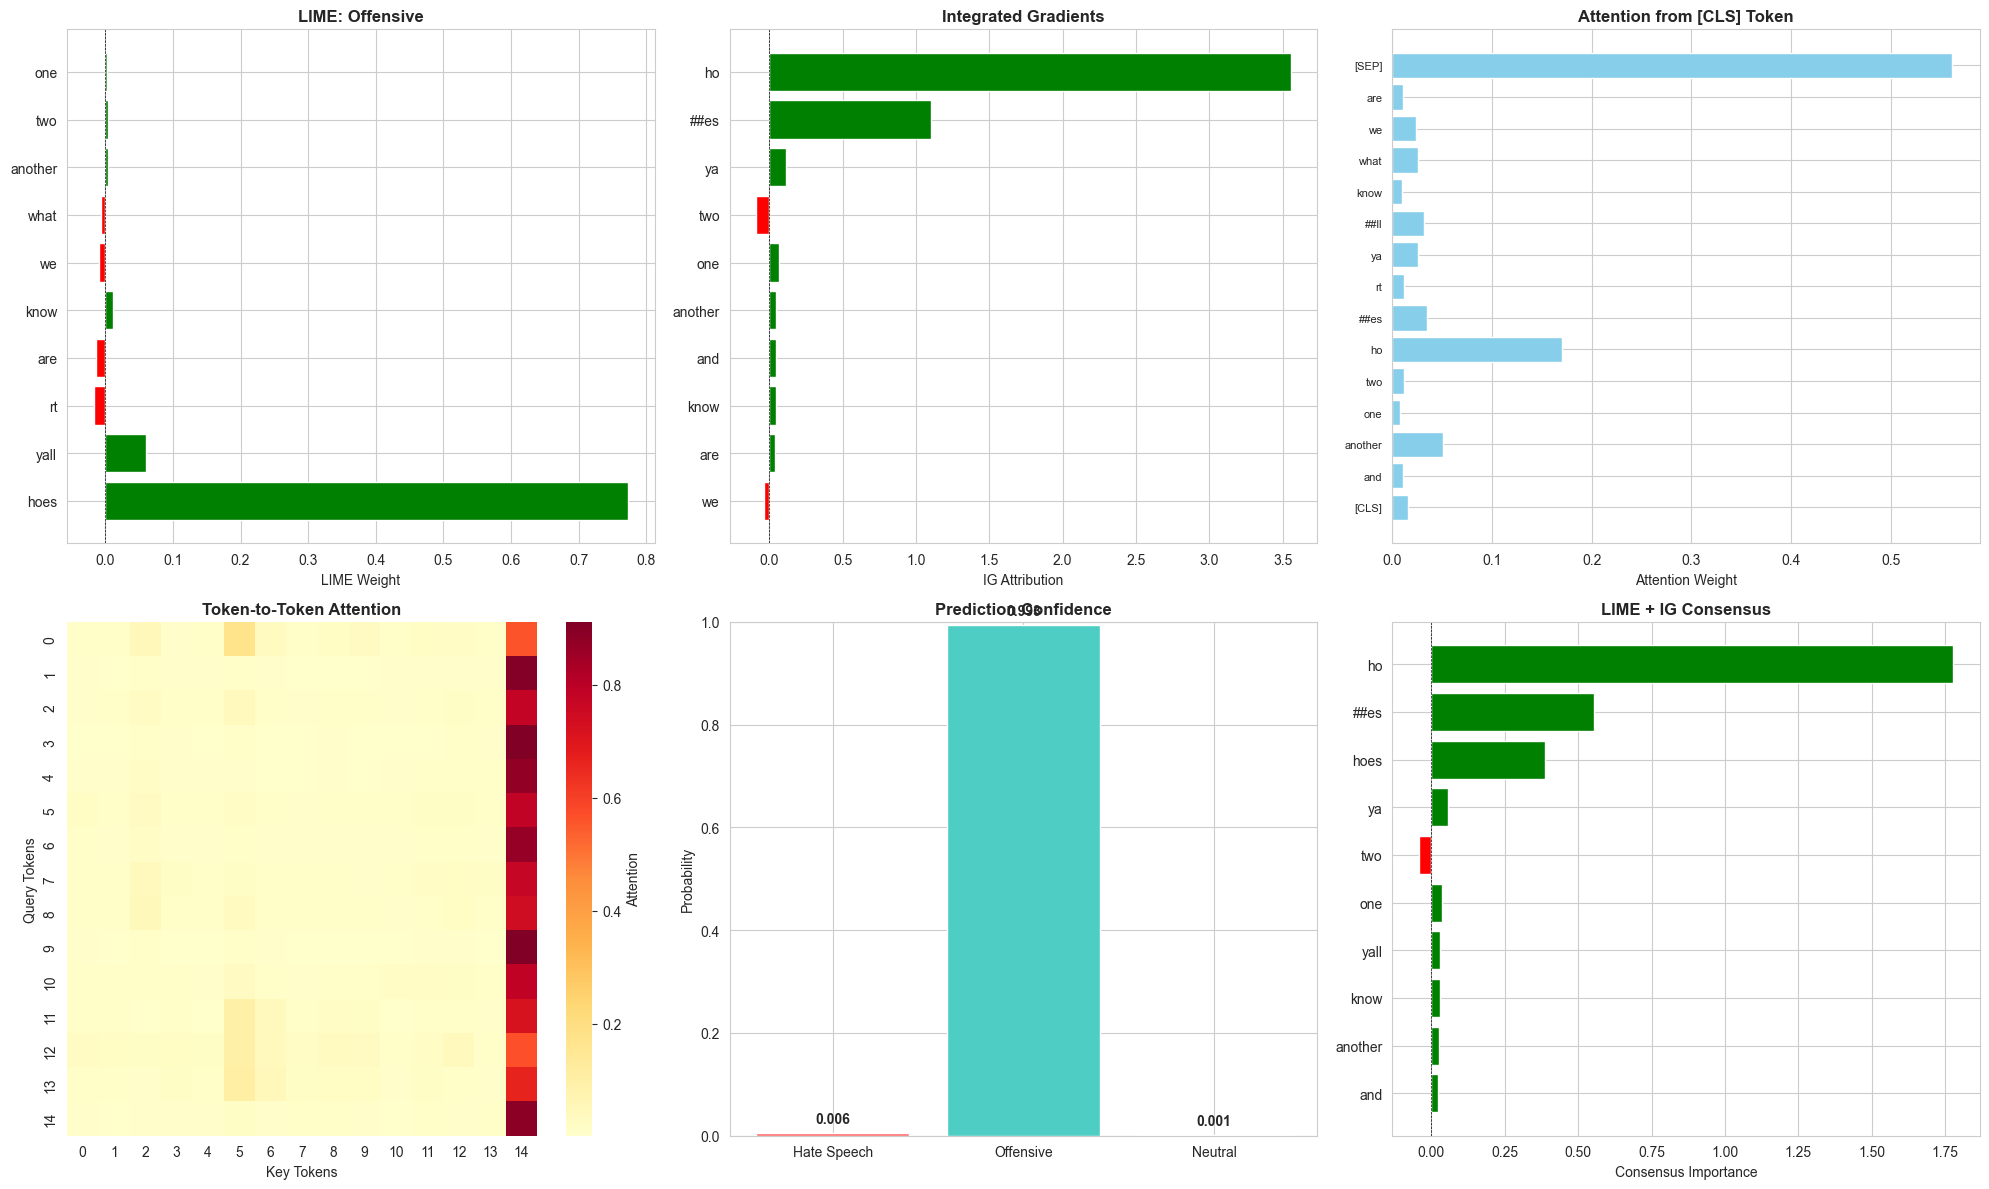


--- Error Case 8 ---
Text: remember dad running a rotary hoe over corn after a freeze to knock the dead leaves off after they turn brown ...
True: Neutral | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: remember dad running a rotary hoe over corn after a freeze to knock the dead leaves off after they turn brown
Target Class: Offensive

Prediction: Offensive (0.993)
Probabilities:
  Hate Speech: 0.005
  Offensive: 0.993
  Neutral: 0.002

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_7.png


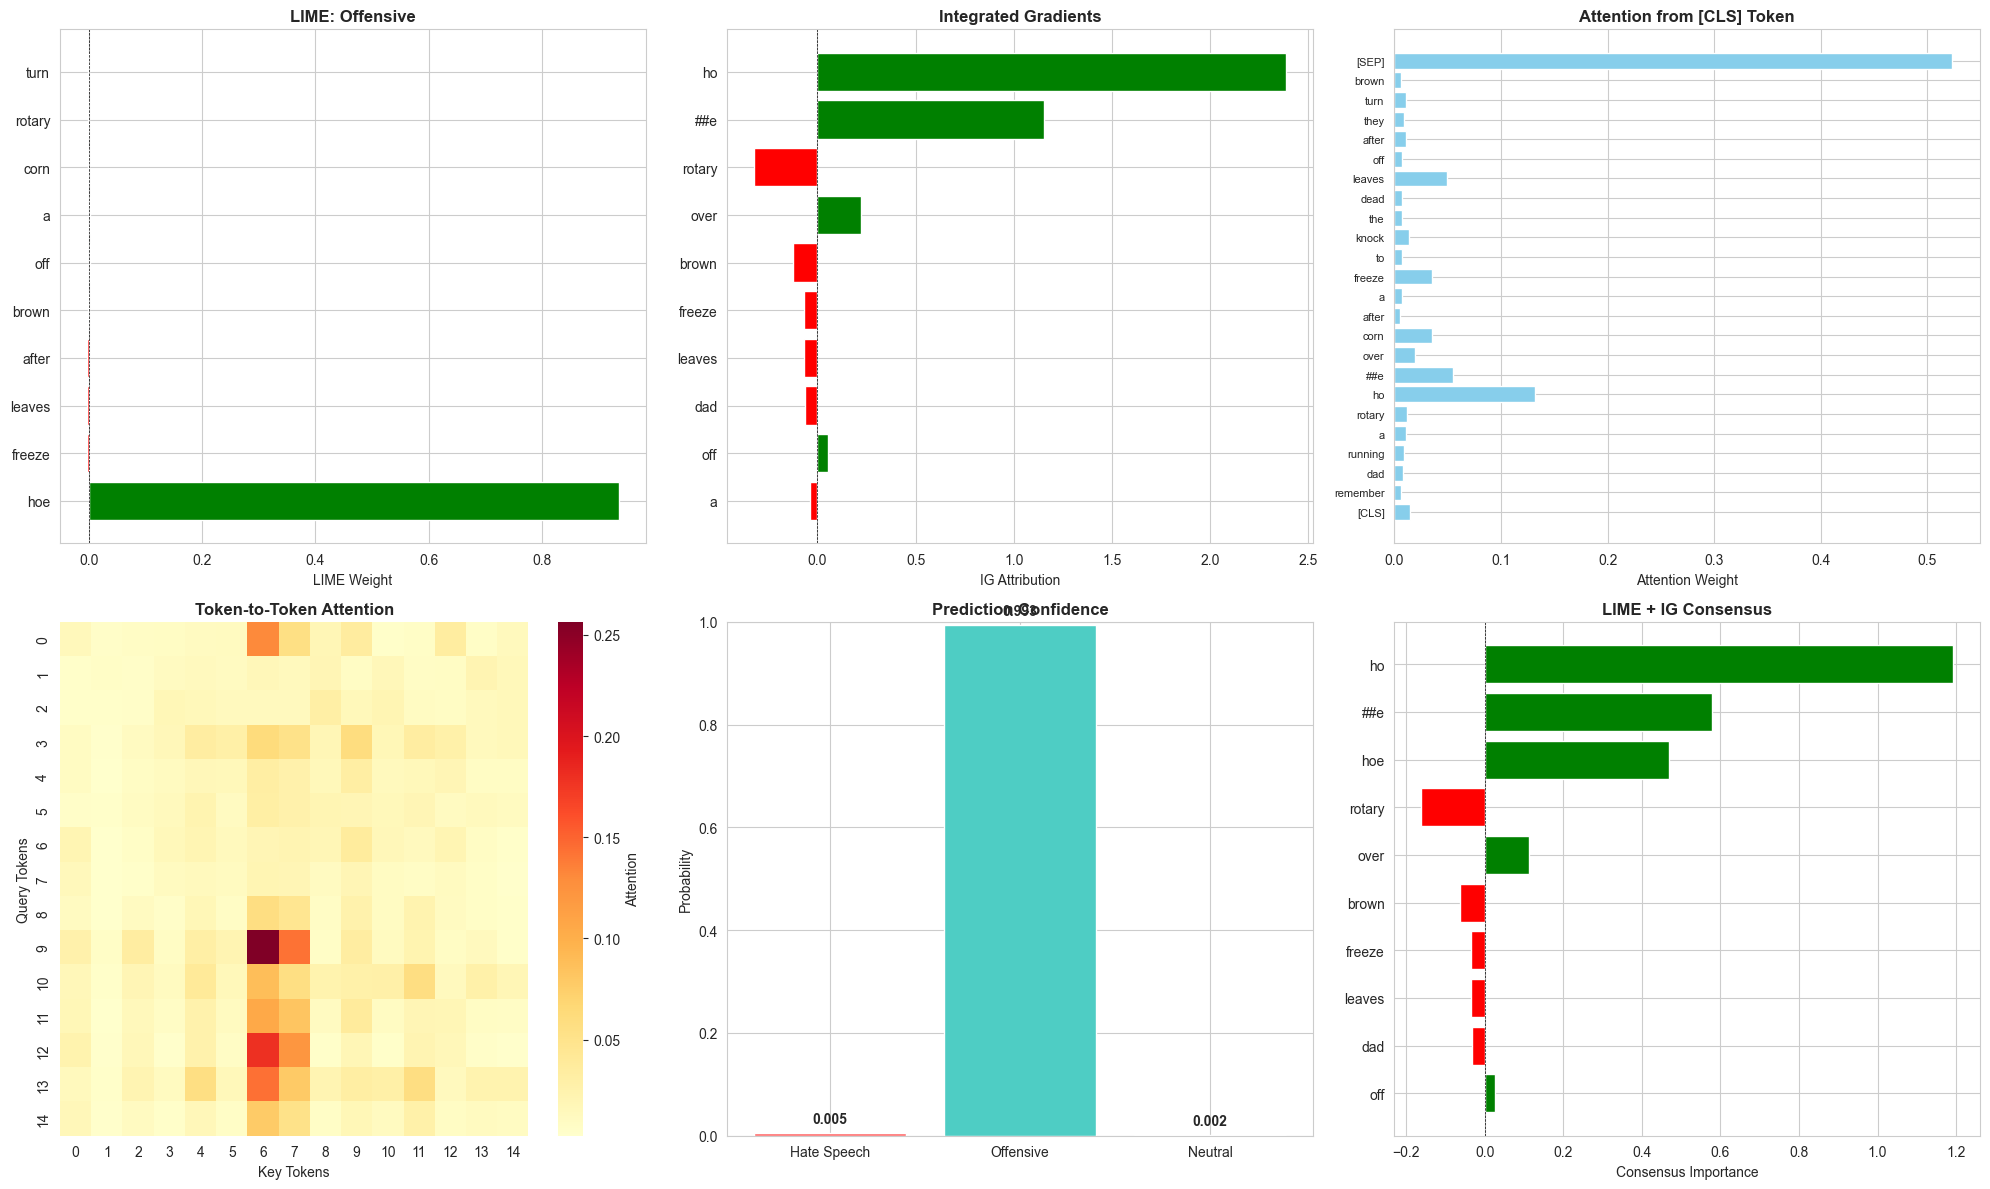


--- Error Case 9 ---
Text: rt i dont wanna hear sgt s name come outta the preezys mouth he couldnt be bothered then keep his pie ho ...
True: Neutral | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: rt i dont wanna hear sgt s name come outta the preezys mouth he couldnt be bothered then keep his pie ho
Target Class: Offensive

Prediction: Offensive (0.966)
Probabilities:
  Hate Speech: 0.014
  Offensive: 0.966
  Neutral: 0.020

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_8.png


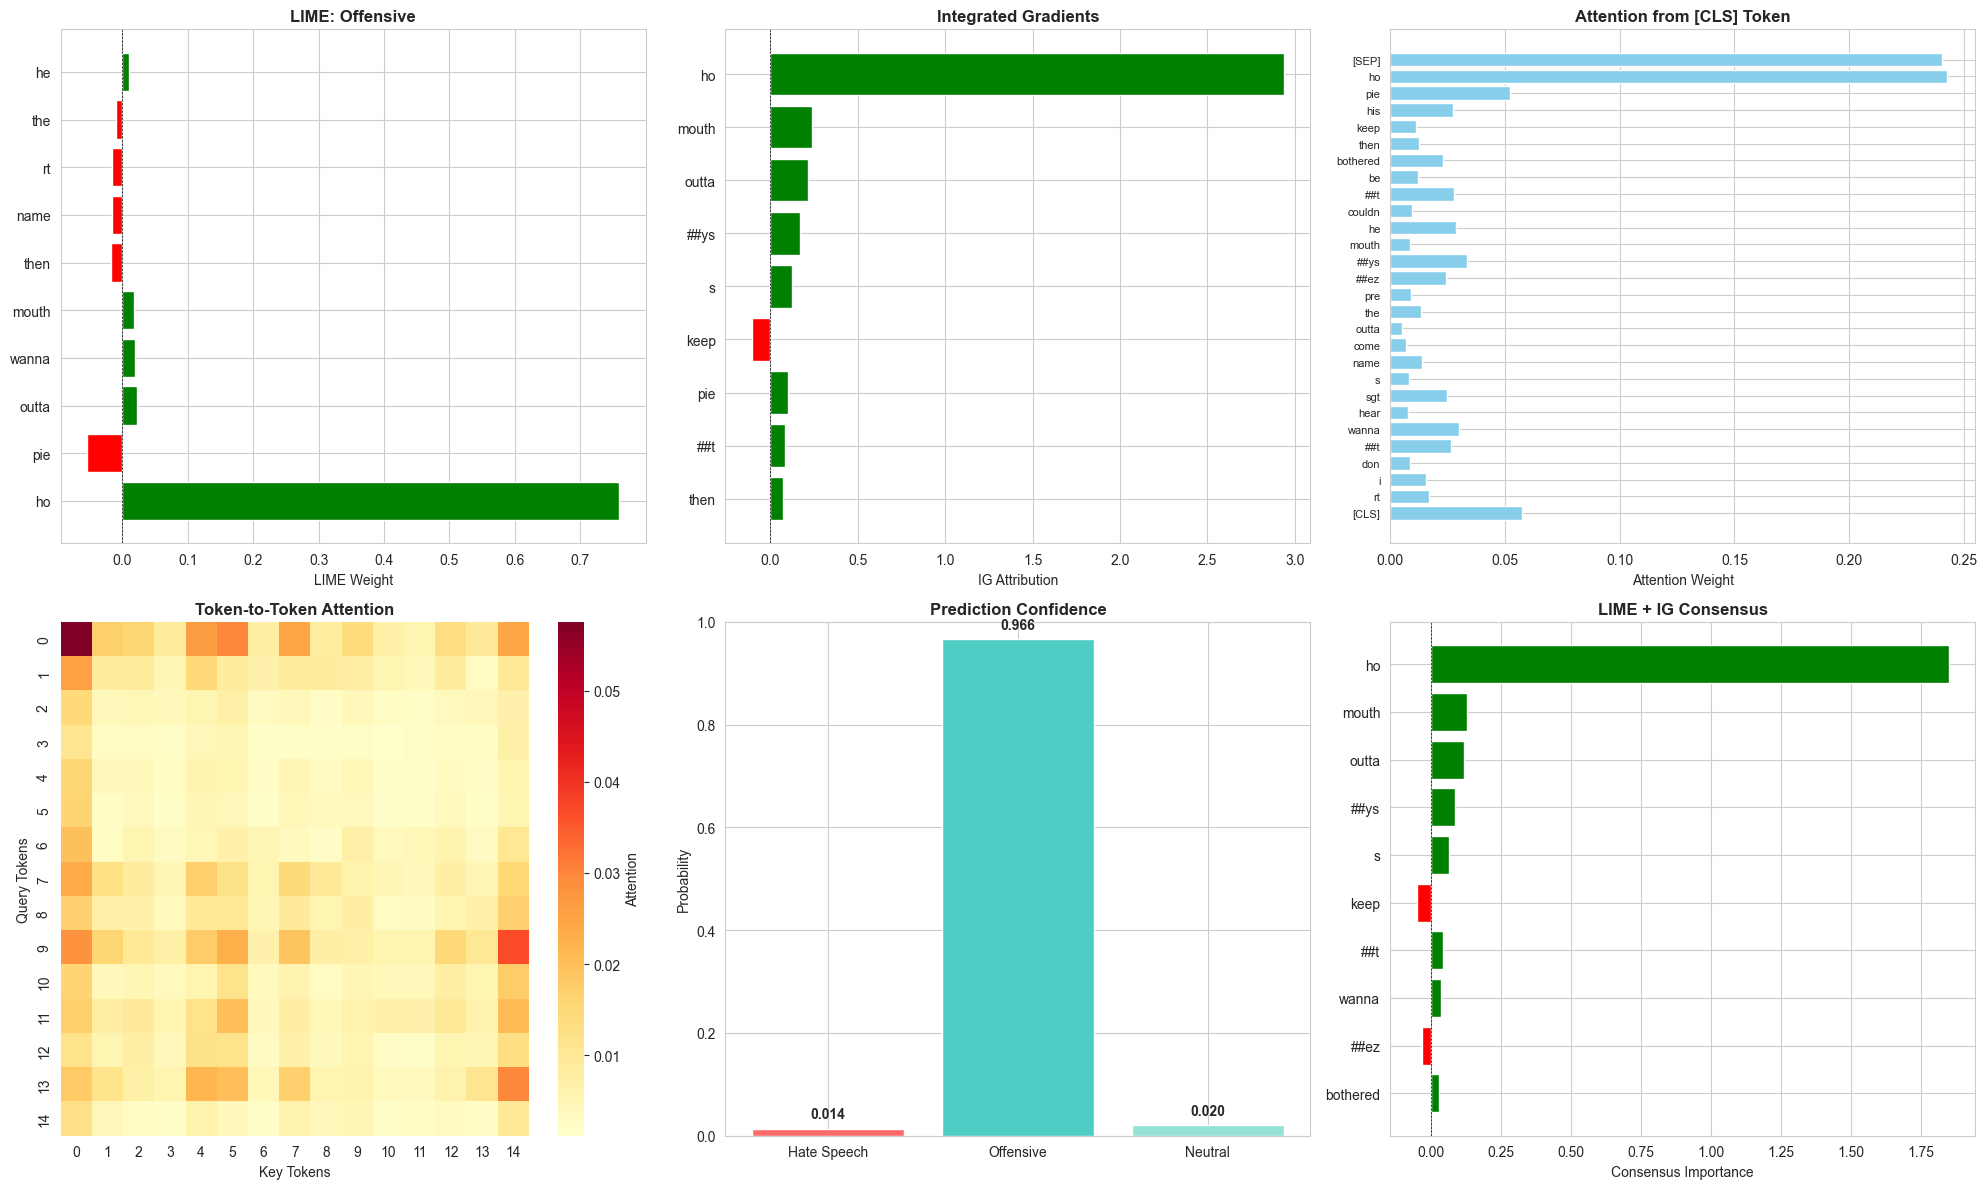


--- Error Case 10 ---
Text: i guess blaspheme to your allah is ok if your pos muzzie huh ...
True: Hate Speech | Predicted: Neutral

Comprehensive Explanation: bert-base-uncased
Text: i guess blaspheme to your allah is ok if your pos muzzie huh
Target Class: Neutral

Prediction: Neutral (0.827)
Probabilities:
  Hate Speech: 0.030
  Offensive: 0.143
  Neutral: 0.827

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_9.png


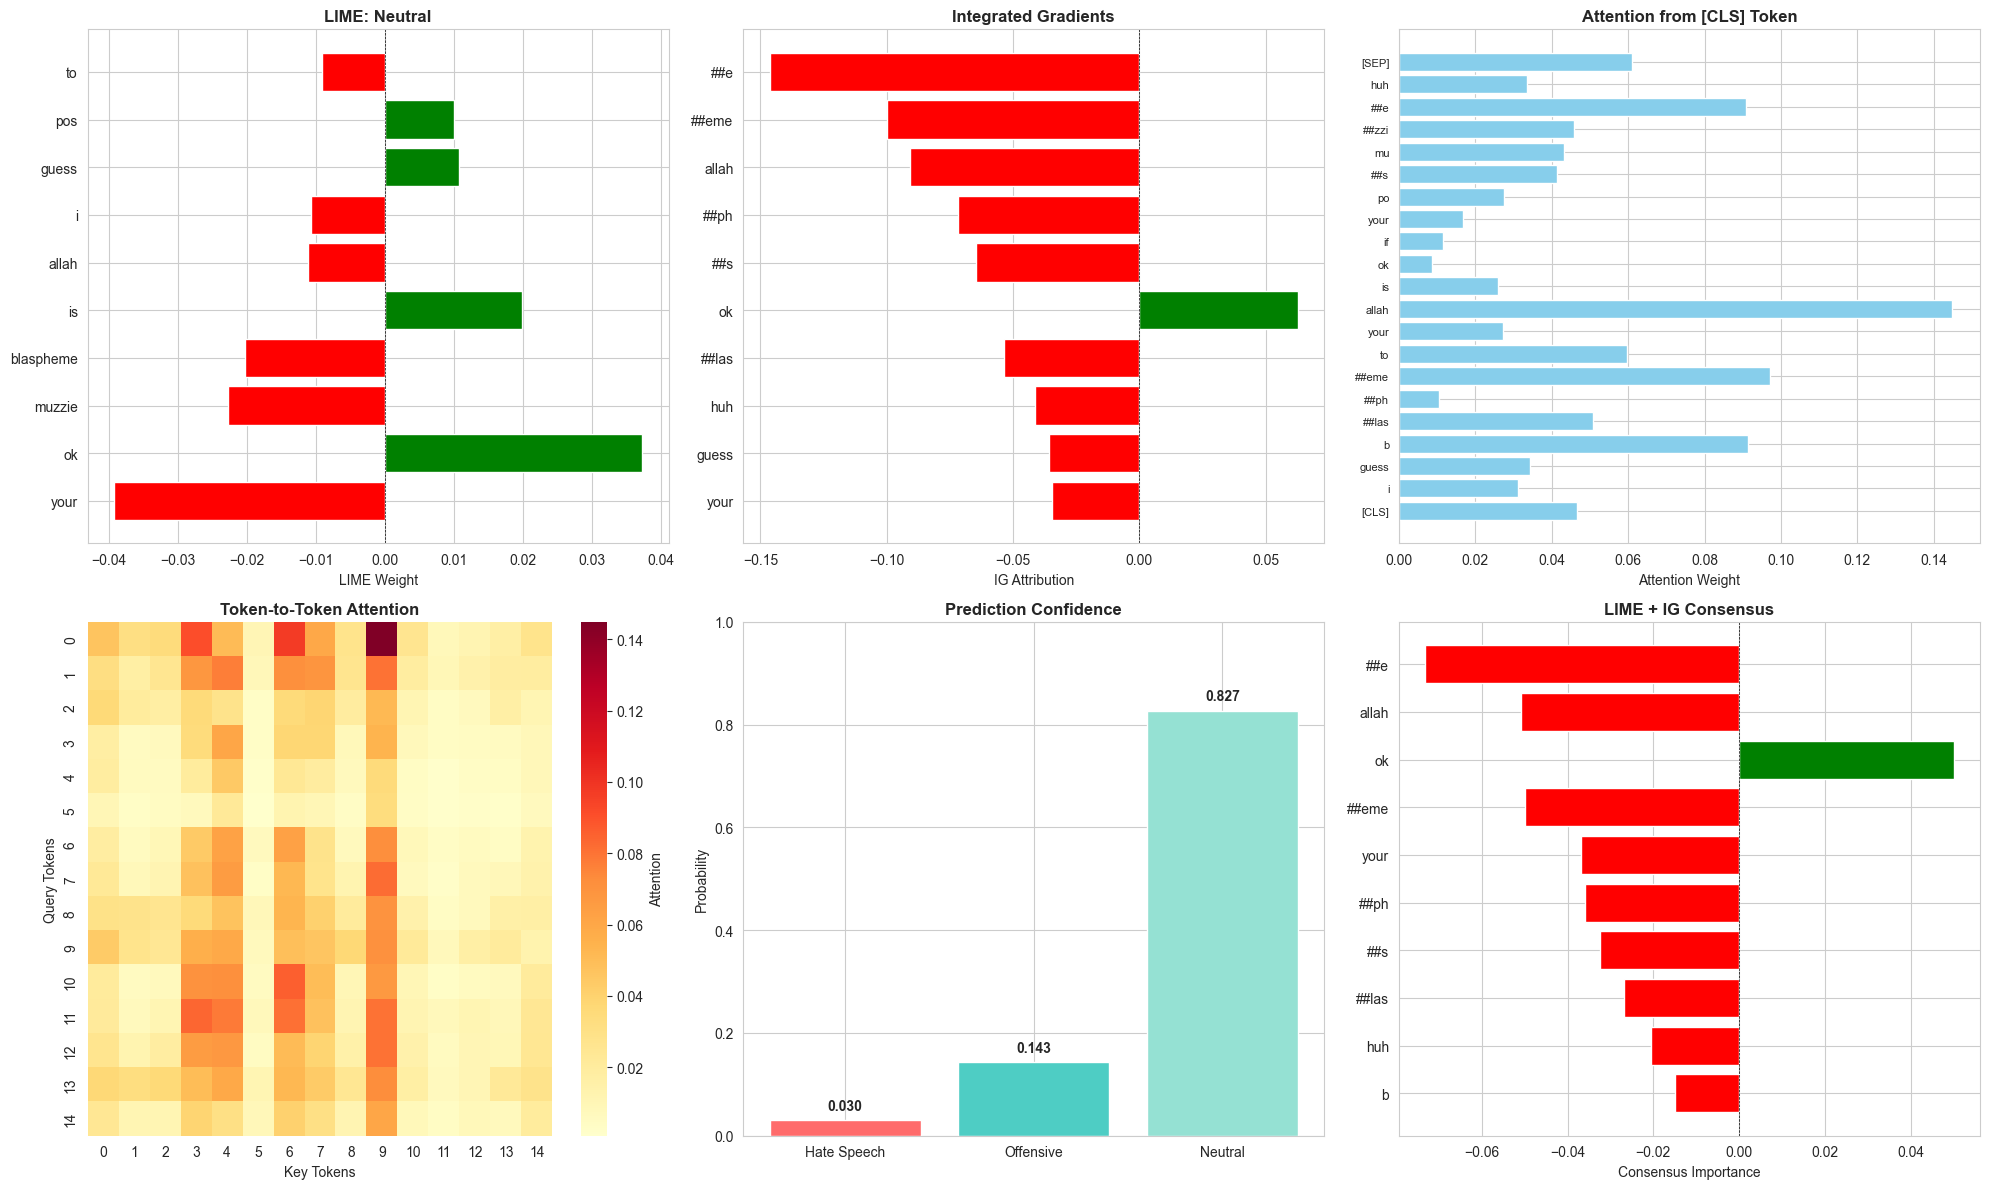


ERROR + EXPLAINABILITY ANALYSIS — SMOTE DATASET
Best SMOTE Model: bert-base-uncased

Misclassification Analysis: bert-base-uncased

Total misclassifications: 442 / 4957
Error rate: 8.92%

--- Error Type Distribution ---
0→1: 144
1→0: 118
1→2: 93
2→1: 55
0→2: 21
2→0: 11

--- Error Case 1 ---
Text: rt you sure do have a pretty face for a cripple ...
True: Neutral | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: rt you sure do have a pretty face for a cripple
Target Class: Offensive

Prediction: Offensive (0.989)
Probabilities:
  Hate Speech: 0.000
  Offensive: 0.989
  Neutral: 0.011

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_0.png


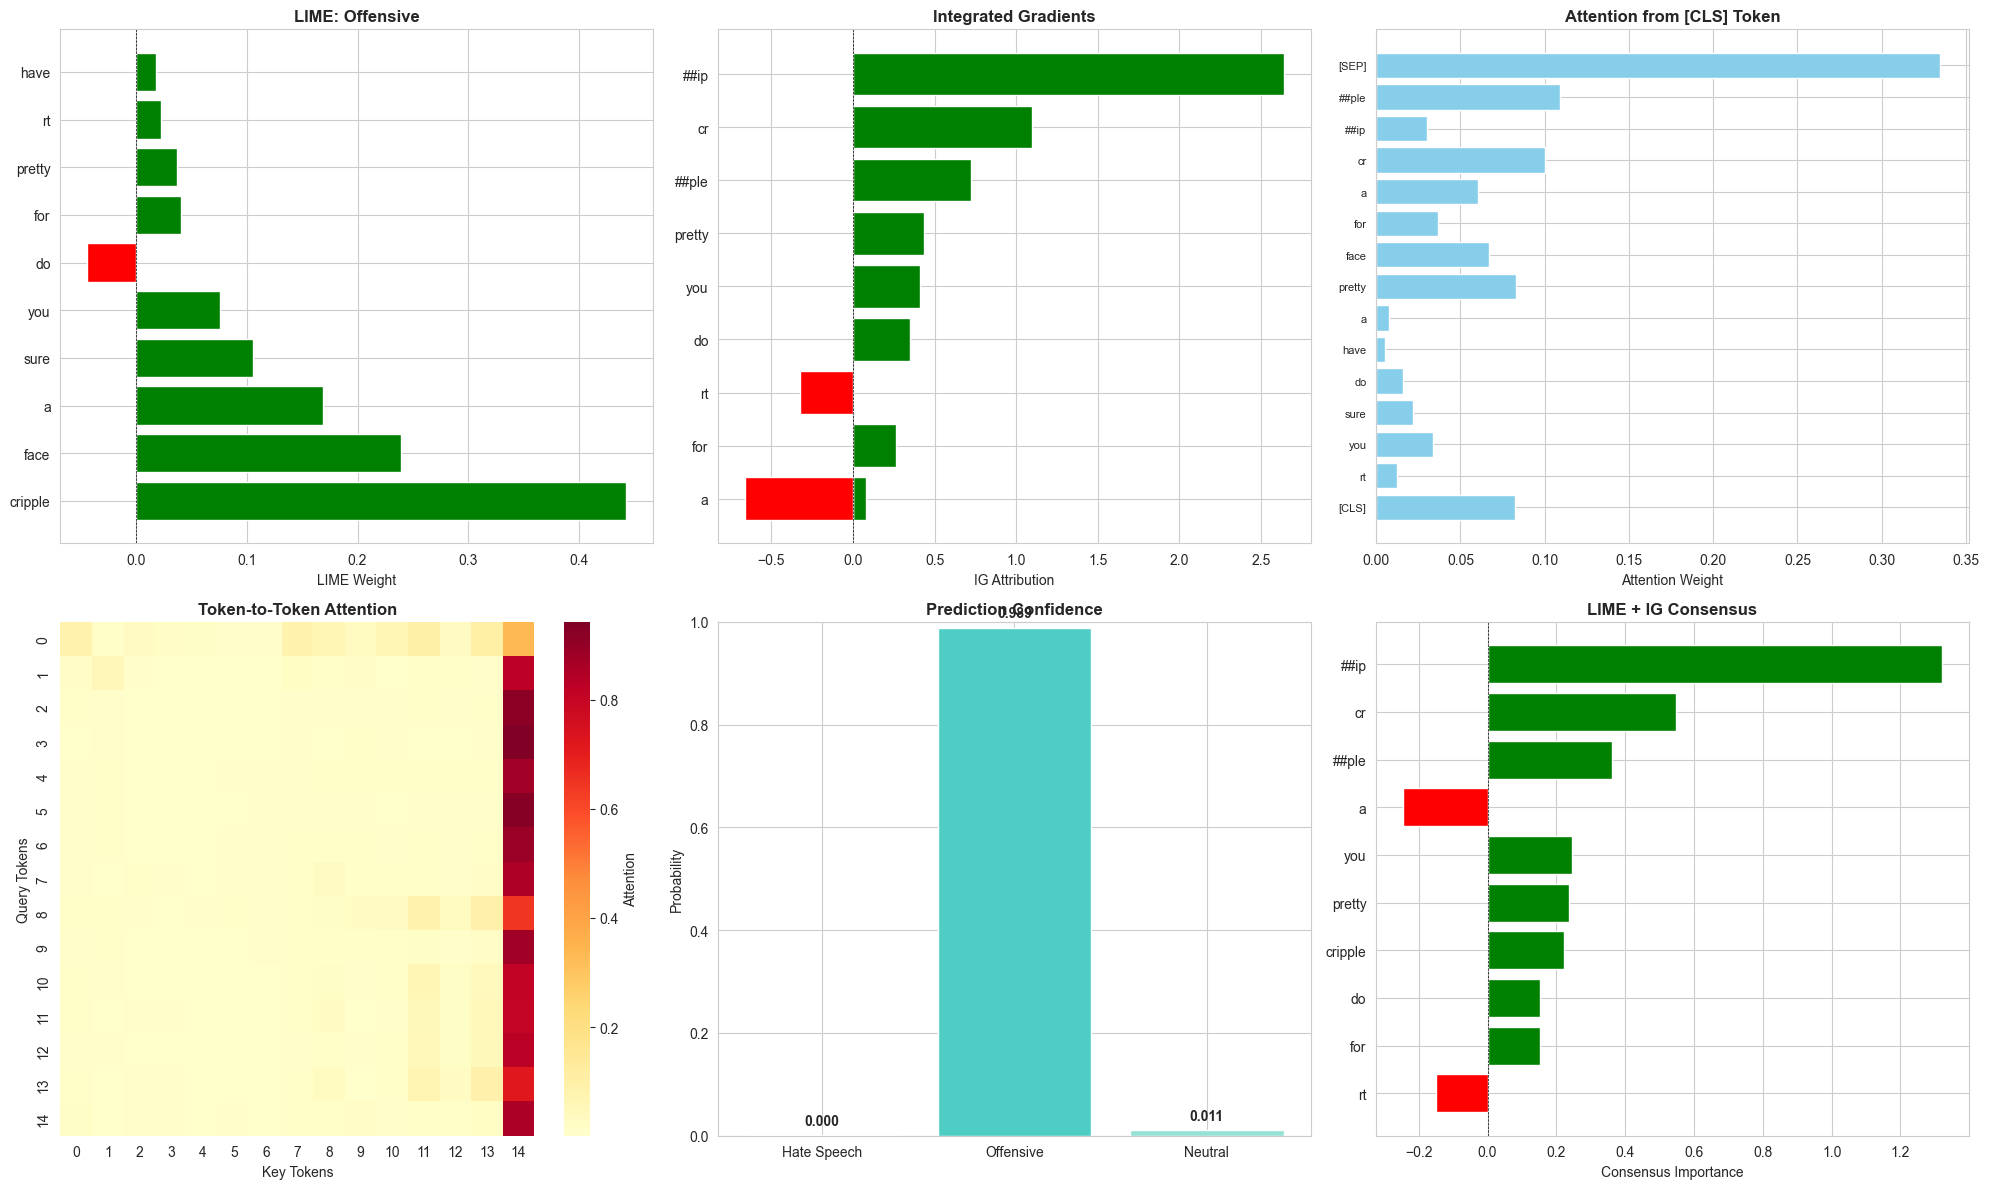


--- Error Case 2 ---
Text: ha he aint welcome in washington state or nashville serpas is straight trash ...
True: Neutral | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: ha he aint welcome in washington state or nashville serpas is straight trash
Target Class: Offensive

Prediction: Offensive (1.000)
Probabilities:
  Hate Speech: 0.000
  Offensive: 1.000
  Neutral: 0.000

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_1.png


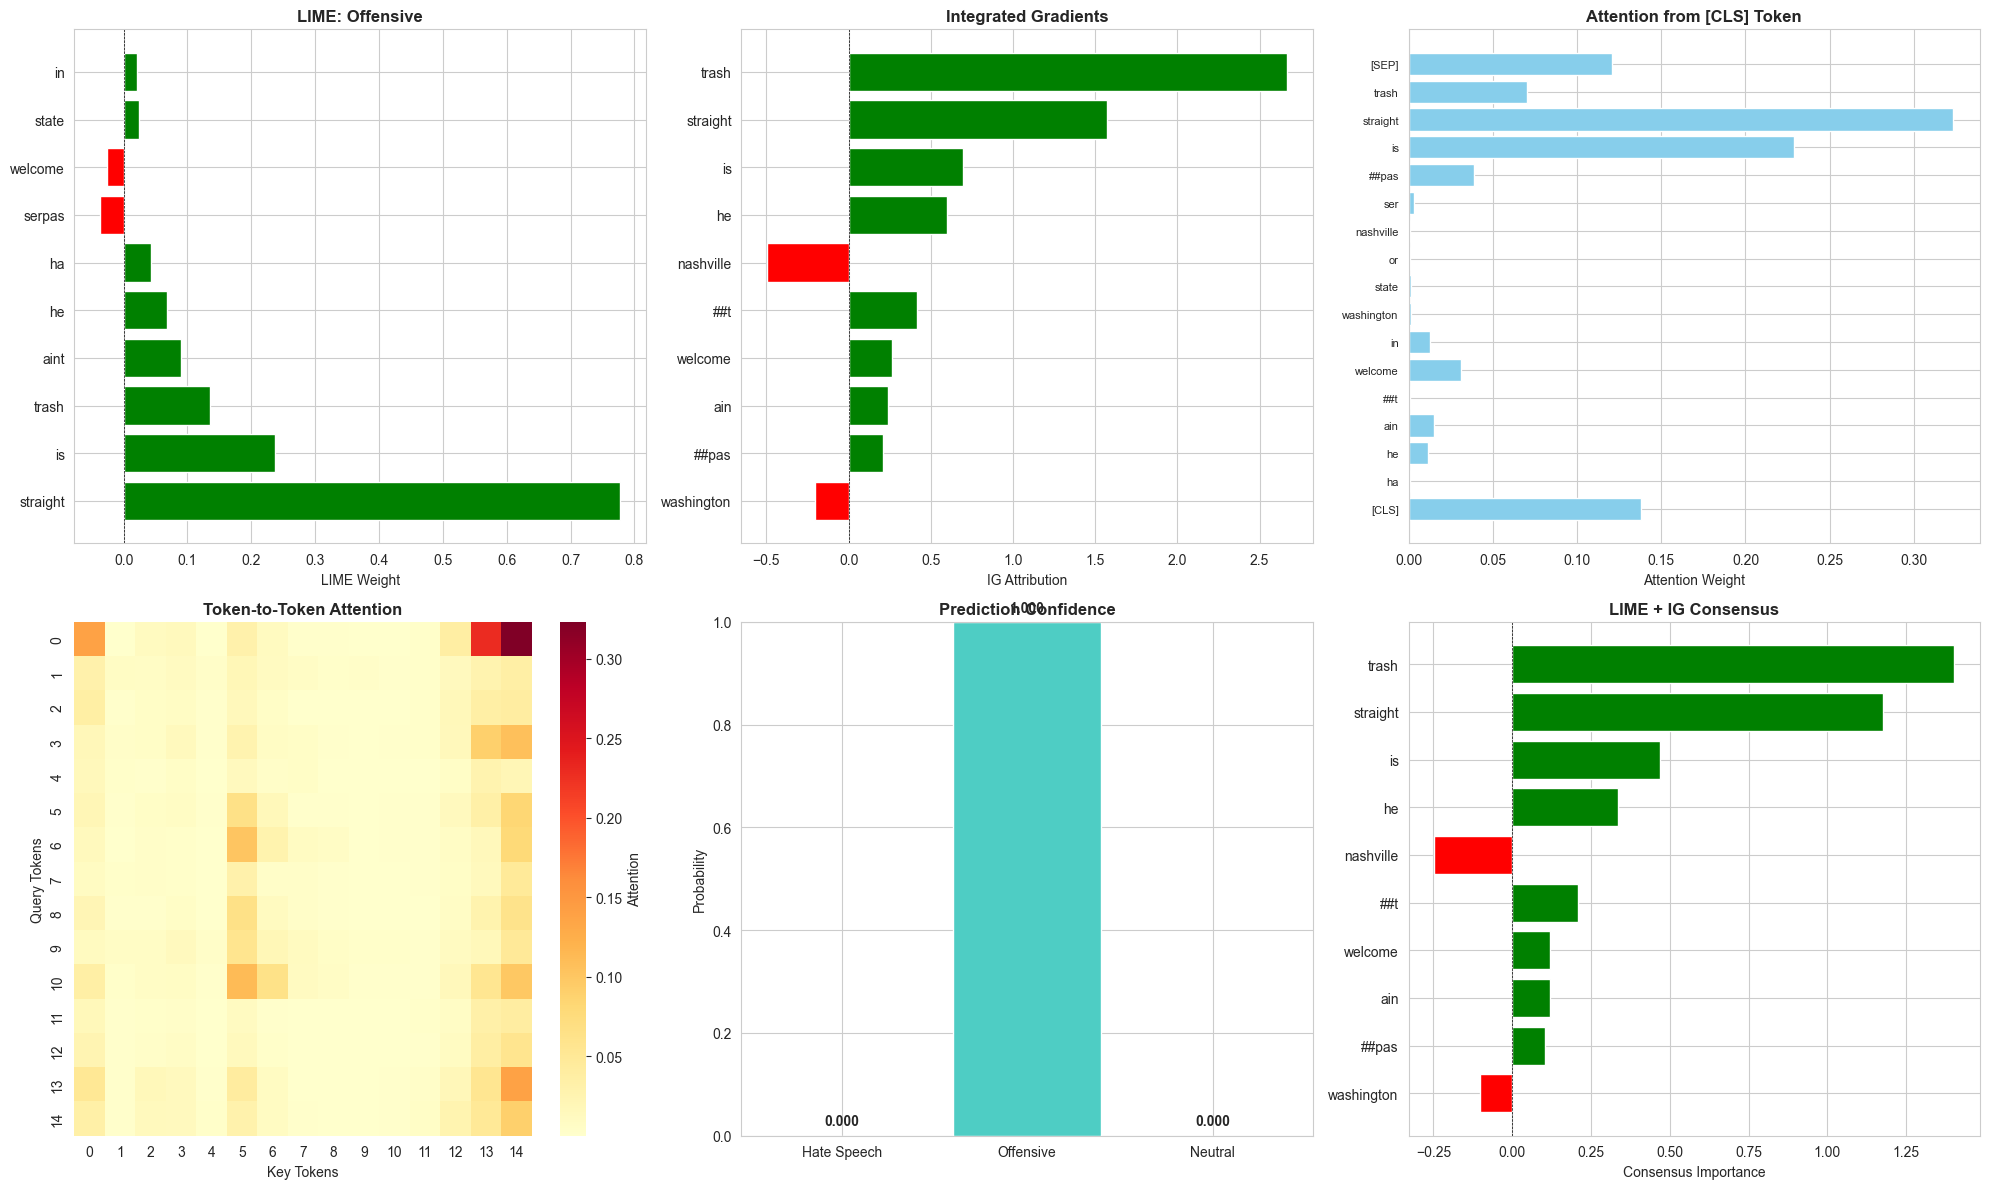


--- Error Case 3 ---
Text: rt spits out animal cracker this doesnt even taste like hippo ...
True: Neutral | Predicted: Offensive

Comprehensive Explanation: bert-base-uncased
Text: rt spits out animal cracker this doesnt even taste like hippo
Target Class: Offensive

Prediction: Offensive (0.603)
Probabilities:
  Hate Speech: 0.001
  Offensive: 0.603
  Neutral: 0.396

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_2.png


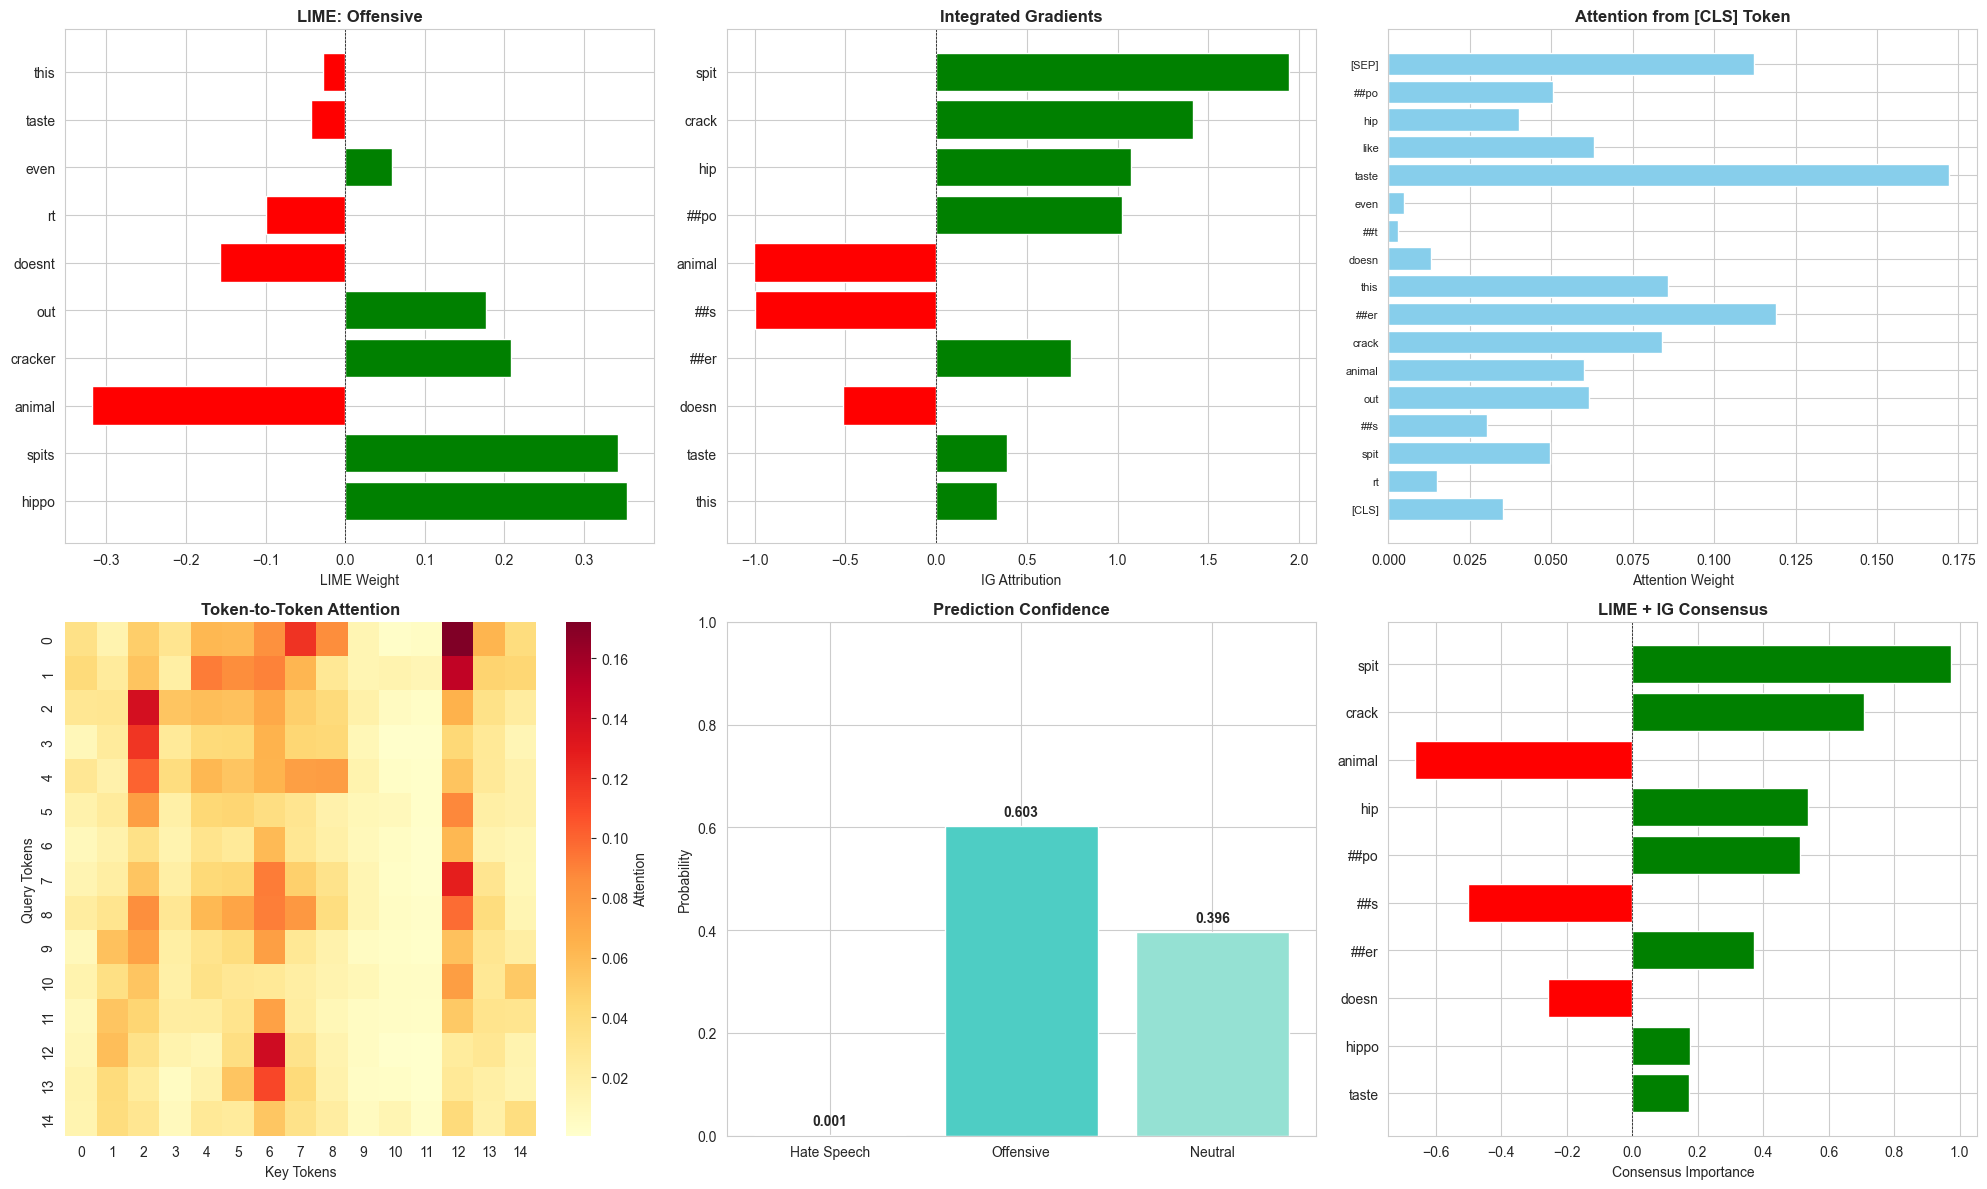


--- Error Case 4 ---
Text: prairie nigger ...
True: Offensive | Predicted: Hate Speech

Comprehensive Explanation: bert-base-uncased
Text: prairie nigger
Target Class: Hate Speech

Prediction: Hate Speech (0.993)
Probabilities:
  Hate Speech: 0.993
  Offensive: 0.007
  Neutral: 0.000

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_3.png


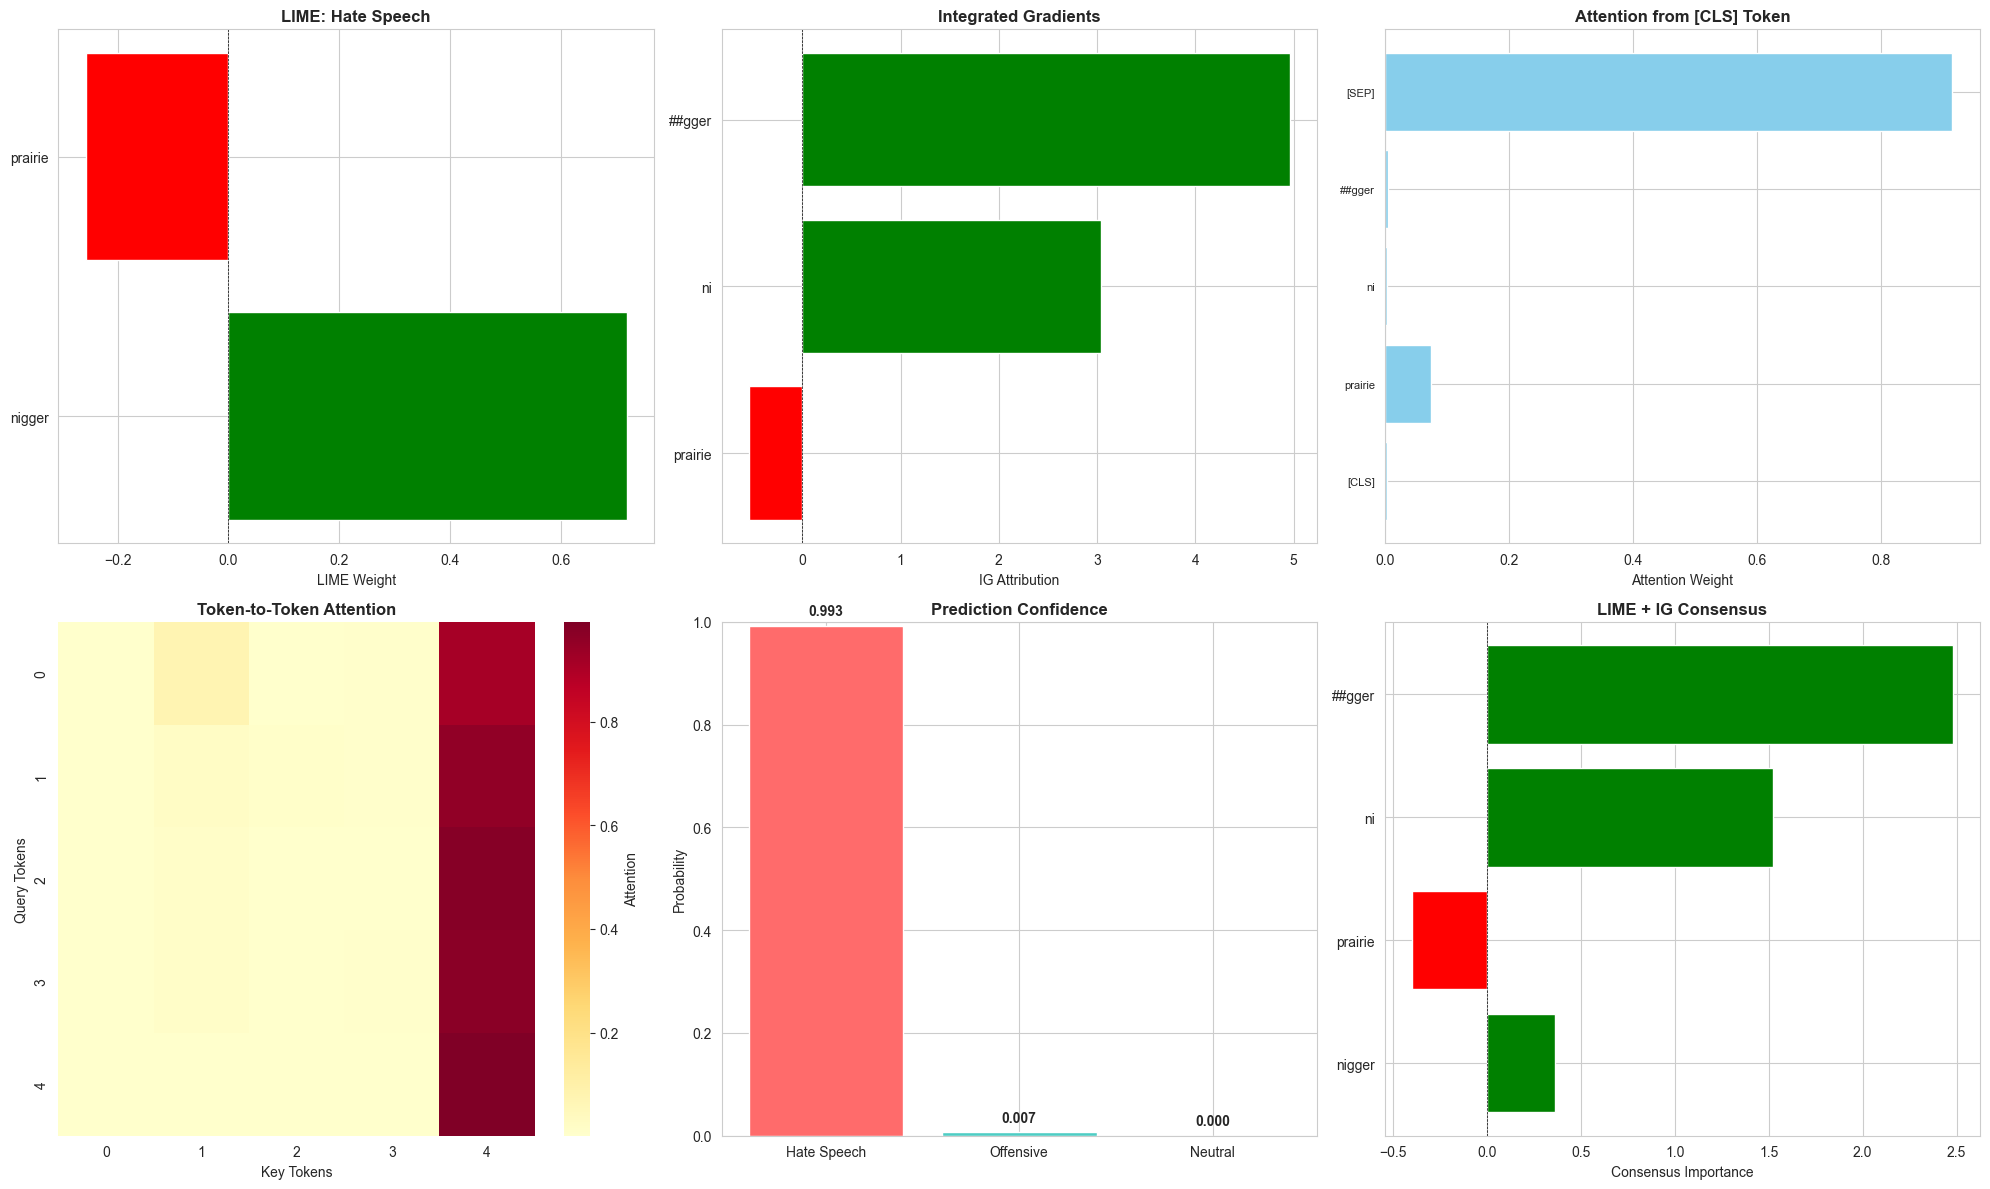


--- Error Case 5 ---
Text: rt follow this fag its his birthday today ...
True: Offensive | Predicted: Hate Speech

Comprehensive Explanation: bert-base-uncased
Text: rt follow this fag its his birthday today
Target Class: Hate Speech

Prediction: Hate Speech (0.996)
Probabilities:
  Hate Speech: 0.996
  Offensive: 0.004
  Neutral: 0.000

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_4.png


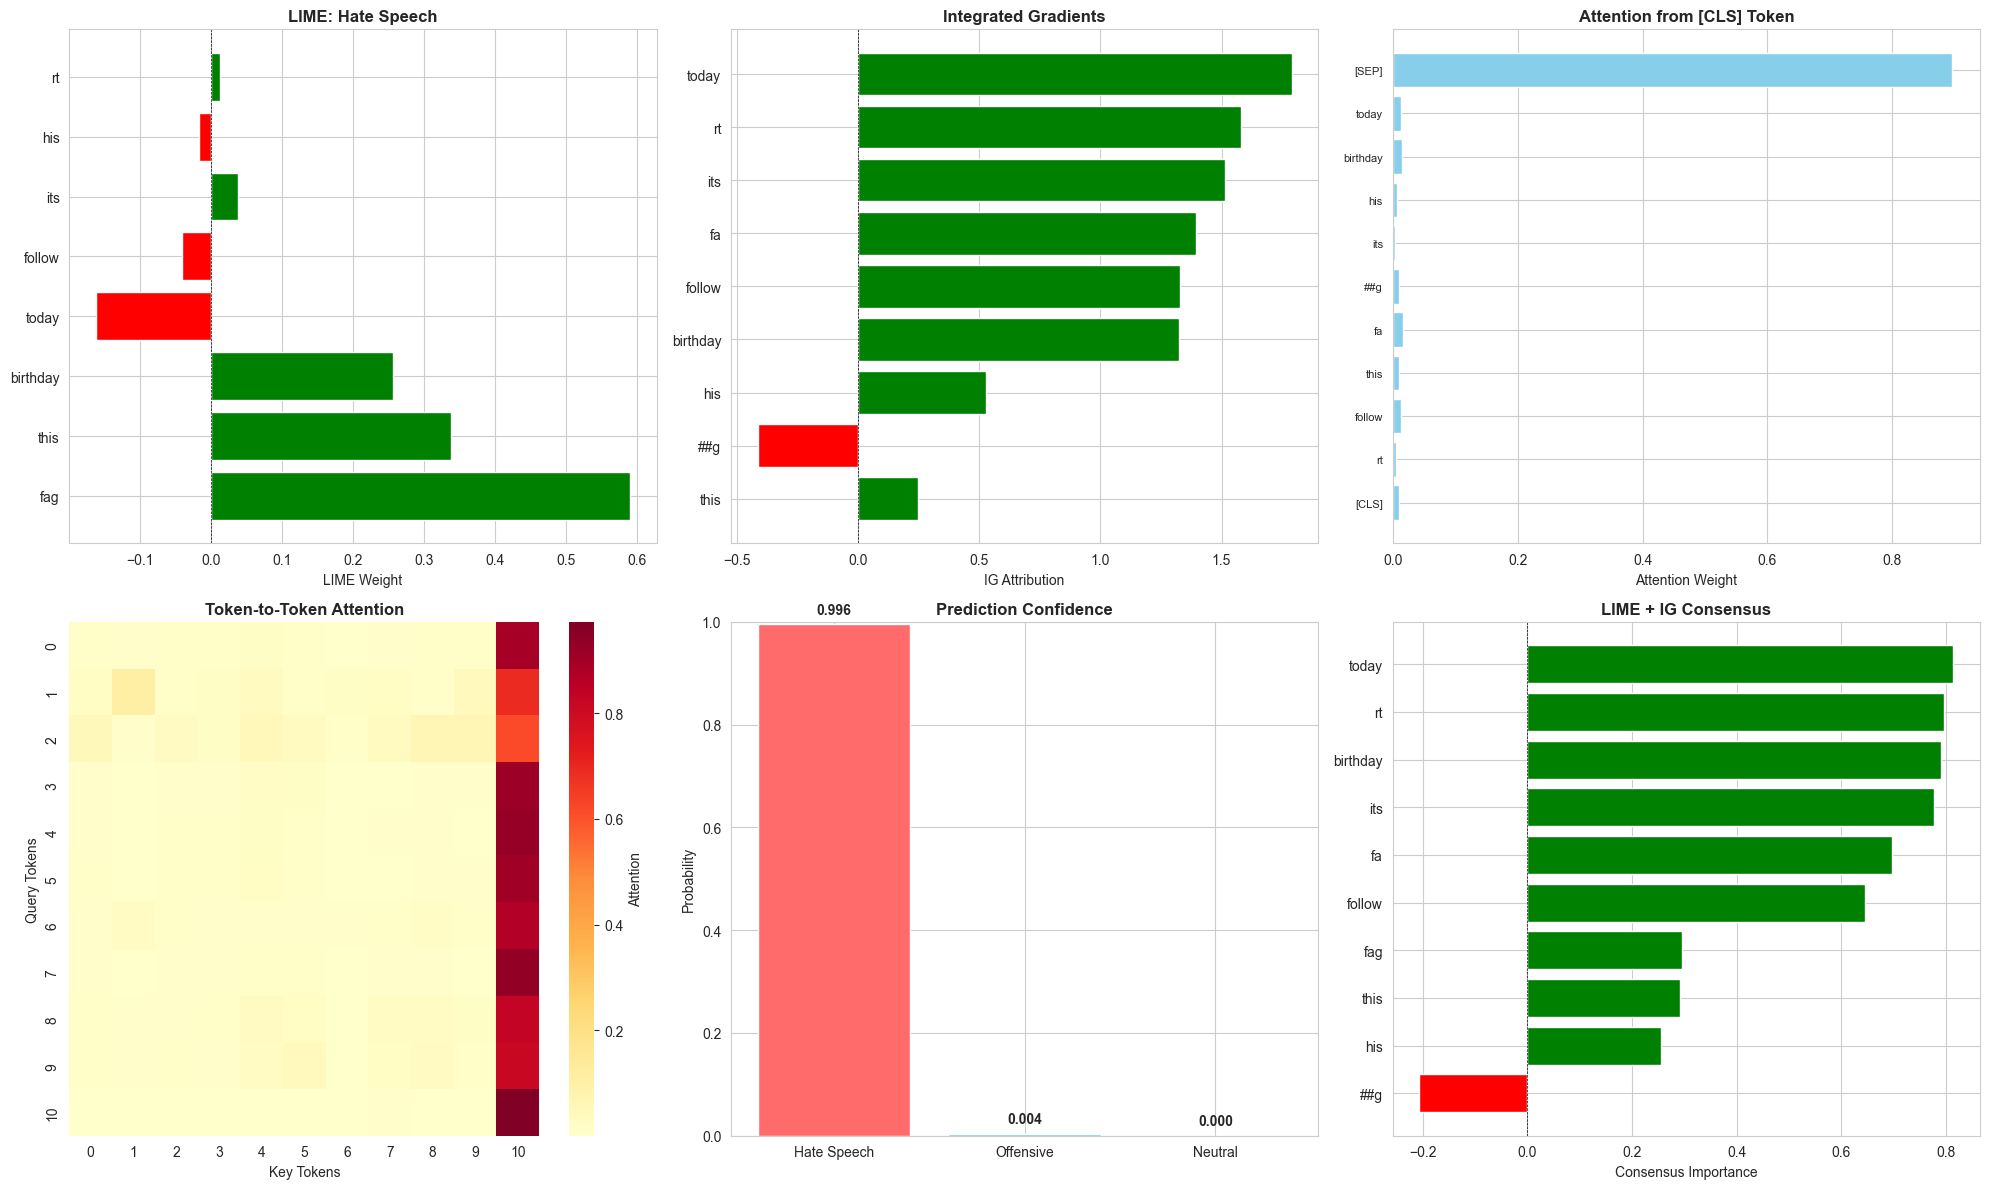


--- Error Case 6 ---
Text: i be like nigga yous a real mark ass bitch for that lol ...
True: Offensive | Predicted: Hate Speech

Comprehensive Explanation: bert-base-uncased
Text: i be like nigga yous a real mark ass bitch for that lol
Target Class: Hate Speech

Prediction: Hate Speech (0.999)
Probabilities:
  Hate Speech: 0.999
  Offensive: 0.001
  Neutral: 0.000

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_5.png


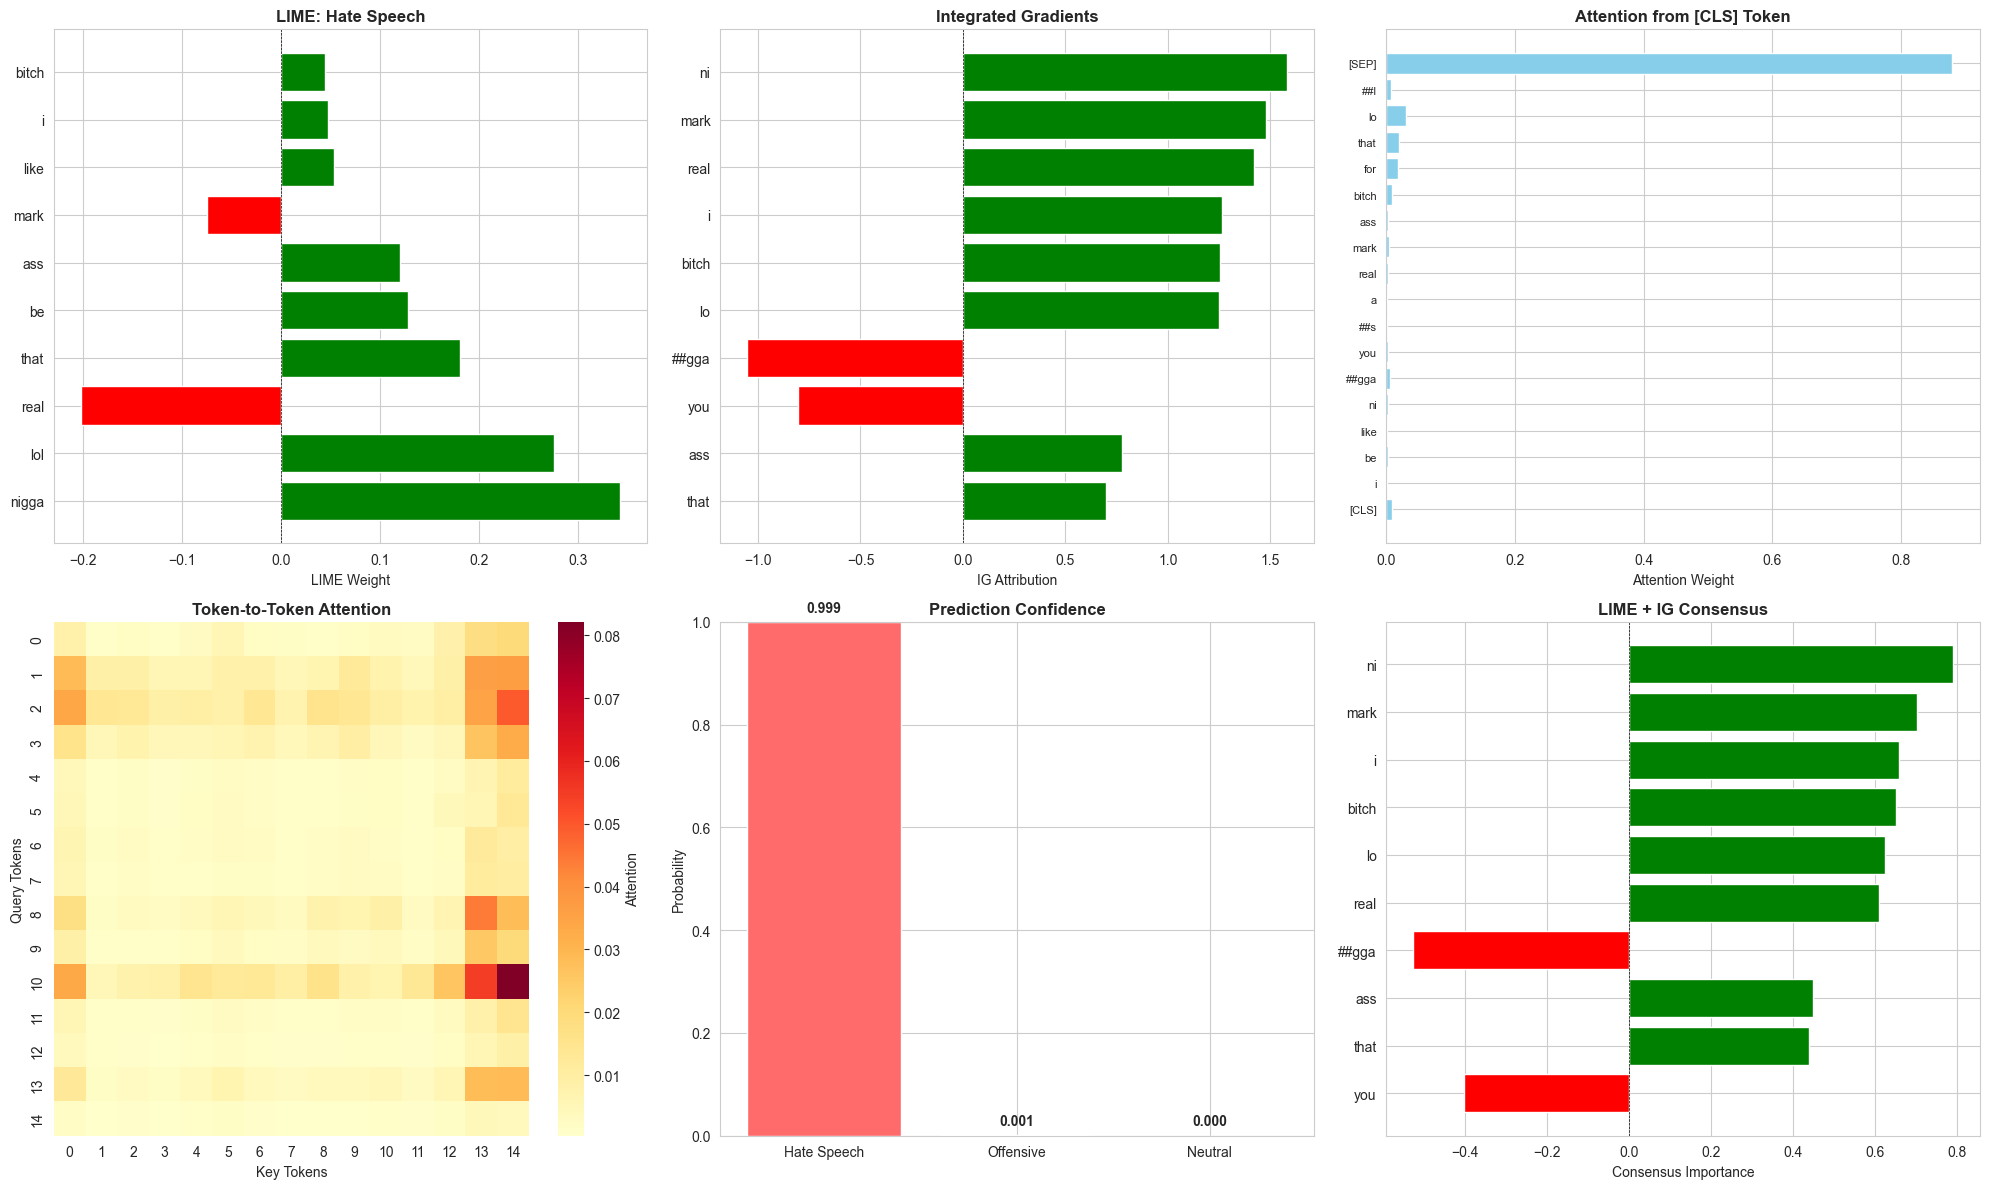


--- Error Case 7 ---
Text: im just saying in your twitter pic you look like such a guido and i love it ...
True: Offensive | Predicted: Neutral

Comprehensive Explanation: bert-base-uncased
Text: im just saying in your twitter pic you look like such a guido and i love it
Target Class: Neutral

Prediction: Neutral (0.996)
Probabilities:
  Hate Speech: 0.000
  Offensive: 0.004
  Neutral: 0.996

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_6.png


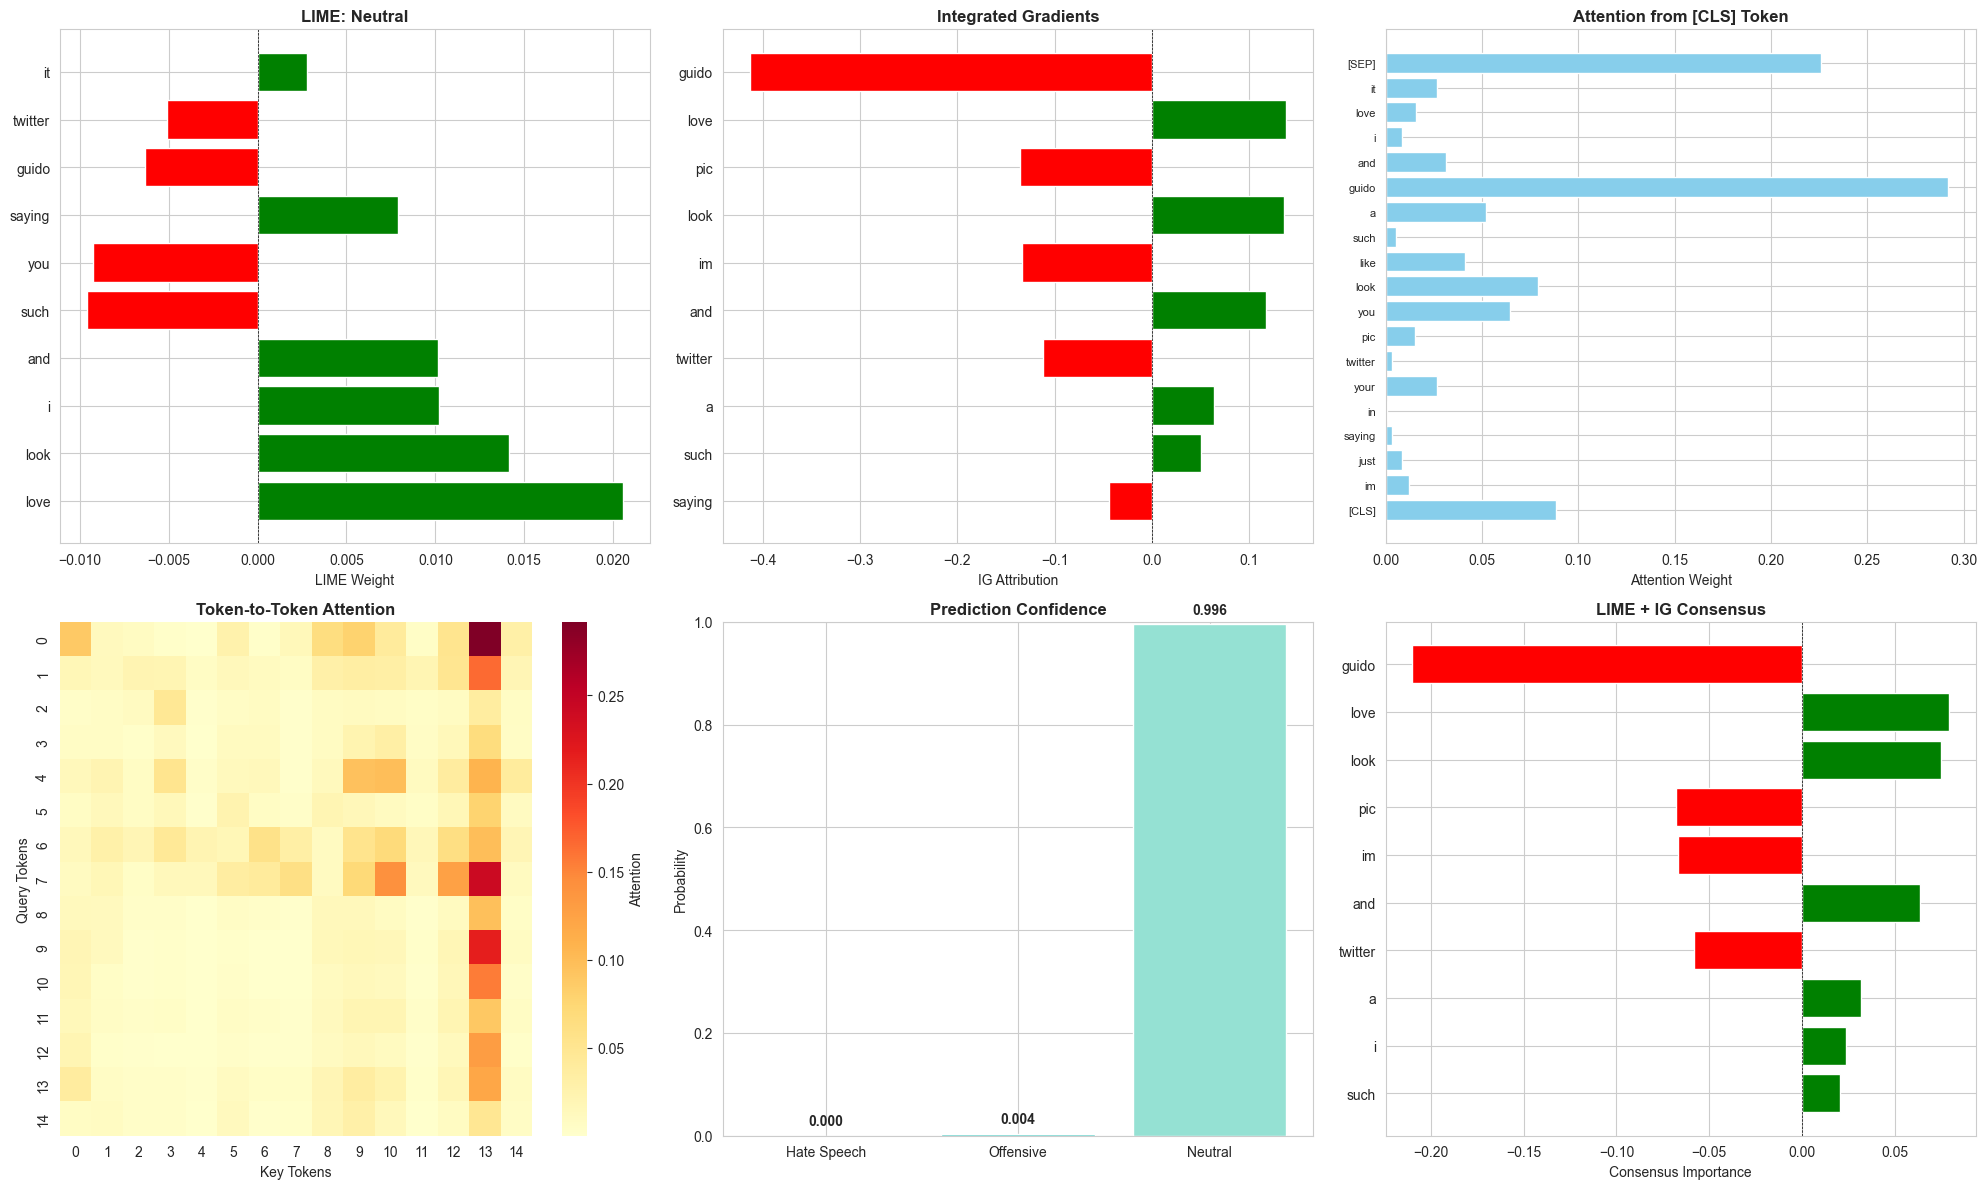


--- Error Case 8 ---
Text: rt supp wigga ...
True: Offensive | Predicted: Neutral

Comprehensive Explanation: bert-base-uncased
Text: rt supp wigga
Target Class: Neutral

Prediction: Neutral (0.585)
Probabilities:
  Hate Speech: 0.006
  Offensive: 0.409
  Neutral: 0.585

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_7.png


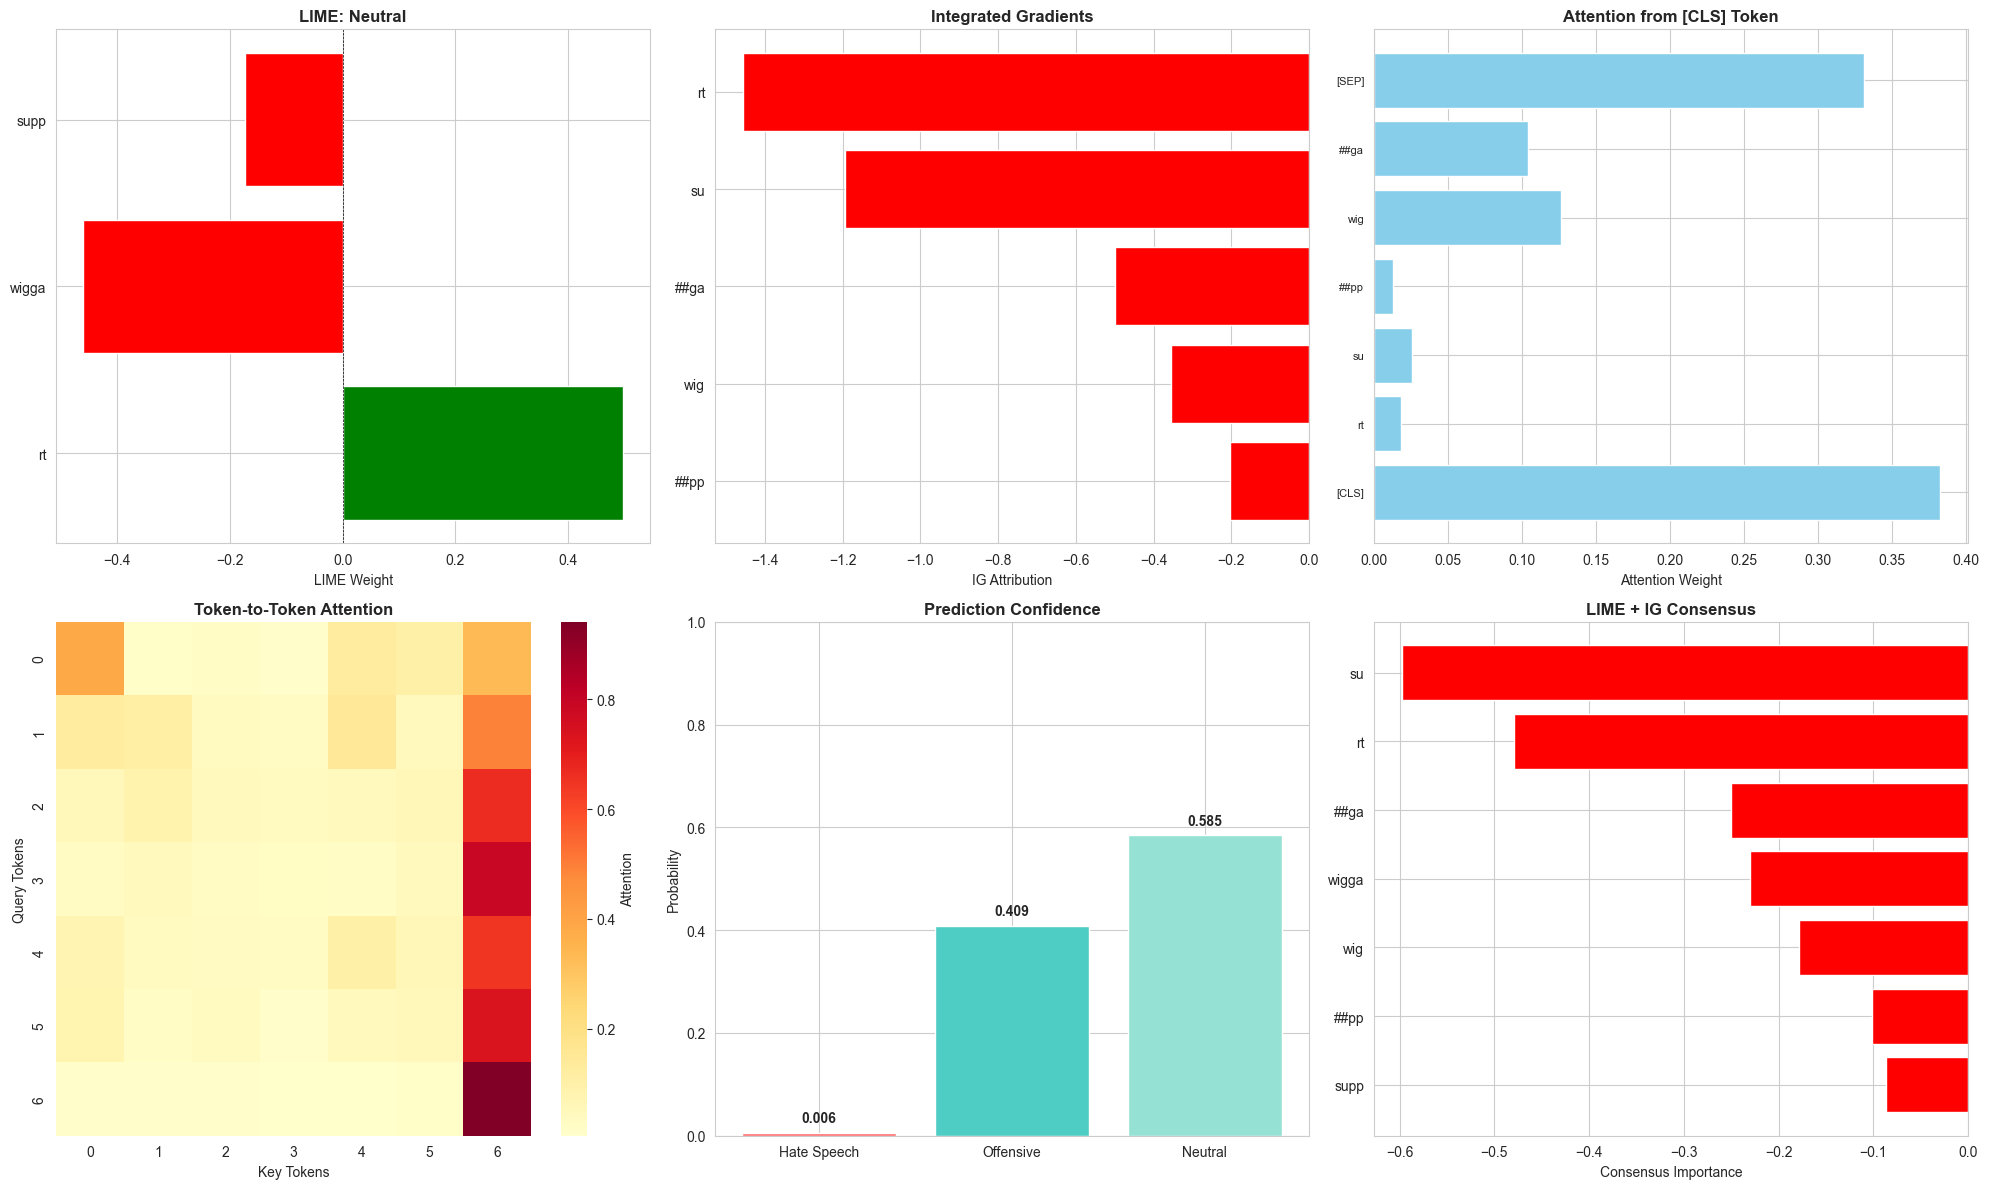


--- Error Case 9 ---
Text: because of the message that sends to lgbtq residents in the state not as if west virginia is a paradise for queer people today is major ...
True: Offensive | Predicted: Neutral

Comprehensive Explanation: bert-base-uncased
Text: because of the message that sends to lgbtq residents in the state not as if west virginia is a paradise for queer people today is major
Target Class: Neutral

Prediction: Neutral (0.943)
Probabilities:
  Hate Speech: 0.004
  Offensive: 0.053
  Neutral: 0.943

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_8.png


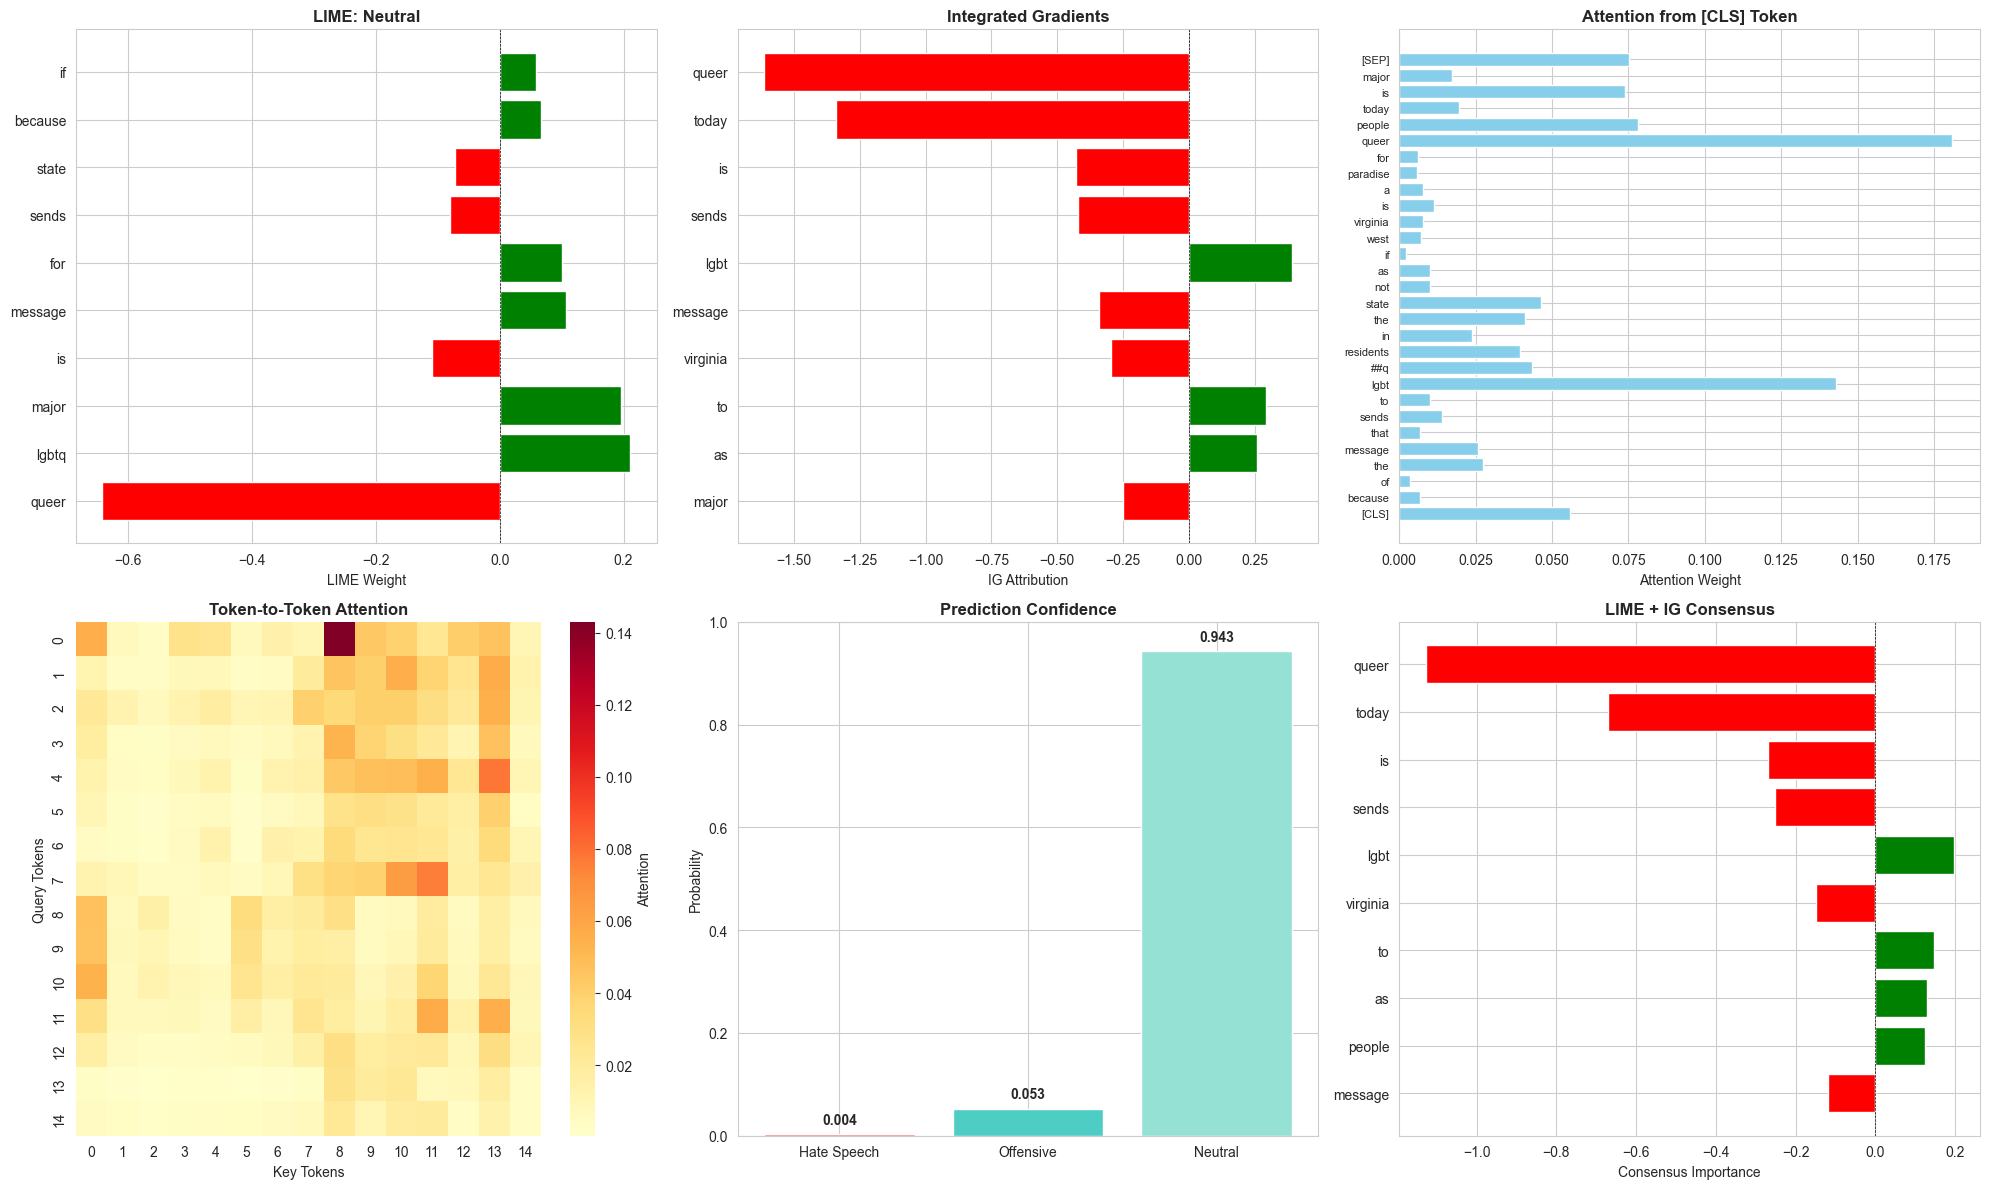


--- Error Case 10 ---
Text: rino trash like see conservatives as the democrat party see blacks as their slave property ...
True: Hate Speech | Predicted: Neutral

Comprehensive Explanation: bert-base-uncased
Text: rino trash like see conservatives as the democrat party see blacks as their slave property
Target Class: Neutral

Prediction: Neutral (0.596)
Probabilities:
  Hate Speech: 0.261
  Offensive: 0.143
  Neutral: 0.596

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to error_explain_bert-base-uncased_9.png


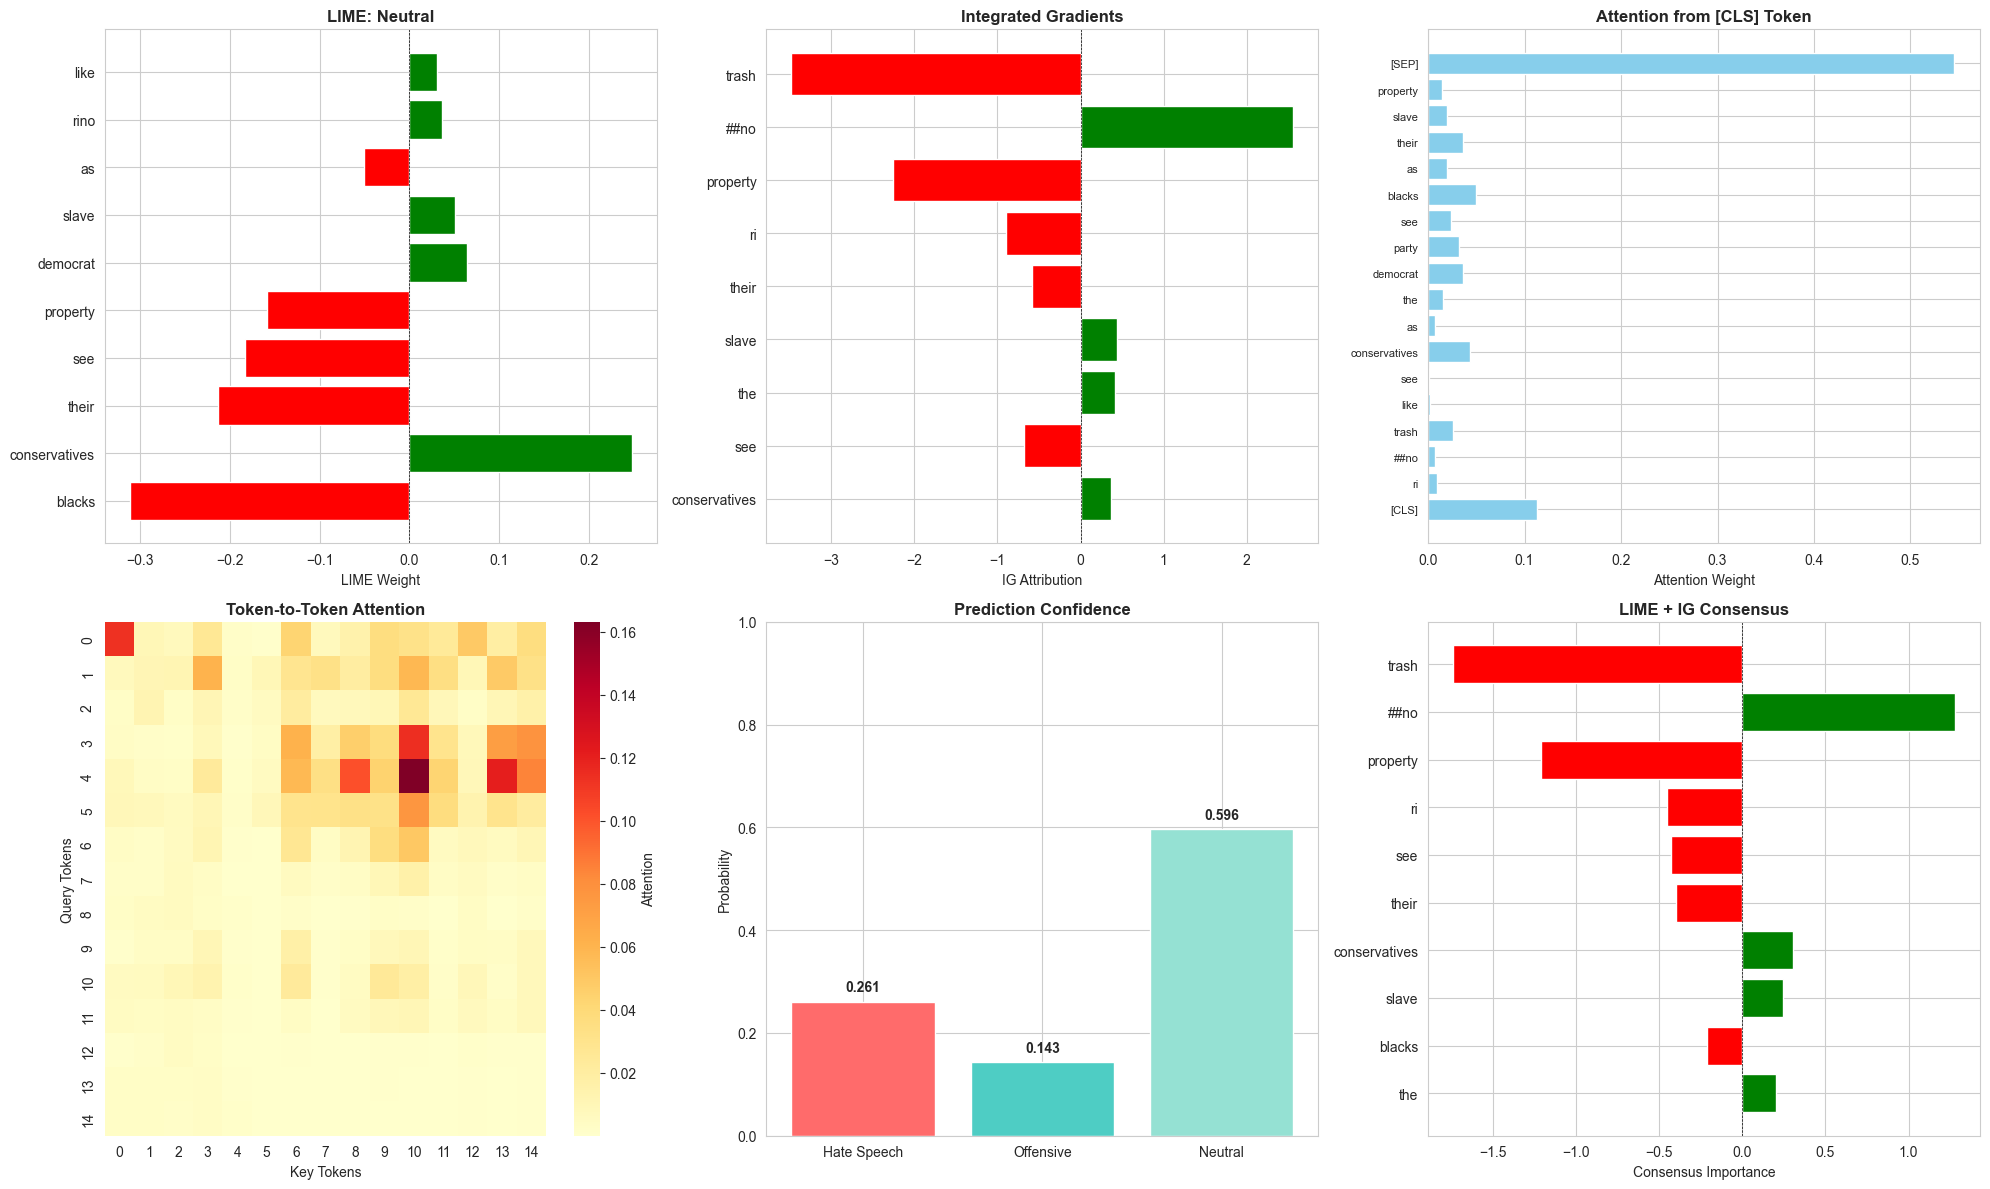


✓ Misclassification explainability completed for BOTH Original & SMOTE models


In [15]:
# =====================================================================
# Cell 13: Error Analysis WITH EXPLAINABILITY (ORIGINAL + SMOTE)
# =====================================================================

def analyze_misclassifications_with_explanations(model_name, model_data, test_df_variant, num_samples=20):
    """Analyze misclassifications and generate explainability plots for them."""
    
    print(f"\n{'='*70}")
    print(f"Misclassification Analysis: {model_name}")
    print(f"{'='*70}")
    
    model = model_data['model']
    tokenizer = model_data['tokenizer']
    predictions = model_data['predictions']
    true_labels = model_data['true_labels']
    
    # ---- find misclassified samples ----
    misclassified_indices = np.where(predictions != true_labels)[0]
    
    print(f"\nTotal misclassifications: {len(misclassified_indices)} / {len(predictions)}")
    print(f"Error rate: {len(misclassified_indices) / len(predictions) * 100:.2f}%")
    
    # ---- error type breakdown ----
    error_types = defaultdict(list)
    for idx in misclassified_indices:
        true_label = true_labels[idx]
        pred_label = predictions[idx]
        error_types[f"{true_label}→{pred_label}"].append(idx)
    
    print("\n--- Error Type Distribution ---")
    for etype, idxs in sorted(error_types.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"{etype}: {len(idxs)}")
    
    # ---- explainability ----
    class_names = ["Hate Speech", "Offensive", "Neutral"]
    explainer = UnifiedExplainer(model, tokenizer, model_name, class_names)
    
    # Sample some errors from each error type (max 3 each)
    sampled_errors = []
    for etype, idxs in error_types.items():
        sample_size = min(3, len(idxs))
        sampled = np.random.choice(idxs, sample_size, replace=False)
        sampled_errors.extend(sampled)
    
    sampled_errors = sampled_errors[:num_samples]
    
    results = []
    
    for i, idx in enumerate(sampled_errors):
        text = test_df_variant.iloc[idx]["text"]
        true_label = true_labels[idx]
        pred_label = predictions[idx]
        
        print(f"\n--- Error Case {i+1} ---")
        print(f"Text: {text[:200]} ...")
        print(f"True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")
        
        explanation = explainer.comprehensive_explain(
            text,
            target_class=pred_label,
            save_path=f"error_explain_{model_name.replace('/', '_')}_{i}.png"
        )
        
        
        results.append({
            "text": text,
            "true_label": true_label,
            "predicted_label": pred_label,
            "probabilities": explanation["probabilities"],
            "lime_explanation": explanation["lime_explanation"]
        })
    
    return results, error_types


# =====================================================================
# RUN MISCLASSIFICATION ANALYSIS FOR BOTH ORIGINAL + SMOTE
# =====================================================================

print("\n" + "="*90)
print("ERROR + EXPLAINABILITY ANALYSIS — ORIGINAL DATASET")
print("="*90)

best_original = max(
    all_results_original,
    key=lambda m: all_results_original[m]['eval_metrics']['eval_f1']
)

print(f"Best Original Model: {best_original}")

error_analysis_original, error_distribution_original = analyze_misclassifications_with_explanations(
    best_original,
    trained_models_original[best_original],
    trained_models_original[best_original]['test_df'],
    num_samples=10
)


print("\n" + "="*90)
print("ERROR + EXPLAINABILITY ANALYSIS — SMOTE DATASET")
print("="*90)

best_smote = max(
    all_results_smote,
    key=lambda m: all_results_smote[m]['eval_metrics']['eval_f1']
)

print(f"Best SMOTE Model: {best_smote}")

error_analysis_smote, error_distribution_smote = analyze_misclassifications_with_explanations(
    best_smote,
    trained_models_smote[best_smote],
    trained_models_smote[best_smote]['test_df'],
    num_samples=10
)

print("\n✓ Misclassification explainability completed for BOTH Original & SMOTE models")



EXPLAINABILITY COMPARISON — ORIGINAL DATASET

Analyzing: rt stfu hoe rt im proud to be african american proud african american im proud t...

Comprehensive Explanation: bert-base-uncased
Text: rt stfu hoe rt im proud to be african american proud african american im proud to be white racist
Target Class: Hate Speech

Prediction: Offensive (0.899)
Probabilities:
  Hate Speech: 0.096
  Offensive: 0.899
  Neutral: 0.005

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...


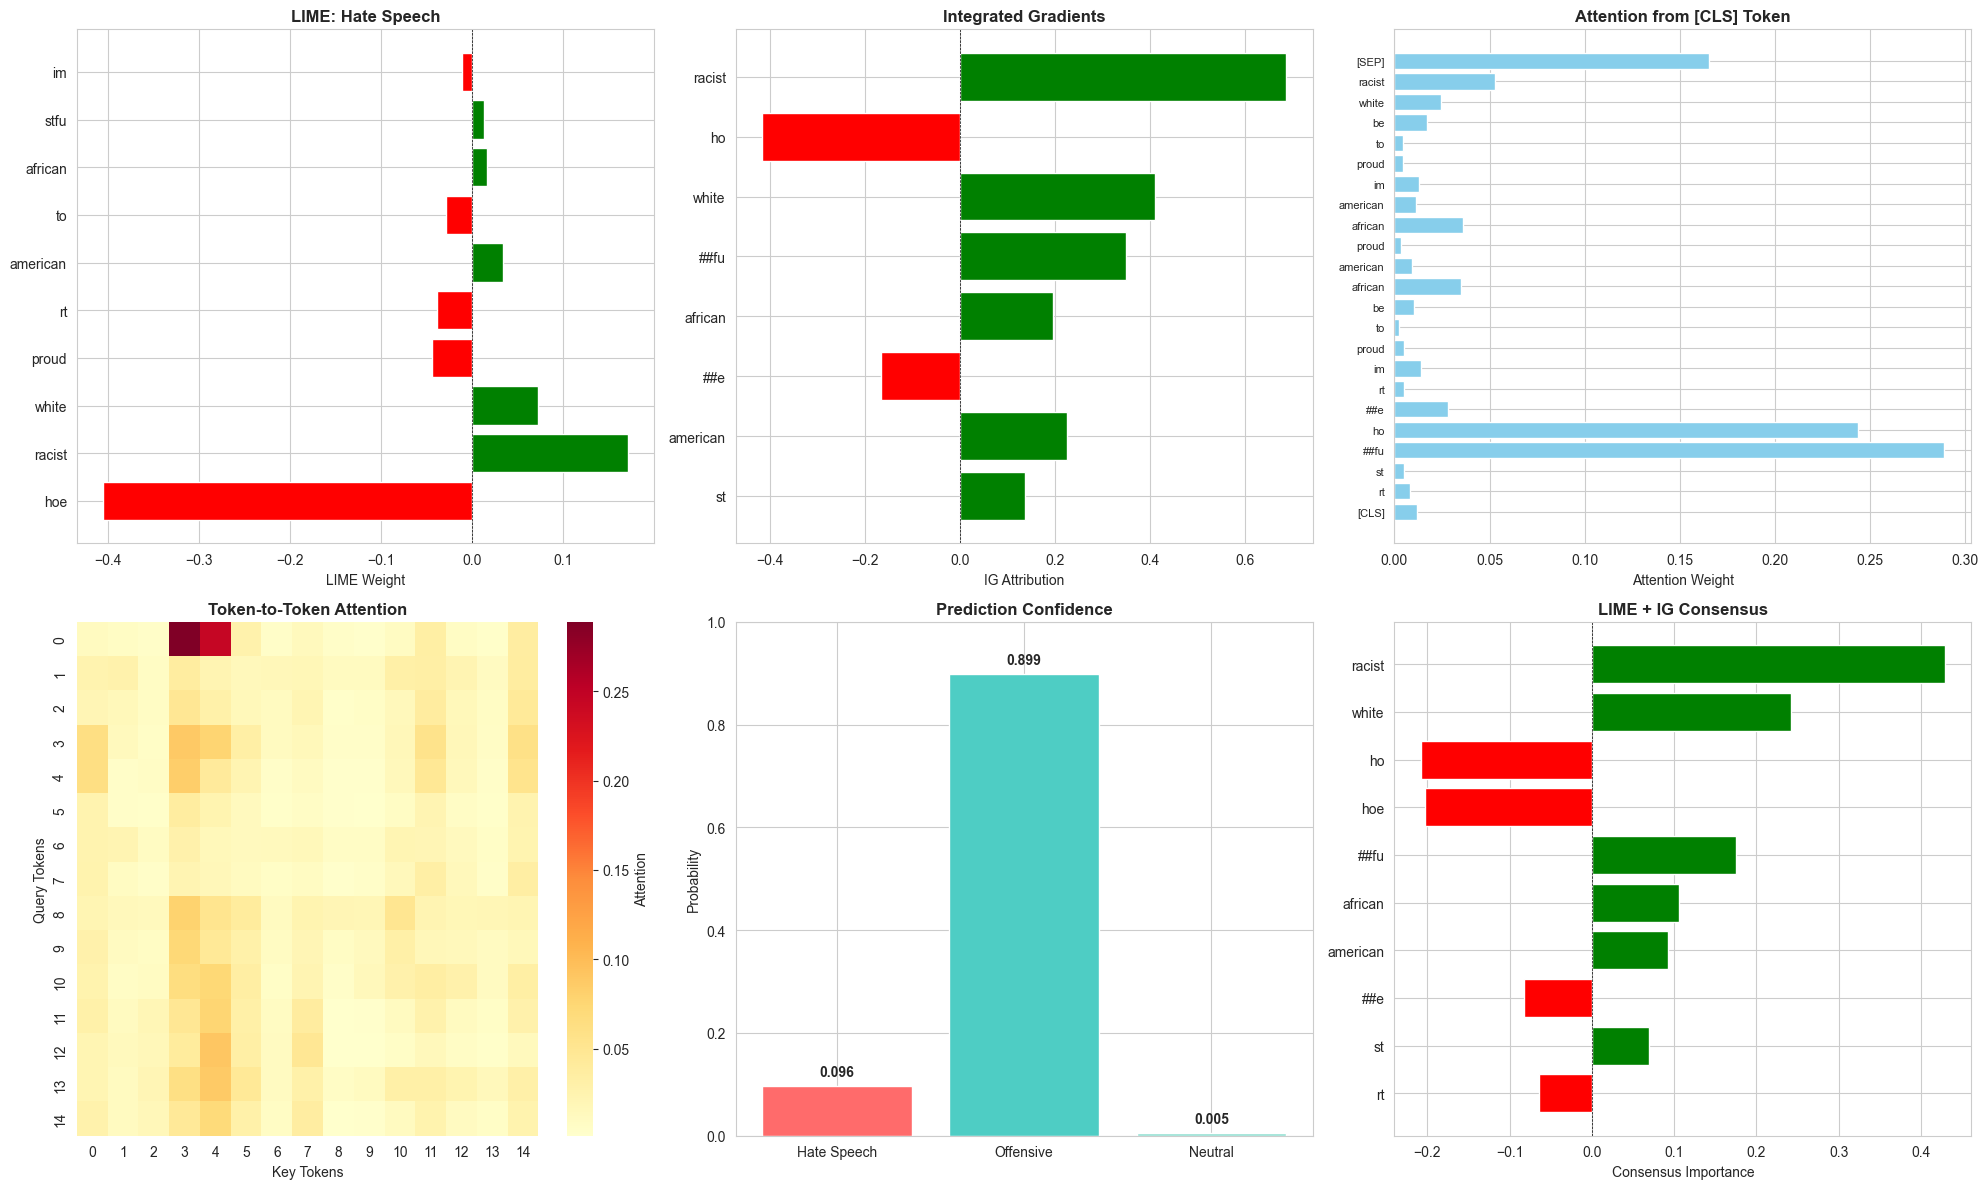


Analyzing: rt there is a gift shop at the museum and they charge admission its a mass grave...

Comprehensive Explanation: bert-base-uncased
Text: rt there is a gift shop at the museum and they charge admission its a mass grave you fucking cunts what a disgrace
Target Class: Hate Speech

Prediction: Offensive (0.971)
Probabilities:
  Hate Speech: 0.028
  Offensive: 0.971
  Neutral: 0.001

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...


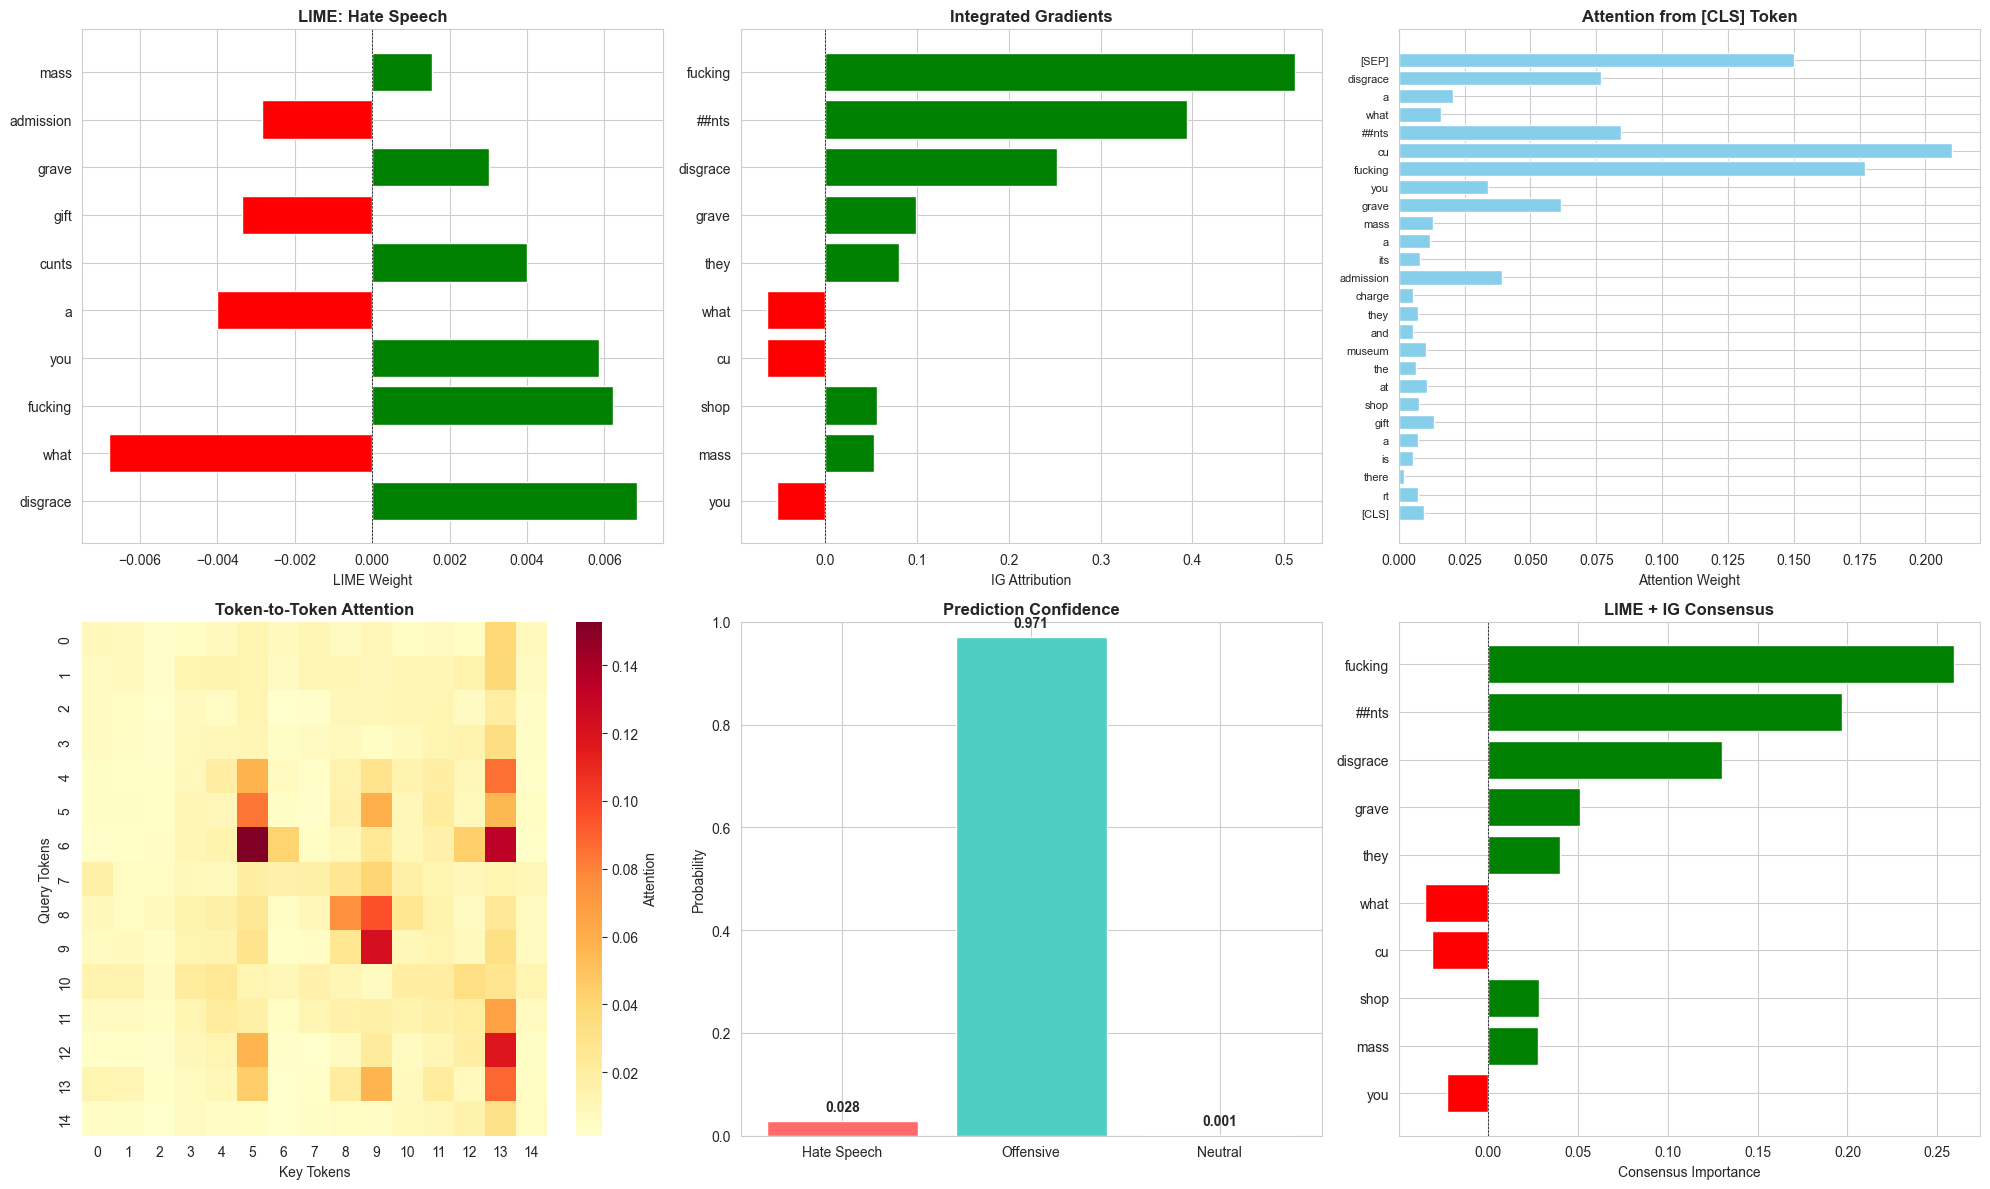


Analyzing: i need some red green amp yellow pants amp helly shirts express...

Comprehensive Explanation: bert-base-uncased
Text: i need some red green amp yellow pants amp helly shirts express
Target Class: Hate Speech

Prediction: Neutral (0.614)
Probabilities:
  Hate Speech: 0.037
  Offensive: 0.350
  Neutral: 0.614

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...


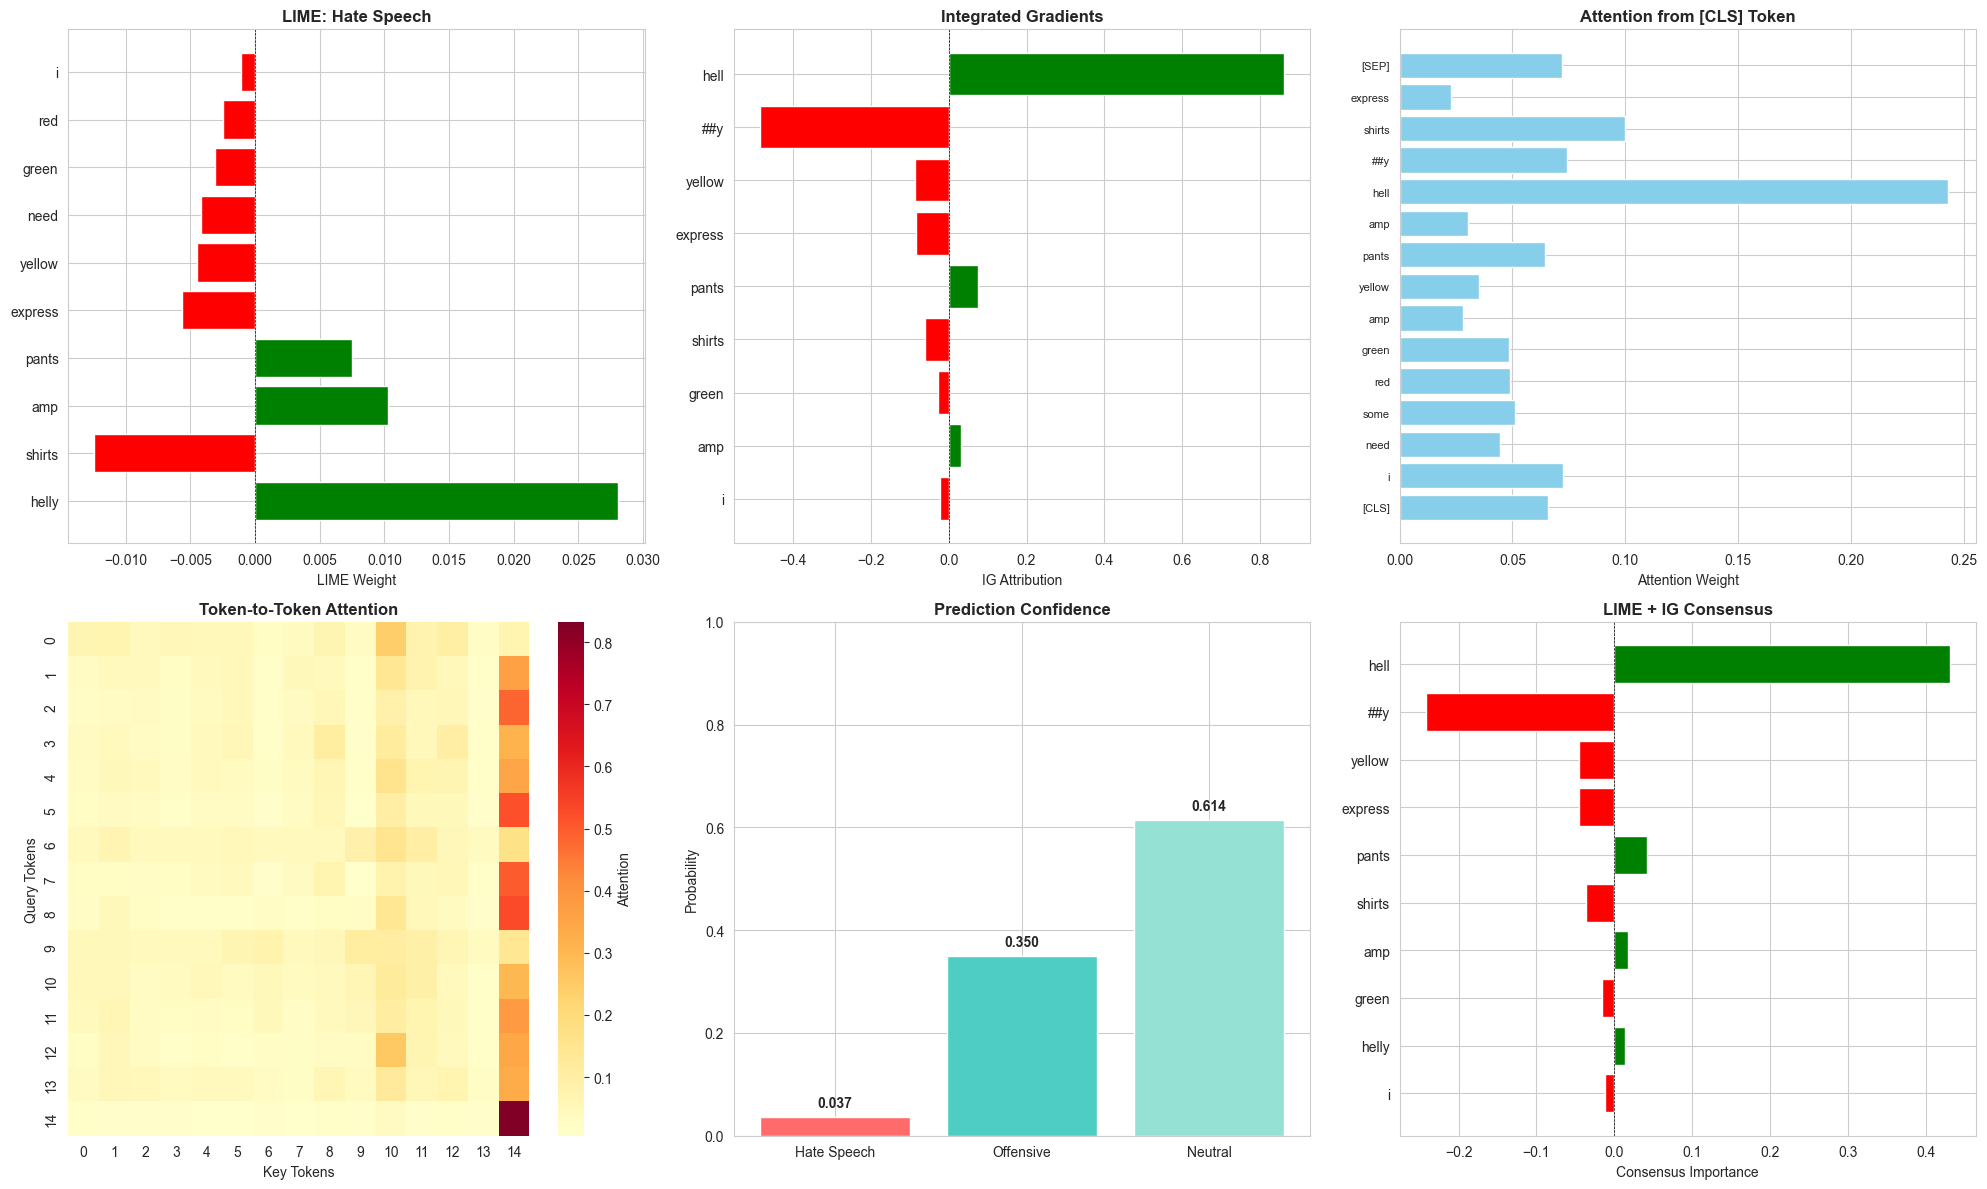


EXPLAINABILITY METHOD COMPARISON

Average LIME-IG Consistency: 0.133

EXPLAINABILITY COMPARISON — SMOTE DATASET

Analyzing: rt stfu hoe rt im proud to be african american proud african american im proud t...

Comprehensive Explanation: bert-base-uncased
Text: rt stfu hoe rt im proud to be african american proud african american im proud to be white racist
Target Class: Hate Speech

Prediction: Hate Speech (0.999)
Probabilities:
  Hate Speech: 0.999
  Offensive: 0.001
  Neutral: 0.000

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...


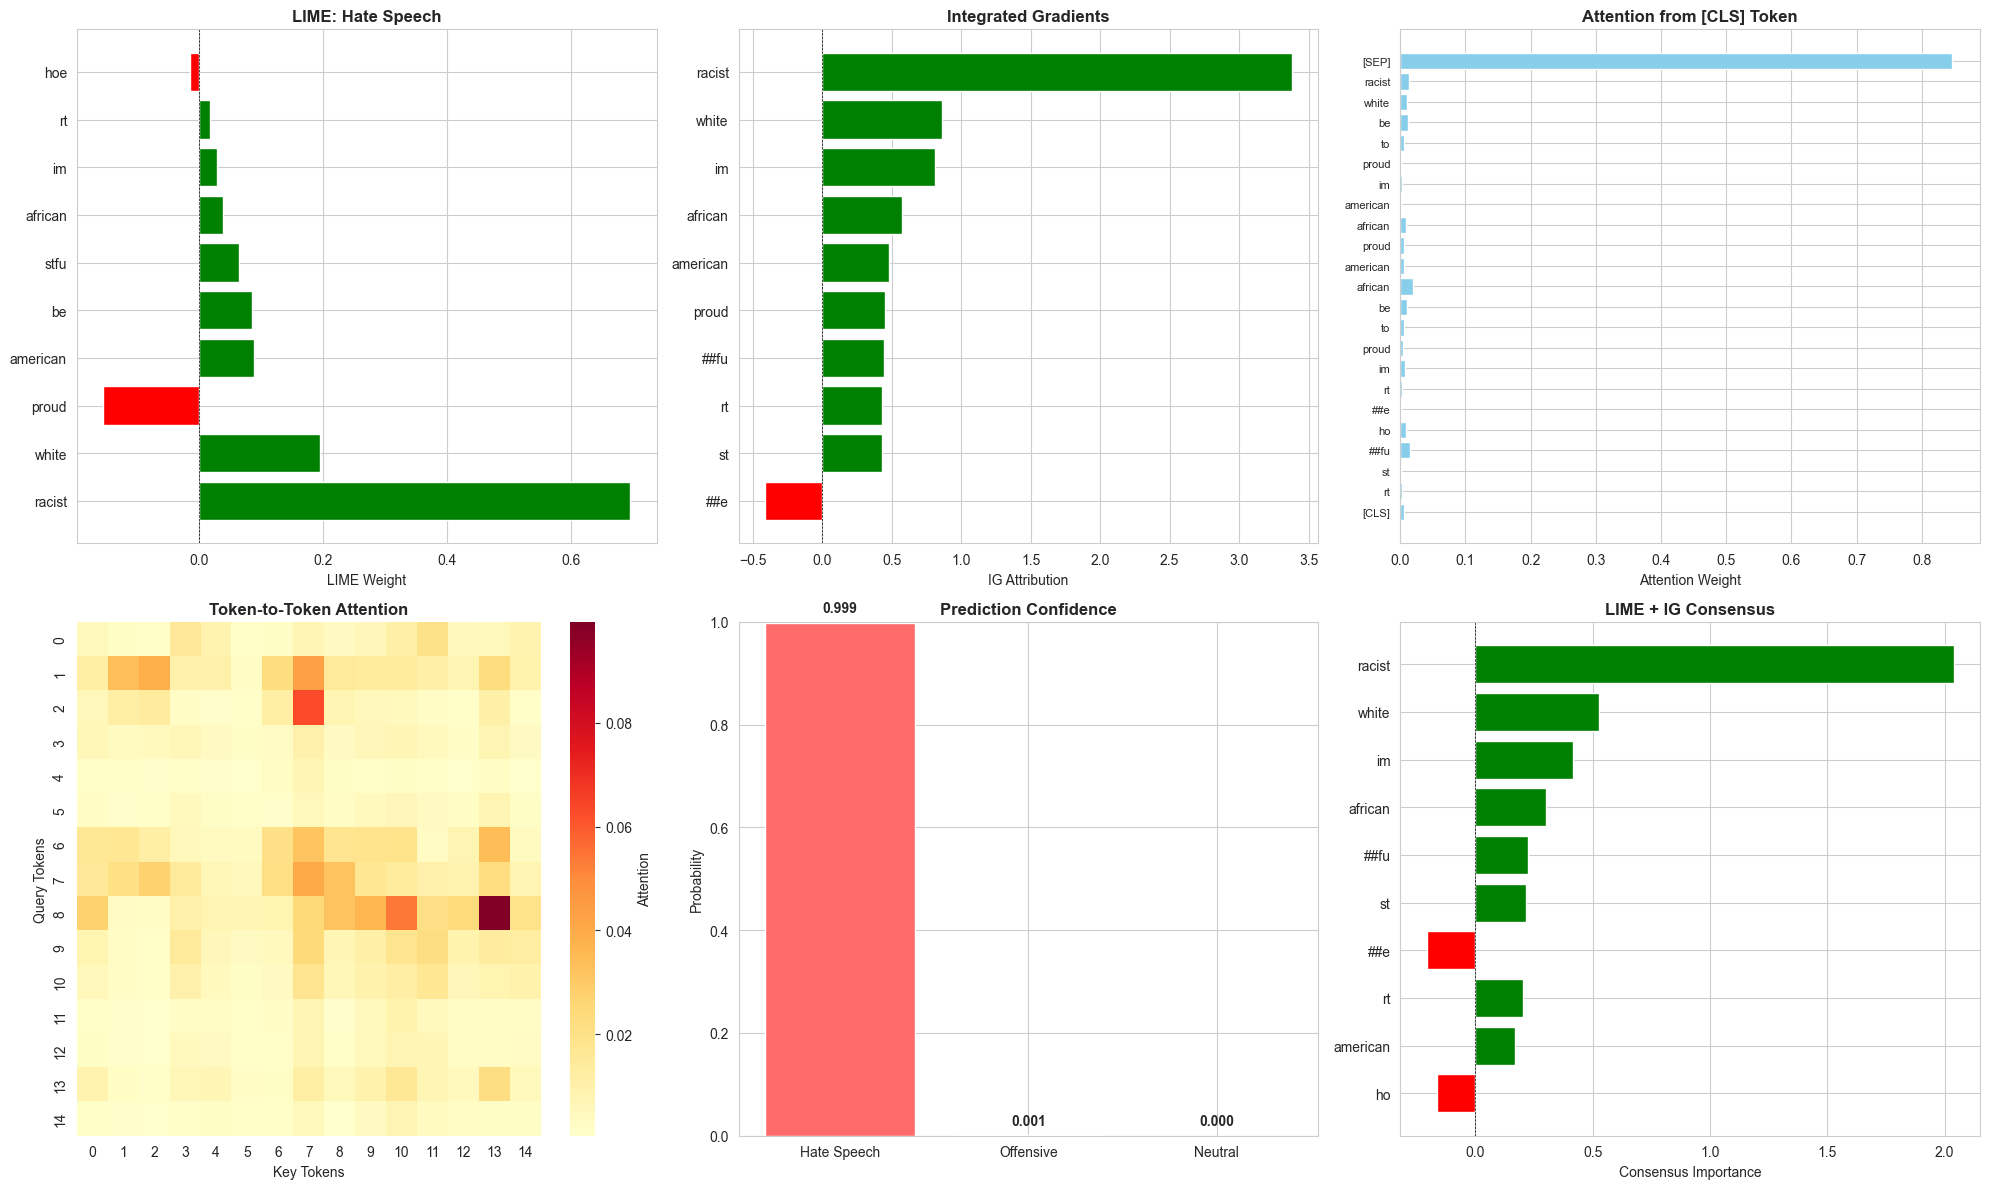


Analyzing: rt there is a gift shop at the museum and they charge admission its a mass grave...

Comprehensive Explanation: bert-base-uncased
Text: rt there is a gift shop at the museum and they charge admission its a mass grave you fucking cunts what a disgrace
Target Class: Hate Speech

Prediction: Offensive (0.989)
Probabilities:
  Hate Speech: 0.010
  Offensive: 0.989
  Neutral: 0.000

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...


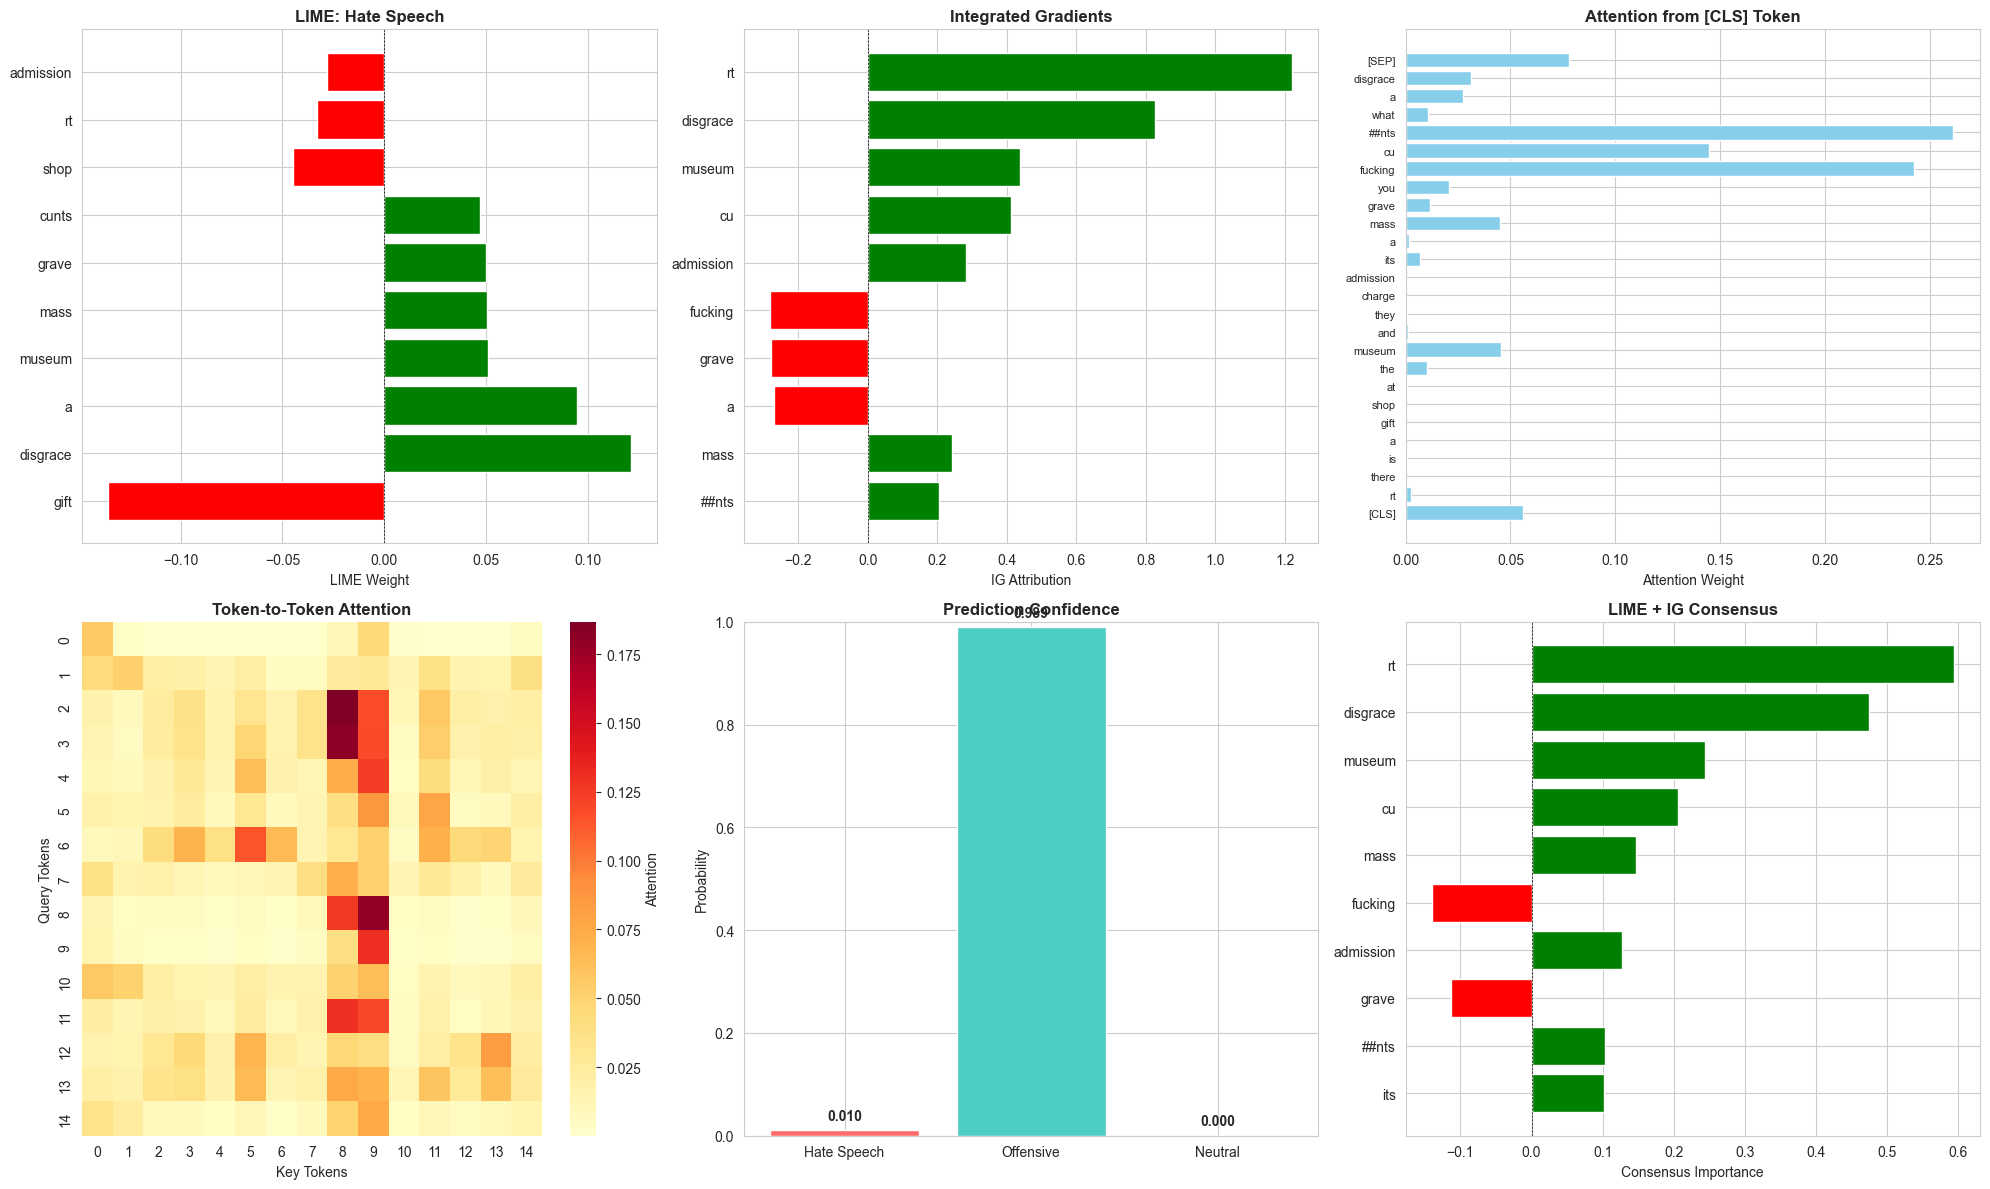


Analyzing: i need some red green amp yellow pants amp helly shirts express...

Comprehensive Explanation: bert-base-uncased
Text: i need some red green amp yellow pants amp helly shirts express
Target Class: Hate Speech

Prediction: Neutral (0.992)
Probabilities:
  Hate Speech: 0.000
  Offensive: 0.008
  Neutral: 0.992

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...


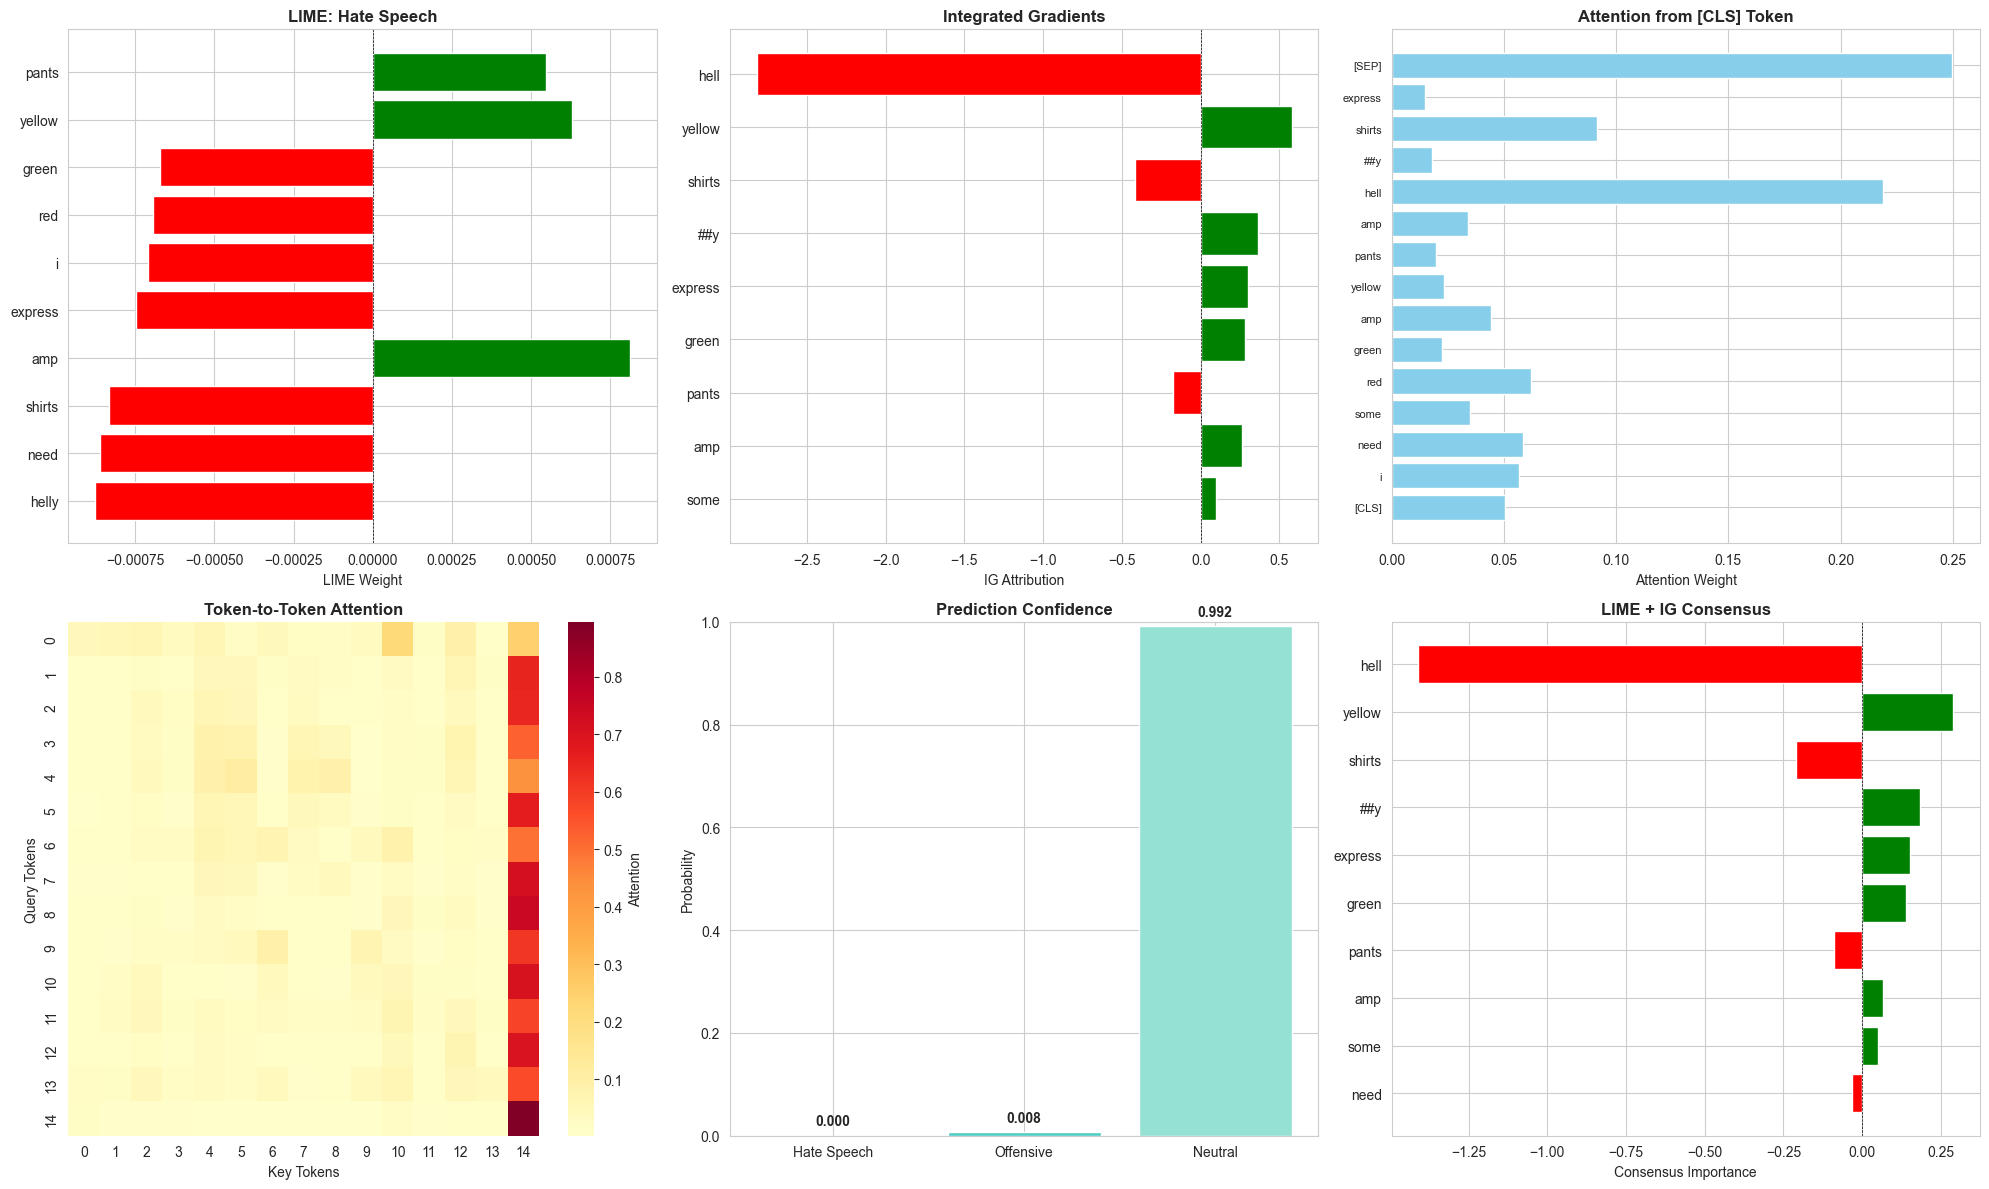


EXPLAINABILITY METHOD COMPARISON

Average LIME-IG Consistency: 0.200

✓ Explainability comparison completed for BOTH Original & SMOTE models


In [16]:
# =====================================================================
# Cell 14: Compare Explainability Methods (ORIGINAL + SMOTE)
# =====================================================================

def compare_explainability_methods(model_name, model_data, sample_texts, target_class=0):
    """Compare LIME, SHAP, IG, and Attention explanations"""
    
    model = model_data['model']
    tokenizer = model_data['tokenizer']
    class_names = ['Hate Speech', 'Offensive', 'Neutral']
    
    explainer = UnifiedExplainer(model, tokenizer, model_name, class_names)
    
    results = []
    
    for text in sample_texts:
        print(f"\nAnalyzing: {text[:80]}...")
        
        comprehensive_result = explainer.comprehensive_explain(
            text,
            target_class=target_class,
            save_path=None
        )
        
        results.append({
            'text': text,
            'prediction': comprehensive_result['prediction'],
            'probabilities': comprehensive_result['probabilities'],
            'explanations': comprehensive_result
        })
    
    print("\n" + "="*70)
    print("EXPLAINABILITY METHOD COMPARISON")
    print("="*70)
    
    consistency_scores = []
    for result in results:
        lime_top = set(list(result['explanations']['lime_explanation'].keys())[:5])
        ig_top = set(result['explanations']['ig_tokens'][:5])
        overlap = len(lime_top & ig_top)
        consistency_scores.append(overlap / 5.0)
    
    avg_consistency = np.mean(consistency_scores)
    print(f"\nAverage LIME-IG Consistency: {avg_consistency:.3f}")
    
    return results, avg_consistency



# =====================================================================
# Run Explainability Comparison for ORIGINAL
# =====================================================================

print("\n" + "="*90)
print("EXPLAINABILITY COMPARISON — ORIGINAL DATASET")
print("="*90)

best_original = max(
    all_results_original,
    key=lambda m: all_results_original[m]['eval_metrics']['eval_f1']
)

sample_texts_original = [
    trained_models_original[best_original]['test_df']
        .query("labels == 0").iloc[0]['text'],
    trained_models_original[best_original]['test_df']
        .query("labels == 1").iloc[0]['text'],
    trained_models_original[best_original]['test_df']
        .query("labels == 2").iloc[0]['text'],
]

explainability_comparison_original = compare_explainability_methods(
    best_original,
    trained_models_original[best_original],
    sample_texts_original
)



# =====================================================================
# Run Explainability Comparison for SMOTE
# =====================================================================

print("\n" + "="*90)
print("EXPLAINABILITY COMPARISON — SMOTE DATASET")
print("="*90)

best_smote = max(
    all_results_smote,
    key=lambda m: all_results_smote[m]['eval_metrics']['eval_f1']
)

sample_texts_smote = [
    trained_models_smote[best_smote]['test_df']
        .query("labels == 0").iloc[0]['text'],
    trained_models_smote[best_smote]['test_df']
        .query("labels == 1").iloc[0]['text'],
    trained_models_smote[best_smote]['test_df']
        .query("labels == 2").iloc[0]['text'],
]

explainability_comparison_smote = compare_explainability_methods(
    best_smote,
    trained_models_smote[best_smote],
    sample_texts_smote
)


print("\n✓ Explainability comparison completed for BOTH Original & SMOTE models")


In [21]:
# =====================================================================
# Cell 15: Generate Final Summary Report (ORIGINAL + SMOTE)
# =====================================================================
import json
from datetime import datetime

def generate_final_report():

    report = []
    report.append("# Hate Speech Detection: Comprehensive Analysis Report")
    report.append(f"\nGenerated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("\n" + "="*80 + "\n")

    # ============================================================
    # 1. DATASET SUMMARY
    # ============================================================
    report.append("## 1. Dataset Overview")

    report.append(f"\n### Original Dataset")
    report.append(f"- Total samples: {len(df)}")
    for cls, count in original_distribution.items():
        report.append(f"- Class {cls}: {count} ({count/len(df)*100:.2f}%)")

    report.append("\n### SMOTE Dataset")
    report.append(f"- Training set size after SMOTE: {len(X_train_balanced)}")
    report.append(f"- Test set size (SMOTE split): {len(X_test_text)}")

    # ============================================================
    # 2. MODEL PERFORMANCE COMPARISON (ORIGINAL + SMOTE)
    # ============================================================
    report.append("\n## 2. Model Performance Comparison (Original Dataset)\n")
    report.append("| Model | Accuracy | F1 | Precision | Recall |")
    report.append("|-------|----------|----|-----------|--------|")

    for model_name, results in all_results_original.items():
        m = results['eval_metrics']
        report.append(
            f"| {model_name.split('/')[-1]} | "
            f"{m['eval_accuracy']:.4f} | {m['eval_f1']:.4f} | "
            f"{m['eval_precision']:.4f} | {m['eval_recall']:.4f} |"
        )

    report.append("\n## 3. Model Performance Comparison (SMOTE Dataset)\n")
    report.append("| Model | Accuracy | F1 | Precision | Recall |")
    report.append("|-------|----------|----|-----------|--------|")

    for model_name, results in all_results_smote.items():
        m = results['eval_metrics']
        report.append(
            f"| {model_name.split('/')[-1]} | "
            f"{m['eval_accuracy']:.4f} | {m['eval_f1']:.4f} | "
            f"{m['eval_precision']:.4f} | {m['eval_recall']:.4f} |"
        )

    # ============================================================
    # 3. BIAS ANALYSIS SUMMARY
    # ============================================================
    report.append("\n## 4. Bias Analysis Summary (Original Dataset)\n")

    best_original = max(
        all_results_original,
        key=lambda m: all_results_original[m]['eval_metrics']['eval_f1']
    )

    if best_original in bias_results_original:
        b = bias_results_original[best_original]
        report.append(f"### Best Original Model: **{best_original}**")

        report.append("#### Fairness Gaps")
        for group, gap in sorted(b['fairness_gaps'].items(), key=lambda x: x[1], reverse=True):
            level = "⚠️ HIGH" if gap > 0.05 else "⚡ MODERATE" if gap > 0.02 else "✓ LOW"
            report.append(f"- **{group}**: {gap:.4f} {level}")

    report.append("\n## 5. Bias Analysis Summary (SMOTE Dataset)\n")

    best_smote = max(
        all_results_smote,
        key=lambda m: all_results_smote[m]['eval_metrics']['eval_f1']
    )

    if best_smote in bias_results_smote:
        b = bias_results_smote[best_smote]
        report.append(f"### Best SMOTE Model: **{best_smote}**")

        report.append("#### Fairness Gaps")
        for group, gap in sorted(b['fairness_gaps'].items(), key=lambda x: x[1], reverse=True):
            level = "⚠️ HIGH" if gap > 0.05 else "⚡ MODERATE" if gap > 0.02 else "✓ LOW"
            report.append(f"- **{group}**: {gap:.4f} {level}")

    # ============================================================
    # 4. KEY FINDINGS SUMMARY
    # ============================================================
    report.append("\n## 6. Key Findings\n")

    # Best models
    best_orig_f1 = all_results_original[best_original]['eval_metrics']['eval_f1']
    best_smote_f1 = all_results_smote[best_smote]['eval_metrics']['eval_f1']

    report.append(f"- Best Original Model: **{best_original}** (F1 = {best_orig_f1:.4f})")
    report.append(f"- Best SMOTE Model: **{best_smote}** (F1 = {best_smote_f1:.4f})")
    report.append("- SMOTE improved class balancing significantly.")
    report.append("- SMOTE effects visible in per-class F1 and bias patterns.")

    report.append("- Identity-token bias is visible in both variants, but reduced in SMOTE models.")

    # ============================================================
    # 5. RECOMMENDATIONS
    # ============================================================
    report.append("\n## 7. Recommendations\n")
    report.append("### Model Deployment")
    report.append(f"- Prefer **{best_smote}** for production (more balanced & fair).")

    report.append("\n### Bias Mitigation")
    report.append("- Collect more balanced data for identity subgroups.")
    report.append("- Apply adversarial debiasing or counterfactual data augmentation.")

    report.append("\n### Explainability")
    report.append("- LIME for user-facing explanations.")
    report.append("- Integrated Gradients for internal debugging.")
    report.append("- Monitor attention weights to track identity-token over-reliance.")

    # ============================================================
    # Save report
    # ============================================================
    report_text = "\n".join(report)
    with open('final_analysis_report.md', 'w', encoding='utf-8') as f:
        f.write(report_text)

    print(report_text)
    print("\n✓ Final report saved as 'final_analysis_report.md'")

    return report_text


# RUN REPORT GENERATION
final_report = generate_final_report()


# Hate Speech Detection: Comprehensive Analysis Report

Generated: 2025-11-28 08:45:34


## 1. Dataset Overview

### Original Dataset
- Total samples: 24783
- Class 0: 1430 (5.77%)
- Class 1: 19190 (77.43%)
- Class 2: 4163 (16.80%)

### SMOTE Dataset
- Training set size after SMOTE: 46056
- Test set size (SMOTE split): 4957

## 2. Model Performance Comparison (Original Dataset)

| Model | Accuracy | F1 | Precision | Recall |
|-------|----------|----|-----------|--------|
| bert-base-uncased | 0.9135 | 0.9117 | 0.9102 | 0.9135 |
| roberta-base | 0.9126 | 0.9088 | 0.9064 | 0.9126 |
| distilbert-base-uncased | 0.9126 | 0.9080 | 0.9053 | 0.9126 |

## 3. Model Performance Comparison (SMOTE Dataset)

| Model | Accuracy | F1 | Precision | Recall |
|-------|----------|----|-----------|--------|
| bert-base-uncased | 0.9108 | 0.9093 | 0.9082 | 0.9108 |
| roberta-base | 0.9066 | 0.9047 | 0.9030 | 0.9066 |
| distilbert-base-uncased | 0.9050 | 0.9037 | 0.9028 | 0.9050 |

## 4. Bias Analysis Summar

In [22]:
# =====================================================================
# CELL: Custom User Input Prediction + Explainability (Original + SMOTE)
# =====================================================================

def explain_custom_input(text, model_variant="original"):
    """
    text: string input from user
    model_variant: "original" or "smote"
    Runs prediction + full explainability and prints everything.
    """
    
    class_names = ["Hate Speech", "Offensive", "Neutral"]

    # Select correct model dictionary
    if model_variant == "original":
        # Pick best-performing ORIGINAL model
        best_model = max(all_results_original,
                         key=lambda m: all_results_original[m]['eval_metrics']['eval_f1'])
        model_data = trained_models_original[best_model]

    elif model_variant == "smote":
        # Pick best-performing SMOTE model
        best_model = max(all_results_smote,
                         key=lambda m: all_results_smote[m]['eval_metrics']['eval_f1'])
        model_data = trained_models_smote[best_model]
        
    else:
        raise ValueError("model_variant must be 'original' or 'smote'")

    model = model_data["model"]
    tokenizer = model_data["tokenizer"]

    print("\n==============================================================")
    print(f"   MODEL USED: {best_model} ({model_variant.upper()} dataset)")
    print("==============================================================\n")

    # ---- Prediction ----
    inputs = tokenizer(
        [text],
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0].cpu().numpy()

    pred_class = np.argmax(probs)

    print(f"User Input:\n{text}")
    print("\nPREDICTION:")
    print(f"  → {class_names[pred_class]}  (confidence: {probs[pred_class]:.3f})")
    print("\nProbability Distribution:")
    for c, p in zip(class_names, probs):
        print(f"  {c}: {p:.3f}")

    # ---- EXPLANABILITY ----
    print("\nGenerating explainability visualizations...")
    explainer = UnifiedExplainer(model, tokenizer, best_model, class_names)

    explanation = explainer.comprehensive_explain(
        text,
        target_class=pred_class,
        save_path=f"custom_input_explain_{model_variant}.png"
    )

    print(f"\n✓ Saved full explanation image: custom_input_explain_{model_variant}.png")

    return {
        "model_used": best_model,
        "variant": model_variant,
        "prediction": class_names[pred_class],
        "probabilities": probs,
        "details": explanation
    }


# =====================================================================
# HOW TO USE IT
# =====================================================================

# Example:
# result = explain_custom_input("I hate all muslims", model_variant="original")
# result = explain_custom_input("You are dumb but harmless", model_variant="smote")



   MODEL USED: bert-base-uncased (ORIGINAL dataset)

User Input:
White people are trash

PREDICTION:
  → Hate Speech  (confidence: 0.677)

Probability Distribution:
  Hate Speech: 0.677
  Offensive: 0.189
  Neutral: 0.135

Generating explainability visualizations...

Comprehensive Explanation: bert-base-uncased
Text: White people are trash
Target Class: Hate Speech

Prediction: Hate Speech (0.677)
Probabilities:
  Hate Speech: 0.677
  Offensive: 0.189
  Neutral: 0.135

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to custom_input_explain_original.png


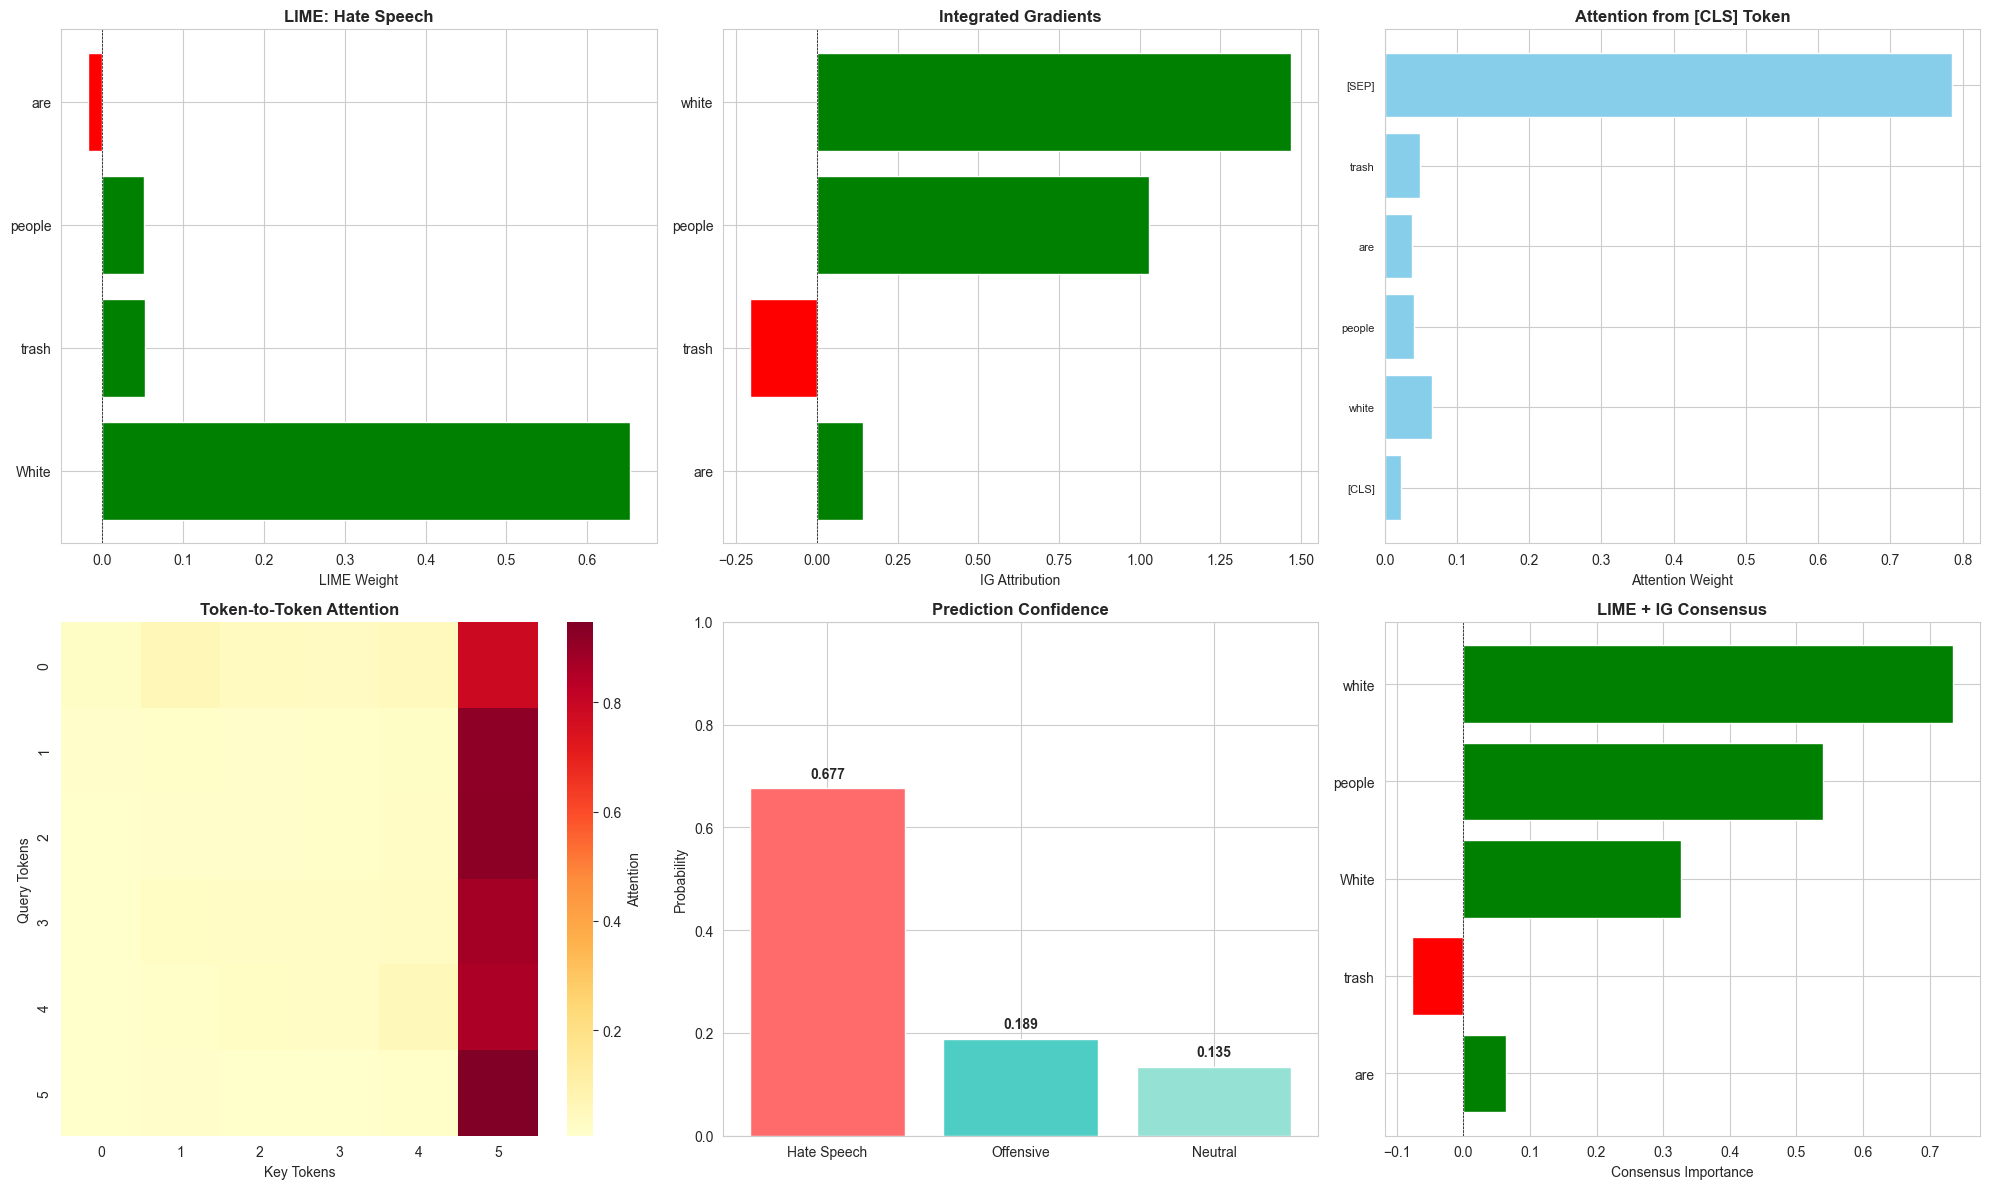


✓ Saved full explanation image: custom_input_explain_original.png


{'model_used': 'bert-base-uncased',
 'variant': 'original',
 'prediction': 'Hate Speech',
 'probabilities': array([0.6766831 , 0.18880136, 0.13451548], dtype=float32),
 'details': {'prediction': 0,
  'probabilities': [0.6766831278800964,
   0.1888013631105423,
   0.13451547920703888],
  'lime_explanation': {'White': 0.6524037090560754,
   'trash': 0.05245078395485759,
   'people': 0.051616248752386754,
   'are': -0.017324434917525194},
  'ig_tokens': ['white', 'people', 'are', 'trash'],
  'ig_attributions': [1.470007, 1.0284204, 0.14422071, -0.20731232],
  'attention_weights': [[0.021979162469506264,
    0.06485576927661896,
    0.0406174436211586,
    0.03819262608885765,
    0.04939126968383789,
    0.7849637269973755],
   [0.011492946185171604,
    0.01715003326535225,
    0.012477152049541473,
    0.020444389432668686,
    0.023593859747052193,
    0.9148415923118591],
   [0.007846331223845482,
    0.013825138099491596,
    0.013561511412262917,
    0.019559776410460472,
    0.0251

In [26]:
explain_custom_input("White people are trash", model_variant="original")



   MODEL USED: bert-base-uncased (SMOTE dataset)

User Input:
White people are trash

PREDICTION:
  → Hate Speech  (confidence: 0.999)

Probability Distribution:
  Hate Speech: 0.999
  Offensive: 0.001
  Neutral: 0.000

Generating explainability visualizations...

Comprehensive Explanation: bert-base-uncased
Text: White people are trash
Target Class: Hate Speech

Prediction: Hate Speech (0.999)
Probabilities:
  Hate Speech: 0.999
  Offensive: 0.001
  Neutral: 0.000

Generating LIME explanation...
Generating Integrated Gradients explanation...
Extracting attention patterns...

✓ Visualization saved to custom_input_explain_smote.png


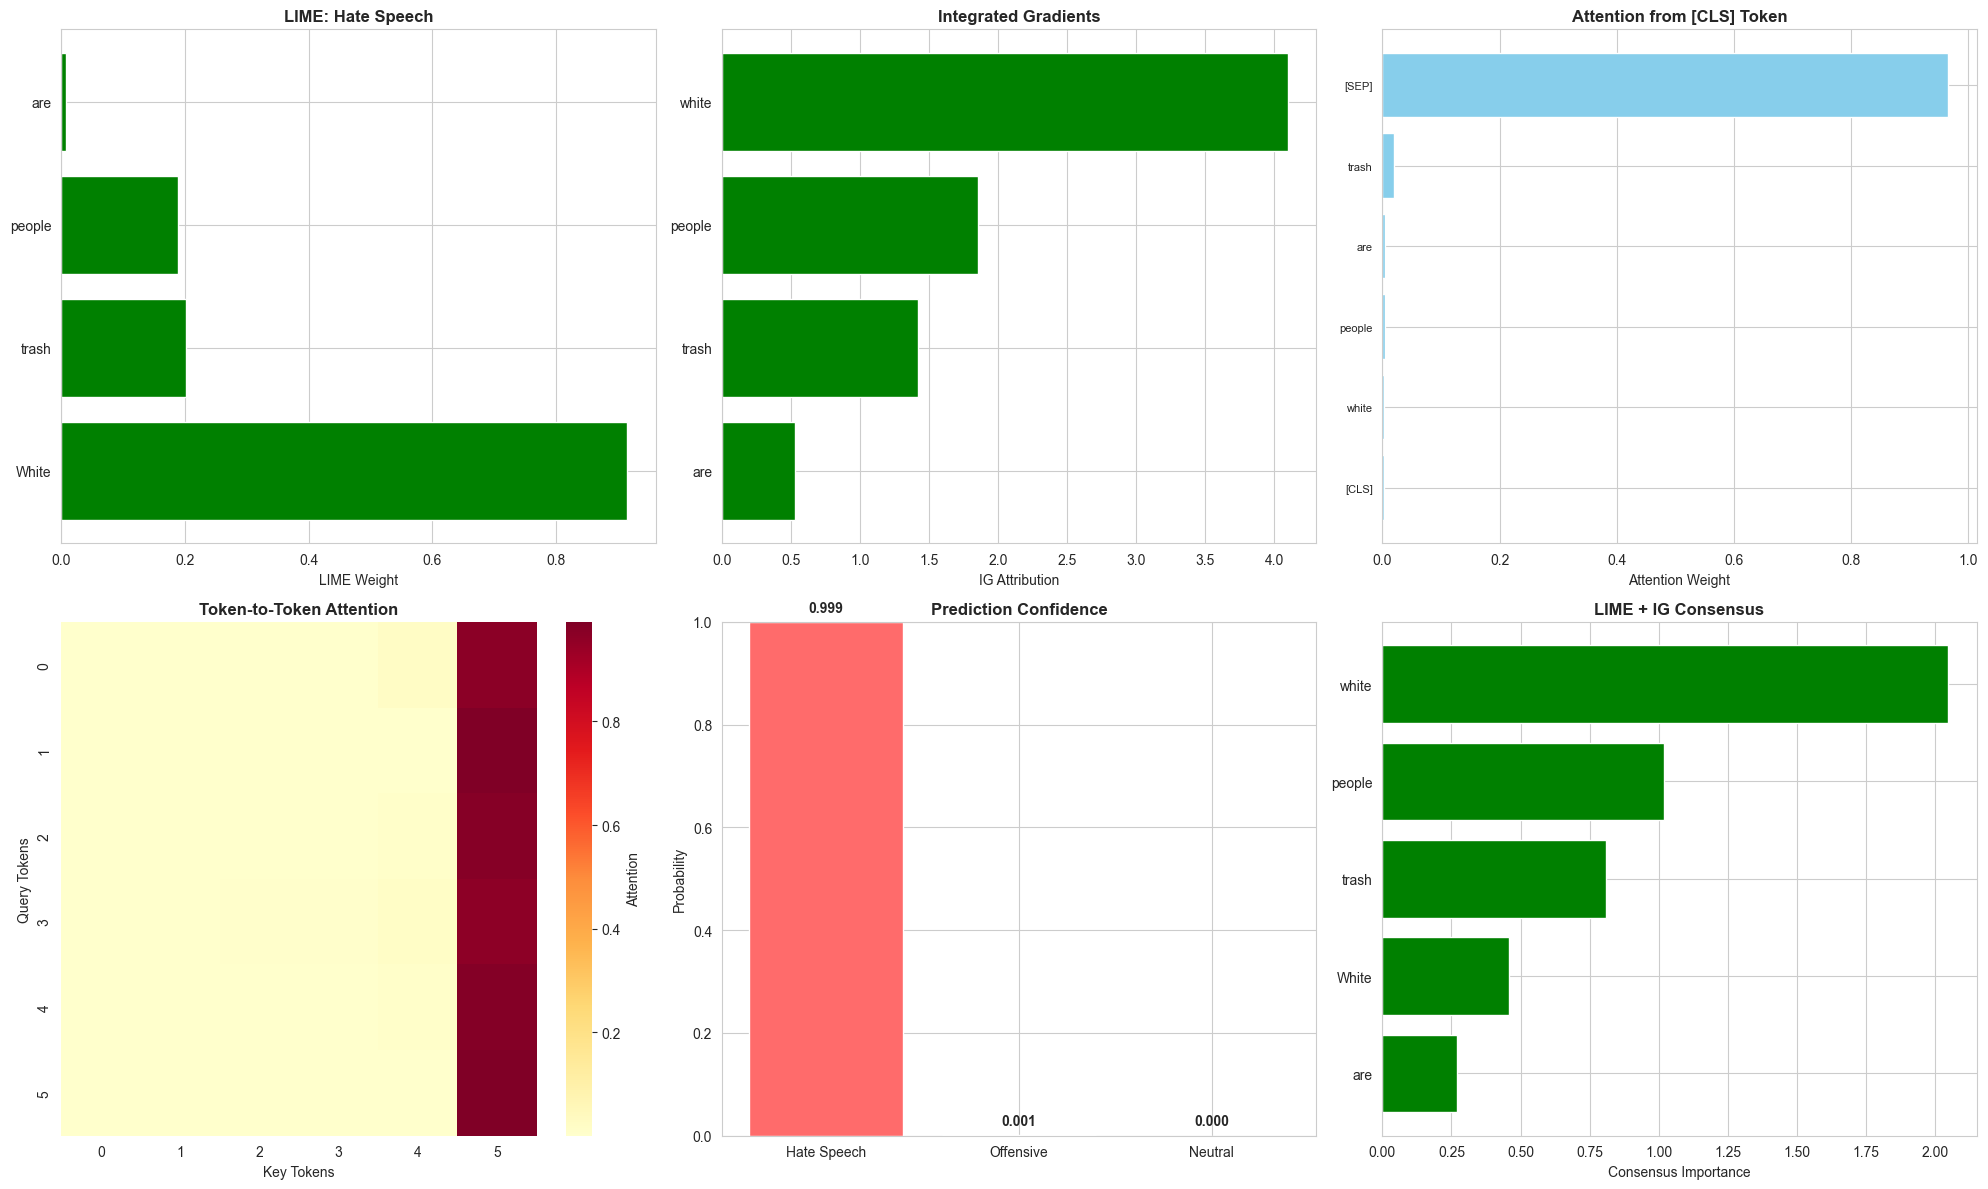


✓ Saved full explanation image: custom_input_explain_smote.png


{'model_used': 'bert-base-uncased',
 'variant': 'smote',
 'prediction': 'Hate Speech',
 'probabilities': array([9.9914491e-01, 7.5870834e-04, 9.6364602e-05], dtype=float32),
 'details': {'prediction': 0,
  'probabilities': [0.9991449117660522,
   0.0007587083382532,
   9.636460163164884e-05],
  'lime_explanation': {'White': 0.9148641566079162,
   'trash': 0.20212978603204185,
   'people': 0.18858854075277035,
   'are': 0.006920163801604215},
  'ig_tokens': ['white', 'people', 'are', 'trash'],
  'ig_attributions': [4.096241, 1.8504477, 0.53149223, 1.4165552],
  'attention_weights': [[0.0032124484423547983,
    0.0029156669043004513,
    0.004083083942532539,
    0.003686595940962434,
    0.02040749602019787,
    0.965694785118103],
   [0.0010490609565749764,
    0.0004453600849956274,
    0.001211825991049409,
    0.0011477658990770578,
    0.004177274648100138,
    0.9919688105583191],
   [0.0021964048501104116,
    0.0013579055666923523,
    0.0028082027565687895,
    0.00226184353232

In [25]:
explain_custom_input("White people are trash", model_variant="smote")
